In [6]:
import numpy as np

In [7]:
import numpy.linalg as linalg

In [10]:
class Riemann2:
    def __init__(self, L=10, gamma = 5/3, v_l = 0, v_r = 0, ro_l = 13, ro_r = 1.3, p_l = 10, p_r = 1, T = 0.015):
        self.L = L
        self.gamma = gamma
        self.v_l = v_l
        self.v_r = v_r
        self.ro_l = ro_l
        self.ro_r = ro_r
        self.p_l = p_l*1e5
        self.p_r = p_r*1e5
        self.T = T
        self.w0_l = [self.ro_l, self.ro_l*self.v_l, self.p_l/(self.gamma - 1)]
        self.w0_r = [self.ro_r, self.ro_r*self.v_r, self.p_r/(self.gamma - 1)]
        self.cfl_max = 0.01 
        self.tau = 1e-7
        self.h = 0.1
    def calculate(self):
        self.initials()
        time = 0
        layer_number = 0
        print('total - ', self.T/self.tau)
        while (time < self.T):
            time += self.tau
            layer_number += 1
            self.count_layer(layer_number)
    def initials(self):
        self.matrix = []
        layer = np.zeros([int(self.L/self.h), 3])
        omegas_T = np.zeros([int(self.L/self.h), 3, 3])
        omegas_T_inv = np.zeros([int(self.L/self.h), 3, 3])
        As = np.zeros([int(self.L/self.h), 3, 3])
        Ls = np.zeros([int(self.L/self.h), 3, 3])
        L_mods = np.zeros([int(self.L/self.h), 3, 3])
        
        for i in range(int(self.L/self.h)):
            
            if (i < int(self.L/self.h) / 2):
                layer[i] = self.w0_l
            else:
                layer[i] = self.w0_r
                
            cur_w = layer[i]
            cur_u = cur_w[1]/cur_w[0]
            cur_e = cur_w[2]/cur_w[0]
            #print(cur_e)
            c = (cur_e*self.gamma*(self.gamma - 1))**(0.5)


            omegas_T[i] = [[cur_u , c, self.gamma - 1], [-c**2 , 0, self.gamma - 1], [cur_u*c , -c, self.gamma - 1]]
            omegas_T_inv[i] = linalg.inv(omegas_T[i])
            As[i] = [[0, 1, 0], [-cur_u**2, 2*cur_u, self.gamma - 1], [-cur_u*cur_e*self.gamma, cur_e*self.gamma, cur_u]]
            lambdas = linalg.eigvals(As[i])
            Ls[i] = [[lambdas[0], 0, 0],[0, lambdas[1], 0],[0, 0, lambdas[2]]]
            L_mods[i] = [[np.abs(lambdas[0]), 0, 0],[0, np.abs(lambdas[1]), 0],[0, 0, np.abs(lambdas[2])]]
            
        self.matrix.append(layer)
        self.omegas_T = omegas_T
        self.omegas_T_inv = omegas_T_inv
        self.As = As
        self.Ls = Ls
        self.L_mods = L_mods
        
        CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
        while (CFL >= 1):
            self.tau = self.tau/10
            CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
    
    def count_layer(self, n):
        print('layer ', n)
        layer = np.zeros([int(self.L/self.h), 3])
        omegas_T = np.zeros([int(self.L/self.h), 3, 3])
        omegas_T_inv = np.zeros([int(self.L/self.h), 3, 3])
        As = np.zeros([int(self.L/self.h), 3, 3])
        Ls = np.zeros([int(self.L/self.h), 3, 3])
        L_mods = np.zeros([int(self.L/self.h), 3, 3])
        for i in range(int(self.L/self.h)):
            if (i != 0) and (i != int(self.L/self.h) - 1):
                a = self.matrix[n-1][i]
                b_0 = (self.matrix[n-1][i + 1] - self.matrix[n-1][i - 1])/(2*self.h)
                b = self.tau * np.matmul(self.As[i], b_0)
                c_0 = (self.matrix[n-1][i + 1] + self.matrix[n-1][i - 1] - 2*self.matrix[n - 1][i])/(2*self.h)
                c1 = np.matmul(self.omegas_T_inv[i], self.L_mods[i])
                c2 = np.matmul(c1,self.omegas_T[i])
                cf = self.tau*np.matmul(c2, c_0)
                layer[i] = a - b + cf
        
        layer[0] = layer[1]
        layer[int(self.L/self.h) - 1] = layer[int(self.L/self.h) - 2]
        self.matrix.append(layer)
        for i in range(int(self.L/self.h)):
            cur_w = self.matrix[n][i]
            cur_u = cur_w[1]/cur_w[0]
            cur_e = cur_w[2]/cur_w[0]
            #print(cur_e)
            c = (cur_e*self.gamma*(self.gamma - 1))**(0.5)
            omegas_T[i] = [[-cur_u*c , c, self.gamma - 1], [-c**2 , 0, self.gamma - 1], [cur_u*c , -c, self.gamma - 1]]
            omegas_T_inv[i] = linalg.inv(omegas_T[i])
            As[i] = [[0, 1, 0], [-cur_u**2, 2*cur_u, self.gamma - 1], [-cur_u*cur_e*self.gamma, cur_e*self.gamma, cur_u]]
            lambdas = linalg.eigvals(As[i])
            Ls[i] = [[lambdas[0], 0, 0],[0, lambdas[1], 0],[0, 0, lambdas[2]]]
            L_mods[i] = [[np.abs(lambdas[0]), 0, 0],[0, np.abs(lambdas[1]), 0],[0, 0, np.abs(lambdas[2])]]
            
        self.matrix.append(layer)
        self.omegas_T = omegas_T
        self.omegas_T_inv = omegas_T_inv
        self.As = As
        self.Ls = Ls
        self.L_mods = L_mods
        CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
        while (CFL >= 1):
            self.tau = self.tau/10
            CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
        

In [11]:
rm = Riemann2(L=20)
rm.calculate()

total -  150000.0
layer  1
layer  2
layer  3
layer  4
layer  5
layer  6
layer  7
layer  8
layer  9
layer  10
layer  11
layer  12
layer  13
layer  14
layer  15
layer  16
layer  17
layer  18
layer  19
layer  20
layer  21
layer  22
layer  23
layer  24
layer  25
layer  26
layer  27
layer  28
layer  29
layer  30
layer  31
layer  32
layer  33
layer  34
layer  35
layer  36
layer  37
layer  38
layer  39
layer  40
layer  41
layer  42
layer  43
layer  44
layer  45
layer  46
layer  47
layer  48
layer  49
layer  50
layer  51
layer  52
layer  53
layer  54
layer  55
layer  56
layer  57
layer  58
layer  59
layer  60
layer  61
layer  62
layer  63
layer  64
layer  65
layer  66
layer  67
layer  68
layer  69
layer  70
layer  71
layer  72
layer  73
layer  74
layer  75
layer  76
layer  77
layer  78
layer  79
layer  80
layer  81
layer  82
layer  83
layer  84
layer  85
layer  86
layer  87
layer  88
layer  89
layer  90
layer  91
layer  92
layer  93
layer  94
layer  95
layer  96
layer  97
layer  98
layer  99
l

layer  756
layer  757
layer  758
layer  759
layer  760
layer  761
layer  762
layer  763
layer  764
layer  765
layer  766
layer  767
layer  768
layer  769
layer  770
layer  771
layer  772
layer  773
layer  774
layer  775
layer  776
layer  777
layer  778
layer  779
layer  780
layer  781
layer  782
layer  783
layer  784
layer  785
layer  786
layer  787
layer  788
layer  789
layer  790
layer  791
layer  792
layer  793
layer  794
layer  795
layer  796
layer  797
layer  798
layer  799
layer  800
layer  801
layer  802
layer  803
layer  804
layer  805
layer  806
layer  807
layer  808
layer  809
layer  810
layer  811
layer  812
layer  813
layer  814
layer  815
layer  816
layer  817
layer  818
layer  819
layer  820
layer  821
layer  822
layer  823
layer  824
layer  825
layer  826
layer  827
layer  828
layer  829
layer  830
layer  831
layer  832
layer  833
layer  834
layer  835
layer  836
layer  837
layer  838
layer  839
layer  840
layer  841
layer  842
layer  843
layer  844
layer  845
layer  846

layer  1463
layer  1464
layer  1465
layer  1466
layer  1467
layer  1468
layer  1469
layer  1470
layer  1471
layer  1472
layer  1473
layer  1474
layer  1475
layer  1476
layer  1477
layer  1478
layer  1479
layer  1480
layer  1481
layer  1482
layer  1483
layer  1484
layer  1485
layer  1486
layer  1487
layer  1488
layer  1489
layer  1490
layer  1491
layer  1492
layer  1493
layer  1494
layer  1495
layer  1496
layer  1497
layer  1498
layer  1499
layer  1500
layer  1501
layer  1502
layer  1503
layer  1504
layer  1505
layer  1506
layer  1507
layer  1508
layer  1509
layer  1510
layer  1511
layer  1512
layer  1513
layer  1514
layer  1515
layer  1516
layer  1517
layer  1518
layer  1519
layer  1520
layer  1521
layer  1522
layer  1523
layer  1524
layer  1525
layer  1526
layer  1527
layer  1528
layer  1529
layer  1530
layer  1531
layer  1532
layer  1533
layer  1534
layer  1535
layer  1536
layer  1537
layer  1538
layer  1539
layer  1540
layer  1541
layer  1542
layer  1543
layer  1544
layer  1545
laye

layer  2147
layer  2148
layer  2149
layer  2150
layer  2151
layer  2152
layer  2153
layer  2154
layer  2155
layer  2156
layer  2157
layer  2158
layer  2159
layer  2160
layer  2161
layer  2162
layer  2163
layer  2164
layer  2165
layer  2166
layer  2167
layer  2168
layer  2169
layer  2170
layer  2171
layer  2172
layer  2173
layer  2174
layer  2175
layer  2176
layer  2177
layer  2178
layer  2179
layer  2180
layer  2181
layer  2182
layer  2183
layer  2184
layer  2185
layer  2186
layer  2187
layer  2188
layer  2189
layer  2190
layer  2191
layer  2192
layer  2193
layer  2194
layer  2195
layer  2196
layer  2197
layer  2198
layer  2199
layer  2200
layer  2201
layer  2202
layer  2203
layer  2204
layer  2205
layer  2206
layer  2207
layer  2208
layer  2209
layer  2210
layer  2211
layer  2212
layer  2213
layer  2214
layer  2215
layer  2216
layer  2217
layer  2218
layer  2219
layer  2220
layer  2221
layer  2222
layer  2223
layer  2224
layer  2225
layer  2226
layer  2227
layer  2228
layer  2229
laye

layer  2832
layer  2833
layer  2834
layer  2835
layer  2836
layer  2837
layer  2838
layer  2839
layer  2840
layer  2841
layer  2842
layer  2843
layer  2844
layer  2845
layer  2846
layer  2847
layer  2848
layer  2849
layer  2850
layer  2851
layer  2852
layer  2853
layer  2854
layer  2855
layer  2856
layer  2857
layer  2858
layer  2859
layer  2860
layer  2861
layer  2862
layer  2863
layer  2864
layer  2865
layer  2866
layer  2867
layer  2868
layer  2869
layer  2870
layer  2871
layer  2872
layer  2873
layer  2874
layer  2875
layer  2876
layer  2877
layer  2878
layer  2879
layer  2880
layer  2881
layer  2882
layer  2883
layer  2884
layer  2885
layer  2886
layer  2887
layer  2888
layer  2889
layer  2890
layer  2891
layer  2892
layer  2893
layer  2894
layer  2895
layer  2896
layer  2897
layer  2898
layer  2899
layer  2900
layer  2901
layer  2902
layer  2903
layer  2904
layer  2905
layer  2906
layer  2907
layer  2908
layer  2909
layer  2910
layer  2911
layer  2912
layer  2913
layer  2914
laye

layer  3519
layer  3520
layer  3521
layer  3522
layer  3523
layer  3524
layer  3525
layer  3526
layer  3527
layer  3528
layer  3529
layer  3530
layer  3531
layer  3532
layer  3533
layer  3534
layer  3535
layer  3536
layer  3537
layer  3538
layer  3539
layer  3540
layer  3541
layer  3542
layer  3543
layer  3544
layer  3545
layer  3546
layer  3547
layer  3548
layer  3549
layer  3550
layer  3551
layer  3552
layer  3553
layer  3554
layer  3555
layer  3556
layer  3557
layer  3558
layer  3559
layer  3560
layer  3561
layer  3562
layer  3563
layer  3564
layer  3565
layer  3566
layer  3567
layer  3568
layer  3569
layer  3570
layer  3571
layer  3572
layer  3573
layer  3574
layer  3575
layer  3576
layer  3577
layer  3578
layer  3579
layer  3580
layer  3581
layer  3582
layer  3583
layer  3584
layer  3585
layer  3586
layer  3587
layer  3588
layer  3589
layer  3590
layer  3591
layer  3592
layer  3593
layer  3594
layer  3595
layer  3596
layer  3597
layer  3598
layer  3599
layer  3600
layer  3601
laye

layer  4203
layer  4204
layer  4205
layer  4206
layer  4207
layer  4208
layer  4209
layer  4210
layer  4211
layer  4212
layer  4213
layer  4214
layer  4215
layer  4216
layer  4217
layer  4218
layer  4219
layer  4220
layer  4221
layer  4222
layer  4223
layer  4224
layer  4225
layer  4226
layer  4227
layer  4228
layer  4229
layer  4230
layer  4231
layer  4232
layer  4233
layer  4234
layer  4235
layer  4236
layer  4237
layer  4238
layer  4239
layer  4240
layer  4241
layer  4242
layer  4243
layer  4244
layer  4245
layer  4246
layer  4247
layer  4248
layer  4249
layer  4250
layer  4251
layer  4252
layer  4253
layer  4254
layer  4255
layer  4256
layer  4257
layer  4258
layer  4259
layer  4260
layer  4261
layer  4262
layer  4263
layer  4264
layer  4265
layer  4266
layer  4267
layer  4268
layer  4269
layer  4270
layer  4271
layer  4272
layer  4273
layer  4274
layer  4275
layer  4276
layer  4277
layer  4278
layer  4279
layer  4280
layer  4281
layer  4282
layer  4283
layer  4284
layer  4285
laye

layer  4895
layer  4896
layer  4897
layer  4898
layer  4899
layer  4900
layer  4901
layer  4902
layer  4903
layer  4904
layer  4905
layer  4906
layer  4907
layer  4908
layer  4909
layer  4910
layer  4911
layer  4912
layer  4913
layer  4914
layer  4915
layer  4916
layer  4917
layer  4918
layer  4919
layer  4920
layer  4921
layer  4922
layer  4923
layer  4924
layer  4925
layer  4926
layer  4927
layer  4928
layer  4929
layer  4930
layer  4931
layer  4932
layer  4933
layer  4934
layer  4935
layer  4936
layer  4937
layer  4938
layer  4939
layer  4940
layer  4941
layer  4942
layer  4943
layer  4944
layer  4945
layer  4946
layer  4947
layer  4948
layer  4949
layer  4950
layer  4951
layer  4952
layer  4953
layer  4954
layer  4955
layer  4956
layer  4957
layer  4958
layer  4959
layer  4960
layer  4961
layer  4962
layer  4963
layer  4964
layer  4965
layer  4966
layer  4967
layer  4968
layer  4969
layer  4970
layer  4971
layer  4972
layer  4973
layer  4974
layer  4975
layer  4976
layer  4977
laye

layer  5588
layer  5589
layer  5590
layer  5591
layer  5592
layer  5593
layer  5594
layer  5595
layer  5596
layer  5597
layer  5598
layer  5599
layer  5600
layer  5601
layer  5602
layer  5603
layer  5604
layer  5605
layer  5606
layer  5607
layer  5608
layer  5609
layer  5610
layer  5611
layer  5612
layer  5613
layer  5614
layer  5615
layer  5616
layer  5617
layer  5618
layer  5619
layer  5620
layer  5621
layer  5622
layer  5623
layer  5624
layer  5625
layer  5626
layer  5627
layer  5628
layer  5629
layer  5630
layer  5631
layer  5632
layer  5633
layer  5634
layer  5635
layer  5636
layer  5637
layer  5638
layer  5639
layer  5640
layer  5641
layer  5642
layer  5643
layer  5644
layer  5645
layer  5646
layer  5647
layer  5648
layer  5649
layer  5650
layer  5651
layer  5652
layer  5653
layer  5654
layer  5655
layer  5656
layer  5657
layer  5658
layer  5659
layer  5660
layer  5661
layer  5662
layer  5663
layer  5664
layer  5665
layer  5666
layer  5667
layer  5668
layer  5669
layer  5670
laye

layer  6277
layer  6278
layer  6279
layer  6280
layer  6281
layer  6282
layer  6283
layer  6284
layer  6285
layer  6286
layer  6287
layer  6288
layer  6289
layer  6290
layer  6291
layer  6292
layer  6293
layer  6294
layer  6295
layer  6296
layer  6297
layer  6298
layer  6299
layer  6300
layer  6301
layer  6302
layer  6303
layer  6304
layer  6305
layer  6306
layer  6307
layer  6308
layer  6309
layer  6310
layer  6311
layer  6312
layer  6313
layer  6314
layer  6315
layer  6316
layer  6317
layer  6318
layer  6319
layer  6320
layer  6321
layer  6322
layer  6323
layer  6324
layer  6325
layer  6326
layer  6327
layer  6328
layer  6329
layer  6330
layer  6331
layer  6332
layer  6333
layer  6334
layer  6335
layer  6336
layer  6337
layer  6338
layer  6339
layer  6340
layer  6341
layer  6342
layer  6343
layer  6344
layer  6345
layer  6346
layer  6347
layer  6348
layer  6349
layer  6350
layer  6351
layer  6352
layer  6353
layer  6354
layer  6355
layer  6356
layer  6357
layer  6358
layer  6359
laye

layer  6968
layer  6969
layer  6970
layer  6971
layer  6972
layer  6973
layer  6974
layer  6975
layer  6976
layer  6977
layer  6978
layer  6979
layer  6980
layer  6981
layer  6982
layer  6983
layer  6984
layer  6985
layer  6986
layer  6987
layer  6988
layer  6989
layer  6990
layer  6991
layer  6992
layer  6993
layer  6994
layer  6995
layer  6996
layer  6997
layer  6998
layer  6999
layer  7000
layer  7001
layer  7002
layer  7003
layer  7004
layer  7005
layer  7006
layer  7007
layer  7008
layer  7009
layer  7010
layer  7011
layer  7012
layer  7013
layer  7014
layer  7015
layer  7016
layer  7017
layer  7018
layer  7019
layer  7020
layer  7021
layer  7022
layer  7023
layer  7024
layer  7025
layer  7026
layer  7027
layer  7028
layer  7029
layer  7030
layer  7031
layer  7032
layer  7033
layer  7034
layer  7035
layer  7036
layer  7037
layer  7038
layer  7039
layer  7040
layer  7041
layer  7042
layer  7043
layer  7044
layer  7045
layer  7046
layer  7047
layer  7048
layer  7049
layer  7050
laye

layer  7656
layer  7657
layer  7658
layer  7659
layer  7660
layer  7661
layer  7662
layer  7663
layer  7664
layer  7665
layer  7666
layer  7667
layer  7668
layer  7669
layer  7670
layer  7671
layer  7672
layer  7673
layer  7674
layer  7675
layer  7676
layer  7677
layer  7678
layer  7679
layer  7680
layer  7681
layer  7682
layer  7683
layer  7684
layer  7685
layer  7686
layer  7687
layer  7688
layer  7689
layer  7690
layer  7691
layer  7692
layer  7693
layer  7694
layer  7695
layer  7696
layer  7697
layer  7698
layer  7699
layer  7700
layer  7701
layer  7702
layer  7703
layer  7704
layer  7705
layer  7706
layer  7707
layer  7708
layer  7709
layer  7710
layer  7711
layer  7712
layer  7713
layer  7714
layer  7715
layer  7716
layer  7717
layer  7718
layer  7719
layer  7720
layer  7721
layer  7722
layer  7723
layer  7724
layer  7725
layer  7726
layer  7727
layer  7728
layer  7729
layer  7730
layer  7731
layer  7732
layer  7733
layer  7734
layer  7735
layer  7736
layer  7737
layer  7738
laye

layer  8339
layer  8340
layer  8341
layer  8342
layer  8343
layer  8344
layer  8345
layer  8346
layer  8347
layer  8348
layer  8349
layer  8350
layer  8351
layer  8352
layer  8353
layer  8354
layer  8355
layer  8356
layer  8357
layer  8358
layer  8359
layer  8360
layer  8361
layer  8362
layer  8363
layer  8364
layer  8365
layer  8366
layer  8367
layer  8368
layer  8369
layer  8370
layer  8371
layer  8372
layer  8373
layer  8374
layer  8375
layer  8376
layer  8377
layer  8378
layer  8379
layer  8380
layer  8381
layer  8382
layer  8383
layer  8384
layer  8385
layer  8386
layer  8387
layer  8388
layer  8389
layer  8390
layer  8391
layer  8392
layer  8393
layer  8394
layer  8395
layer  8396
layer  8397
layer  8398
layer  8399
layer  8400
layer  8401
layer  8402
layer  8403
layer  8404
layer  8405
layer  8406
layer  8407
layer  8408
layer  8409
layer  8410
layer  8411
layer  8412
layer  8413
layer  8414
layer  8415
layer  8416
layer  8417
layer  8418
layer  8419
layer  8420
layer  8421
laye

layer  9028
layer  9029
layer  9030
layer  9031
layer  9032
layer  9033
layer  9034
layer  9035
layer  9036
layer  9037
layer  9038
layer  9039
layer  9040
layer  9041
layer  9042
layer  9043
layer  9044
layer  9045
layer  9046
layer  9047
layer  9048
layer  9049
layer  9050
layer  9051
layer  9052
layer  9053
layer  9054
layer  9055
layer  9056
layer  9057
layer  9058
layer  9059
layer  9060
layer  9061
layer  9062
layer  9063
layer  9064
layer  9065
layer  9066
layer  9067
layer  9068
layer  9069
layer  9070
layer  9071
layer  9072
layer  9073
layer  9074
layer  9075
layer  9076
layer  9077
layer  9078
layer  9079
layer  9080
layer  9081
layer  9082
layer  9083
layer  9084
layer  9085
layer  9086
layer  9087
layer  9088
layer  9089
layer  9090
layer  9091
layer  9092
layer  9093
layer  9094
layer  9095
layer  9096
layer  9097
layer  9098
layer  9099
layer  9100
layer  9101
layer  9102
layer  9103
layer  9104
layer  9105
layer  9106
layer  9107
layer  9108
layer  9109
layer  9110
laye

layer  9712
layer  9713
layer  9714
layer  9715
layer  9716
layer  9717
layer  9718
layer  9719
layer  9720
layer  9721
layer  9722
layer  9723
layer  9724
layer  9725
layer  9726
layer  9727
layer  9728
layer  9729
layer  9730
layer  9731
layer  9732
layer  9733
layer  9734
layer  9735
layer  9736
layer  9737
layer  9738
layer  9739
layer  9740
layer  9741
layer  9742
layer  9743
layer  9744
layer  9745
layer  9746
layer  9747
layer  9748
layer  9749
layer  9750
layer  9751
layer  9752
layer  9753
layer  9754
layer  9755
layer  9756
layer  9757
layer  9758
layer  9759
layer  9760
layer  9761
layer  9762
layer  9763
layer  9764
layer  9765
layer  9766
layer  9767
layer  9768
layer  9769
layer  9770
layer  9771
layer  9772
layer  9773
layer  9774
layer  9775
layer  9776
layer  9777
layer  9778
layer  9779
layer  9780
layer  9781
layer  9782
layer  9783
layer  9784
layer  9785
layer  9786
layer  9787
layer  9788
layer  9789
layer  9790
layer  9791
layer  9792
layer  9793
layer  9794
laye

layer  10367
layer  10368
layer  10369
layer  10370
layer  10371
layer  10372
layer  10373
layer  10374
layer  10375
layer  10376
layer  10377
layer  10378
layer  10379
layer  10380
layer  10381
layer  10382
layer  10383
layer  10384
layer  10385
layer  10386
layer  10387
layer  10388
layer  10389
layer  10390
layer  10391
layer  10392
layer  10393
layer  10394
layer  10395
layer  10396
layer  10397
layer  10398
layer  10399
layer  10400
layer  10401
layer  10402
layer  10403
layer  10404
layer  10405
layer  10406
layer  10407
layer  10408
layer  10409
layer  10410
layer  10411
layer  10412
layer  10413
layer  10414
layer  10415
layer  10416
layer  10417
layer  10418
layer  10419
layer  10420
layer  10421
layer  10422
layer  10423
layer  10424
layer  10425
layer  10426
layer  10427
layer  10428
layer  10429
layer  10430
layer  10431
layer  10432
layer  10433
layer  10434
layer  10435
layer  10436
layer  10437
layer  10438
layer  10439
layer  10440
layer  10441
layer  10442
layer  10443

layer  10999
layer  11000
layer  11001
layer  11002
layer  11003
layer  11004
layer  11005
layer  11006
layer  11007
layer  11008
layer  11009
layer  11010
layer  11011
layer  11012
layer  11013
layer  11014
layer  11015
layer  11016
layer  11017
layer  11018
layer  11019
layer  11020
layer  11021
layer  11022
layer  11023
layer  11024
layer  11025
layer  11026
layer  11027
layer  11028
layer  11029
layer  11030
layer  11031
layer  11032
layer  11033
layer  11034
layer  11035
layer  11036
layer  11037
layer  11038
layer  11039
layer  11040
layer  11041
layer  11042
layer  11043
layer  11044
layer  11045
layer  11046
layer  11047
layer  11048
layer  11049
layer  11050
layer  11051
layer  11052
layer  11053
layer  11054
layer  11055
layer  11056
layer  11057
layer  11058
layer  11059
layer  11060
layer  11061
layer  11062
layer  11063
layer  11064
layer  11065
layer  11066
layer  11067
layer  11068
layer  11069
layer  11070
layer  11071
layer  11072
layer  11073
layer  11074
layer  11075

layer  11631
layer  11632
layer  11633
layer  11634
layer  11635
layer  11636
layer  11637
layer  11638
layer  11639
layer  11640
layer  11641
layer  11642
layer  11643
layer  11644
layer  11645
layer  11646
layer  11647
layer  11648
layer  11649
layer  11650
layer  11651
layer  11652
layer  11653
layer  11654
layer  11655
layer  11656
layer  11657
layer  11658
layer  11659
layer  11660
layer  11661
layer  11662
layer  11663
layer  11664
layer  11665
layer  11666
layer  11667
layer  11668
layer  11669
layer  11670
layer  11671
layer  11672
layer  11673
layer  11674
layer  11675
layer  11676
layer  11677
layer  11678
layer  11679
layer  11680
layer  11681
layer  11682
layer  11683
layer  11684
layer  11685
layer  11686
layer  11687
layer  11688
layer  11689
layer  11690
layer  11691
layer  11692
layer  11693
layer  11694
layer  11695
layer  11696
layer  11697
layer  11698
layer  11699
layer  11700
layer  11701
layer  11702
layer  11703
layer  11704
layer  11705
layer  11706
layer  11707

layer  12268
layer  12269
layer  12270
layer  12271
layer  12272
layer  12273
layer  12274
layer  12275
layer  12276
layer  12277
layer  12278
layer  12279
layer  12280
layer  12281
layer  12282
layer  12283
layer  12284
layer  12285
layer  12286
layer  12287
layer  12288
layer  12289
layer  12290
layer  12291
layer  12292
layer  12293
layer  12294
layer  12295
layer  12296
layer  12297
layer  12298
layer  12299
layer  12300
layer  12301
layer  12302
layer  12303
layer  12304
layer  12305
layer  12306
layer  12307
layer  12308
layer  12309
layer  12310
layer  12311
layer  12312
layer  12313
layer  12314
layer  12315
layer  12316
layer  12317
layer  12318
layer  12319
layer  12320
layer  12321
layer  12322
layer  12323
layer  12324
layer  12325
layer  12326
layer  12327
layer  12328
layer  12329
layer  12330
layer  12331
layer  12332
layer  12333
layer  12334
layer  12335
layer  12336
layer  12337
layer  12338
layer  12339
layer  12340
layer  12341
layer  12342
layer  12343
layer  12344

layer  12906
layer  12907
layer  12908
layer  12909
layer  12910
layer  12911
layer  12912
layer  12913
layer  12914
layer  12915
layer  12916
layer  12917
layer  12918
layer  12919
layer  12920
layer  12921
layer  12922
layer  12923
layer  12924
layer  12925
layer  12926
layer  12927
layer  12928
layer  12929
layer  12930
layer  12931
layer  12932
layer  12933
layer  12934
layer  12935
layer  12936
layer  12937
layer  12938
layer  12939
layer  12940
layer  12941
layer  12942
layer  12943
layer  12944
layer  12945
layer  12946
layer  12947
layer  12948
layer  12949
layer  12950
layer  12951
layer  12952
layer  12953
layer  12954
layer  12955
layer  12956
layer  12957
layer  12958
layer  12959
layer  12960
layer  12961
layer  12962
layer  12963
layer  12964
layer  12965
layer  12966
layer  12967
layer  12968
layer  12969
layer  12970
layer  12971
layer  12972
layer  12973
layer  12974
layer  12975
layer  12976
layer  12977
layer  12978
layer  12979
layer  12980
layer  12981
layer  12982

layer  13544
layer  13545
layer  13546
layer  13547
layer  13548
layer  13549
layer  13550
layer  13551
layer  13552
layer  13553
layer  13554
layer  13555
layer  13556
layer  13557
layer  13558
layer  13559
layer  13560
layer  13561
layer  13562
layer  13563
layer  13564
layer  13565
layer  13566
layer  13567
layer  13568
layer  13569
layer  13570
layer  13571
layer  13572
layer  13573
layer  13574
layer  13575
layer  13576
layer  13577
layer  13578
layer  13579
layer  13580
layer  13581
layer  13582
layer  13583
layer  13584
layer  13585
layer  13586
layer  13587
layer  13588
layer  13589
layer  13590
layer  13591
layer  13592
layer  13593
layer  13594
layer  13595
layer  13596
layer  13597
layer  13598
layer  13599
layer  13600
layer  13601
layer  13602
layer  13603
layer  13604
layer  13605
layer  13606
layer  13607
layer  13608
layer  13609
layer  13610
layer  13611
layer  13612
layer  13613
layer  13614
layer  13615
layer  13616
layer  13617
layer  13618
layer  13619
layer  13620

layer  14176
layer  14177
layer  14178
layer  14179
layer  14180
layer  14181
layer  14182
layer  14183
layer  14184
layer  14185
layer  14186
layer  14187
layer  14188
layer  14189
layer  14190
layer  14191
layer  14192
layer  14193
layer  14194
layer  14195
layer  14196
layer  14197
layer  14198
layer  14199
layer  14200
layer  14201
layer  14202
layer  14203
layer  14204
layer  14205
layer  14206
layer  14207
layer  14208
layer  14209
layer  14210
layer  14211
layer  14212
layer  14213
layer  14214
layer  14215
layer  14216
layer  14217
layer  14218
layer  14219
layer  14220
layer  14221
layer  14222
layer  14223
layer  14224
layer  14225
layer  14226
layer  14227
layer  14228
layer  14229
layer  14230
layer  14231
layer  14232
layer  14233
layer  14234
layer  14235
layer  14236
layer  14237
layer  14238
layer  14239
layer  14240
layer  14241
layer  14242
layer  14243
layer  14244
layer  14245
layer  14246
layer  14247
layer  14248
layer  14249
layer  14250
layer  14251
layer  14252

layer  14813
layer  14814
layer  14815
layer  14816
layer  14817
layer  14818
layer  14819
layer  14820
layer  14821
layer  14822
layer  14823
layer  14824
layer  14825
layer  14826
layer  14827
layer  14828
layer  14829
layer  14830
layer  14831
layer  14832
layer  14833
layer  14834
layer  14835
layer  14836
layer  14837
layer  14838
layer  14839
layer  14840
layer  14841
layer  14842
layer  14843
layer  14844
layer  14845
layer  14846
layer  14847
layer  14848
layer  14849
layer  14850
layer  14851
layer  14852
layer  14853
layer  14854
layer  14855
layer  14856
layer  14857
layer  14858
layer  14859
layer  14860
layer  14861
layer  14862
layer  14863
layer  14864
layer  14865
layer  14866
layer  14867
layer  14868
layer  14869
layer  14870
layer  14871
layer  14872
layer  14873
layer  14874
layer  14875
layer  14876
layer  14877
layer  14878
layer  14879
layer  14880
layer  14881
layer  14882
layer  14883
layer  14884
layer  14885
layer  14886
layer  14887
layer  14888
layer  14889

layer  15450
layer  15451
layer  15452
layer  15453
layer  15454
layer  15455
layer  15456
layer  15457
layer  15458
layer  15459
layer  15460
layer  15461
layer  15462
layer  15463
layer  15464
layer  15465
layer  15466
layer  15467
layer  15468
layer  15469
layer  15470
layer  15471
layer  15472
layer  15473
layer  15474
layer  15475
layer  15476
layer  15477
layer  15478
layer  15479
layer  15480
layer  15481
layer  15482
layer  15483
layer  15484
layer  15485
layer  15486
layer  15487
layer  15488
layer  15489
layer  15490
layer  15491
layer  15492
layer  15493
layer  15494
layer  15495
layer  15496
layer  15497
layer  15498
layer  15499
layer  15500
layer  15501
layer  15502
layer  15503
layer  15504
layer  15505
layer  15506
layer  15507
layer  15508
layer  15509
layer  15510
layer  15511
layer  15512
layer  15513
layer  15514
layer  15515
layer  15516
layer  15517
layer  15518
layer  15519
layer  15520
layer  15521
layer  15522
layer  15523
layer  15524
layer  15525
layer  15526

layer  16084
layer  16085
layer  16086
layer  16087
layer  16088
layer  16089
layer  16090
layer  16091
layer  16092
layer  16093
layer  16094
layer  16095
layer  16096
layer  16097
layer  16098
layer  16099
layer  16100
layer  16101
layer  16102
layer  16103
layer  16104
layer  16105
layer  16106
layer  16107
layer  16108
layer  16109
layer  16110
layer  16111
layer  16112
layer  16113
layer  16114
layer  16115
layer  16116
layer  16117
layer  16118
layer  16119
layer  16120
layer  16121
layer  16122
layer  16123
layer  16124
layer  16125
layer  16126
layer  16127
layer  16128
layer  16129
layer  16130
layer  16131
layer  16132
layer  16133
layer  16134
layer  16135
layer  16136
layer  16137
layer  16138
layer  16139
layer  16140
layer  16141
layer  16142
layer  16143
layer  16144
layer  16145
layer  16146
layer  16147
layer  16148
layer  16149
layer  16150
layer  16151
layer  16152
layer  16153
layer  16154
layer  16155
layer  16156
layer  16157
layer  16158
layer  16159
layer  16160

layer  16721
layer  16722
layer  16723
layer  16724
layer  16725
layer  16726
layer  16727
layer  16728
layer  16729
layer  16730
layer  16731
layer  16732
layer  16733
layer  16734
layer  16735
layer  16736
layer  16737
layer  16738
layer  16739
layer  16740
layer  16741
layer  16742
layer  16743
layer  16744
layer  16745
layer  16746
layer  16747
layer  16748
layer  16749
layer  16750
layer  16751
layer  16752
layer  16753
layer  16754
layer  16755
layer  16756
layer  16757
layer  16758
layer  16759
layer  16760
layer  16761
layer  16762
layer  16763
layer  16764
layer  16765
layer  16766
layer  16767
layer  16768
layer  16769
layer  16770
layer  16771
layer  16772
layer  16773
layer  16774
layer  16775
layer  16776
layer  16777
layer  16778
layer  16779
layer  16780
layer  16781
layer  16782
layer  16783
layer  16784
layer  16785
layer  16786
layer  16787
layer  16788
layer  16789
layer  16790
layer  16791
layer  16792
layer  16793
layer  16794
layer  16795
layer  16796
layer  16797

layer  17352
layer  17353
layer  17354
layer  17355
layer  17356
layer  17357
layer  17358
layer  17359
layer  17360
layer  17361
layer  17362
layer  17363
layer  17364
layer  17365
layer  17366
layer  17367
layer  17368
layer  17369
layer  17370
layer  17371
layer  17372
layer  17373
layer  17374
layer  17375
layer  17376
layer  17377
layer  17378
layer  17379
layer  17380
layer  17381
layer  17382
layer  17383
layer  17384
layer  17385
layer  17386
layer  17387
layer  17388
layer  17389
layer  17390
layer  17391
layer  17392
layer  17393
layer  17394
layer  17395
layer  17396
layer  17397
layer  17398
layer  17399
layer  17400
layer  17401
layer  17402
layer  17403
layer  17404
layer  17405
layer  17406
layer  17407
layer  17408
layer  17409
layer  17410
layer  17411
layer  17412
layer  17413
layer  17414
layer  17415
layer  17416
layer  17417
layer  17418
layer  17419
layer  17420
layer  17421
layer  17422
layer  17423
layer  17424
layer  17425
layer  17426
layer  17427
layer  17428

layer  17987
layer  17988
layer  17989
layer  17990
layer  17991
layer  17992
layer  17993
layer  17994
layer  17995
layer  17996
layer  17997
layer  17998
layer  17999
layer  18000
layer  18001
layer  18002
layer  18003
layer  18004
layer  18005
layer  18006
layer  18007
layer  18008
layer  18009
layer  18010
layer  18011
layer  18012
layer  18013
layer  18014
layer  18015
layer  18016
layer  18017
layer  18018
layer  18019
layer  18020
layer  18021
layer  18022
layer  18023
layer  18024
layer  18025
layer  18026
layer  18027
layer  18028
layer  18029
layer  18030
layer  18031
layer  18032
layer  18033
layer  18034
layer  18035
layer  18036
layer  18037
layer  18038
layer  18039
layer  18040
layer  18041
layer  18042
layer  18043
layer  18044
layer  18045
layer  18046
layer  18047
layer  18048
layer  18049
layer  18050
layer  18051
layer  18052
layer  18053
layer  18054
layer  18055
layer  18056
layer  18057
layer  18058
layer  18059
layer  18060
layer  18061
layer  18062
layer  18063

layer  18618
layer  18619
layer  18620
layer  18621
layer  18622
layer  18623
layer  18624
layer  18625
layer  18626
layer  18627
layer  18628
layer  18629
layer  18630
layer  18631
layer  18632
layer  18633
layer  18634
layer  18635
layer  18636
layer  18637
layer  18638
layer  18639
layer  18640
layer  18641
layer  18642
layer  18643
layer  18644
layer  18645
layer  18646
layer  18647
layer  18648
layer  18649
layer  18650
layer  18651
layer  18652
layer  18653
layer  18654
layer  18655
layer  18656
layer  18657
layer  18658
layer  18659
layer  18660
layer  18661
layer  18662
layer  18663
layer  18664
layer  18665
layer  18666
layer  18667
layer  18668
layer  18669
layer  18670
layer  18671
layer  18672
layer  18673
layer  18674
layer  18675
layer  18676
layer  18677
layer  18678
layer  18679
layer  18680
layer  18681
layer  18682
layer  18683
layer  18684
layer  18685
layer  18686
layer  18687
layer  18688
layer  18689
layer  18690
layer  18691
layer  18692
layer  18693
layer  18694

layer  19252
layer  19253
layer  19254
layer  19255
layer  19256
layer  19257
layer  19258
layer  19259
layer  19260
layer  19261
layer  19262
layer  19263
layer  19264
layer  19265
layer  19266
layer  19267
layer  19268
layer  19269
layer  19270
layer  19271
layer  19272
layer  19273
layer  19274
layer  19275
layer  19276
layer  19277
layer  19278
layer  19279
layer  19280
layer  19281
layer  19282
layer  19283
layer  19284
layer  19285
layer  19286
layer  19287
layer  19288
layer  19289
layer  19290
layer  19291
layer  19292
layer  19293
layer  19294
layer  19295
layer  19296
layer  19297
layer  19298
layer  19299
layer  19300
layer  19301
layer  19302
layer  19303
layer  19304
layer  19305
layer  19306
layer  19307
layer  19308
layer  19309
layer  19310
layer  19311
layer  19312
layer  19313
layer  19314
layer  19315
layer  19316
layer  19317
layer  19318
layer  19319
layer  19320
layer  19321
layer  19322
layer  19323
layer  19324
layer  19325
layer  19326
layer  19327
layer  19328

layer  19885
layer  19886
layer  19887
layer  19888
layer  19889
layer  19890
layer  19891
layer  19892
layer  19893
layer  19894
layer  19895
layer  19896
layer  19897
layer  19898
layer  19899
layer  19900
layer  19901
layer  19902
layer  19903
layer  19904
layer  19905
layer  19906
layer  19907
layer  19908
layer  19909
layer  19910
layer  19911
layer  19912
layer  19913
layer  19914
layer  19915
layer  19916
layer  19917
layer  19918
layer  19919
layer  19920
layer  19921
layer  19922
layer  19923
layer  19924
layer  19925
layer  19926
layer  19927
layer  19928
layer  19929
layer  19930
layer  19931
layer  19932
layer  19933
layer  19934
layer  19935
layer  19936
layer  19937
layer  19938
layer  19939
layer  19940
layer  19941
layer  19942
layer  19943
layer  19944
layer  19945
layer  19946
layer  19947
layer  19948
layer  19949
layer  19950
layer  19951
layer  19952
layer  19953
layer  19954
layer  19955
layer  19956
layer  19957
layer  19958
layer  19959
layer  19960
layer  19961

layer  20516
layer  20517
layer  20518
layer  20519
layer  20520
layer  20521
layer  20522
layer  20523
layer  20524
layer  20525
layer  20526
layer  20527
layer  20528
layer  20529
layer  20530
layer  20531
layer  20532
layer  20533
layer  20534
layer  20535
layer  20536
layer  20537
layer  20538
layer  20539
layer  20540
layer  20541
layer  20542
layer  20543
layer  20544
layer  20545
layer  20546
layer  20547
layer  20548
layer  20549
layer  20550
layer  20551
layer  20552
layer  20553
layer  20554
layer  20555
layer  20556
layer  20557
layer  20558
layer  20559
layer  20560
layer  20561
layer  20562
layer  20563
layer  20564
layer  20565
layer  20566
layer  20567
layer  20568
layer  20569
layer  20570
layer  20571
layer  20572
layer  20573
layer  20574
layer  20575
layer  20576
layer  20577
layer  20578
layer  20579
layer  20580
layer  20581
layer  20582
layer  20583
layer  20584
layer  20585
layer  20586
layer  20587
layer  20588
layer  20589
layer  20590
layer  20591
layer  20592

layer  21149
layer  21150
layer  21151
layer  21152
layer  21153
layer  21154
layer  21155
layer  21156
layer  21157
layer  21158
layer  21159
layer  21160
layer  21161
layer  21162
layer  21163
layer  21164
layer  21165
layer  21166
layer  21167
layer  21168
layer  21169
layer  21170
layer  21171
layer  21172
layer  21173
layer  21174
layer  21175
layer  21176
layer  21177
layer  21178
layer  21179
layer  21180
layer  21181
layer  21182
layer  21183
layer  21184
layer  21185
layer  21186
layer  21187
layer  21188
layer  21189
layer  21190
layer  21191
layer  21192
layer  21193
layer  21194
layer  21195
layer  21196
layer  21197
layer  21198
layer  21199
layer  21200
layer  21201
layer  21202
layer  21203
layer  21204
layer  21205
layer  21206
layer  21207
layer  21208
layer  21209
layer  21210
layer  21211
layer  21212
layer  21213
layer  21214
layer  21215
layer  21216
layer  21217
layer  21218
layer  21219
layer  21220
layer  21221
layer  21222
layer  21223
layer  21224
layer  21225

layer  21784
layer  21785
layer  21786
layer  21787
layer  21788
layer  21789
layer  21790
layer  21791
layer  21792
layer  21793
layer  21794
layer  21795
layer  21796
layer  21797
layer  21798
layer  21799
layer  21800
layer  21801
layer  21802
layer  21803
layer  21804
layer  21805
layer  21806
layer  21807
layer  21808
layer  21809
layer  21810
layer  21811
layer  21812
layer  21813
layer  21814
layer  21815
layer  21816
layer  21817
layer  21818
layer  21819
layer  21820
layer  21821
layer  21822
layer  21823
layer  21824
layer  21825
layer  21826
layer  21827
layer  21828
layer  21829
layer  21830
layer  21831
layer  21832
layer  21833
layer  21834
layer  21835
layer  21836
layer  21837
layer  21838
layer  21839
layer  21840
layer  21841
layer  21842
layer  21843
layer  21844
layer  21845
layer  21846
layer  21847
layer  21848
layer  21849
layer  21850
layer  21851
layer  21852
layer  21853
layer  21854
layer  21855
layer  21856
layer  21857
layer  21858
layer  21859
layer  21860

layer  22418
layer  22419
layer  22420
layer  22421
layer  22422
layer  22423
layer  22424
layer  22425
layer  22426
layer  22427
layer  22428
layer  22429
layer  22430
layer  22431
layer  22432
layer  22433
layer  22434
layer  22435
layer  22436
layer  22437
layer  22438
layer  22439
layer  22440
layer  22441
layer  22442
layer  22443
layer  22444
layer  22445
layer  22446
layer  22447
layer  22448
layer  22449
layer  22450
layer  22451
layer  22452
layer  22453
layer  22454
layer  22455
layer  22456
layer  22457
layer  22458
layer  22459
layer  22460
layer  22461
layer  22462
layer  22463
layer  22464
layer  22465
layer  22466
layer  22467
layer  22468
layer  22469
layer  22470
layer  22471
layer  22472
layer  22473
layer  22474
layer  22475
layer  22476
layer  22477
layer  22478
layer  22479
layer  22480
layer  22481
layer  22482
layer  22483
layer  22484
layer  22485
layer  22486
layer  22487
layer  22488
layer  22489
layer  22490
layer  22491
layer  22492
layer  22493
layer  22494

layer  23055
layer  23056
layer  23057
layer  23058
layer  23059
layer  23060
layer  23061
layer  23062
layer  23063
layer  23064
layer  23065
layer  23066
layer  23067
layer  23068
layer  23069
layer  23070
layer  23071
layer  23072
layer  23073
layer  23074
layer  23075
layer  23076
layer  23077
layer  23078
layer  23079
layer  23080
layer  23081
layer  23082
layer  23083
layer  23084
layer  23085
layer  23086
layer  23087
layer  23088
layer  23089
layer  23090
layer  23091
layer  23092
layer  23093
layer  23094
layer  23095
layer  23096
layer  23097
layer  23098
layer  23099
layer  23100
layer  23101
layer  23102
layer  23103
layer  23104
layer  23105
layer  23106
layer  23107
layer  23108
layer  23109
layer  23110
layer  23111
layer  23112
layer  23113
layer  23114
layer  23115
layer  23116
layer  23117
layer  23118
layer  23119
layer  23120
layer  23121
layer  23122
layer  23123
layer  23124
layer  23125
layer  23126
layer  23127
layer  23128
layer  23129
layer  23130
layer  23131

layer  23690
layer  23691
layer  23692
layer  23693
layer  23694
layer  23695
layer  23696
layer  23697
layer  23698
layer  23699
layer  23700
layer  23701
layer  23702
layer  23703
layer  23704
layer  23705
layer  23706
layer  23707
layer  23708
layer  23709
layer  23710
layer  23711
layer  23712
layer  23713
layer  23714
layer  23715
layer  23716
layer  23717
layer  23718
layer  23719
layer  23720
layer  23721
layer  23722
layer  23723
layer  23724
layer  23725
layer  23726
layer  23727
layer  23728
layer  23729
layer  23730
layer  23731
layer  23732
layer  23733
layer  23734
layer  23735
layer  23736
layer  23737
layer  23738
layer  23739
layer  23740
layer  23741
layer  23742
layer  23743
layer  23744
layer  23745
layer  23746
layer  23747
layer  23748
layer  23749
layer  23750
layer  23751
layer  23752
layer  23753
layer  23754
layer  23755
layer  23756
layer  23757
layer  23758
layer  23759
layer  23760
layer  23761
layer  23762
layer  23763
layer  23764
layer  23765
layer  23766

layer  24326
layer  24327
layer  24328
layer  24329
layer  24330
layer  24331
layer  24332
layer  24333
layer  24334
layer  24335
layer  24336
layer  24337
layer  24338
layer  24339
layer  24340
layer  24341
layer  24342
layer  24343
layer  24344
layer  24345
layer  24346
layer  24347
layer  24348
layer  24349
layer  24350
layer  24351
layer  24352
layer  24353
layer  24354
layer  24355
layer  24356
layer  24357
layer  24358
layer  24359
layer  24360
layer  24361
layer  24362
layer  24363
layer  24364
layer  24365
layer  24366
layer  24367
layer  24368
layer  24369
layer  24370
layer  24371
layer  24372
layer  24373
layer  24374
layer  24375
layer  24376
layer  24377
layer  24378
layer  24379
layer  24380
layer  24381
layer  24382
layer  24383
layer  24384
layer  24385
layer  24386
layer  24387
layer  24388
layer  24389
layer  24390
layer  24391
layer  24392
layer  24393
layer  24394
layer  24395
layer  24396
layer  24397
layer  24398
layer  24399
layer  24400
layer  24401
layer  24402

layer  24965
layer  24966
layer  24967
layer  24968
layer  24969
layer  24970
layer  24971
layer  24972
layer  24973
layer  24974
layer  24975
layer  24976
layer  24977
layer  24978
layer  24979
layer  24980
layer  24981
layer  24982
layer  24983
layer  24984
layer  24985
layer  24986
layer  24987
layer  24988
layer  24989
layer  24990
layer  24991
layer  24992
layer  24993
layer  24994
layer  24995
layer  24996
layer  24997
layer  24998
layer  24999
layer  25000
layer  25001
layer  25002
layer  25003
layer  25004
layer  25005
layer  25006
layer  25007
layer  25008
layer  25009
layer  25010
layer  25011
layer  25012
layer  25013
layer  25014
layer  25015
layer  25016
layer  25017
layer  25018
layer  25019
layer  25020
layer  25021
layer  25022
layer  25023
layer  25024
layer  25025
layer  25026
layer  25027
layer  25028
layer  25029
layer  25030
layer  25031
layer  25032
layer  25033
layer  25034
layer  25035
layer  25036
layer  25037
layer  25038
layer  25039
layer  25040
layer  25041

layer  25604
layer  25605
layer  25606
layer  25607
layer  25608
layer  25609
layer  25610
layer  25611
layer  25612
layer  25613
layer  25614
layer  25615
layer  25616
layer  25617
layer  25618
layer  25619
layer  25620
layer  25621
layer  25622
layer  25623
layer  25624
layer  25625
layer  25626
layer  25627
layer  25628
layer  25629
layer  25630
layer  25631
layer  25632
layer  25633
layer  25634
layer  25635
layer  25636
layer  25637
layer  25638
layer  25639
layer  25640
layer  25641
layer  25642
layer  25643
layer  25644
layer  25645
layer  25646
layer  25647
layer  25648
layer  25649
layer  25650
layer  25651
layer  25652
layer  25653
layer  25654
layer  25655
layer  25656
layer  25657
layer  25658
layer  25659
layer  25660
layer  25661
layer  25662
layer  25663
layer  25664
layer  25665
layer  25666
layer  25667
layer  25668
layer  25669
layer  25670
layer  25671
layer  25672
layer  25673
layer  25674
layer  25675
layer  25676
layer  25677
layer  25678
layer  25679
layer  25680

layer  26243
layer  26244
layer  26245
layer  26246
layer  26247
layer  26248
layer  26249
layer  26250
layer  26251
layer  26252
layer  26253
layer  26254
layer  26255
layer  26256
layer  26257
layer  26258
layer  26259
layer  26260
layer  26261
layer  26262
layer  26263
layer  26264
layer  26265
layer  26266
layer  26267
layer  26268
layer  26269
layer  26270
layer  26271
layer  26272
layer  26273
layer  26274
layer  26275
layer  26276
layer  26277
layer  26278
layer  26279
layer  26280
layer  26281
layer  26282
layer  26283
layer  26284
layer  26285
layer  26286
layer  26287
layer  26288
layer  26289
layer  26290
layer  26291
layer  26292
layer  26293
layer  26294
layer  26295
layer  26296
layer  26297
layer  26298
layer  26299
layer  26300
layer  26301
layer  26302
layer  26303
layer  26304
layer  26305
layer  26306
layer  26307
layer  26308
layer  26309
layer  26310
layer  26311
layer  26312
layer  26313
layer  26314
layer  26315
layer  26316
layer  26317
layer  26318
layer  26319

layer  26881
layer  26882
layer  26883
layer  26884
layer  26885
layer  26886
layer  26887
layer  26888
layer  26889
layer  26890
layer  26891
layer  26892
layer  26893
layer  26894
layer  26895
layer  26896
layer  26897
layer  26898
layer  26899
layer  26900
layer  26901
layer  26902
layer  26903
layer  26904
layer  26905
layer  26906
layer  26907
layer  26908
layer  26909
layer  26910
layer  26911
layer  26912
layer  26913
layer  26914
layer  26915
layer  26916
layer  26917
layer  26918
layer  26919
layer  26920
layer  26921
layer  26922
layer  26923
layer  26924
layer  26925
layer  26926
layer  26927
layer  26928
layer  26929
layer  26930
layer  26931
layer  26932
layer  26933
layer  26934
layer  26935
layer  26936
layer  26937
layer  26938
layer  26939
layer  26940
layer  26941
layer  26942
layer  26943
layer  26944
layer  26945
layer  26946
layer  26947
layer  26948
layer  26949
layer  26950
layer  26951
layer  26952
layer  26953
layer  26954
layer  26955
layer  26956
layer  26957

layer  27513
layer  27514
layer  27515
layer  27516
layer  27517
layer  27518
layer  27519
layer  27520
layer  27521
layer  27522
layer  27523
layer  27524
layer  27525
layer  27526
layer  27527
layer  27528
layer  27529
layer  27530
layer  27531
layer  27532
layer  27533
layer  27534
layer  27535
layer  27536
layer  27537
layer  27538
layer  27539
layer  27540
layer  27541
layer  27542
layer  27543
layer  27544
layer  27545
layer  27546
layer  27547
layer  27548
layer  27549
layer  27550
layer  27551
layer  27552
layer  27553
layer  27554
layer  27555
layer  27556
layer  27557
layer  27558
layer  27559
layer  27560
layer  27561
layer  27562
layer  27563
layer  27564
layer  27565
layer  27566
layer  27567
layer  27568
layer  27569
layer  27570
layer  27571
layer  27572
layer  27573
layer  27574
layer  27575
layer  27576
layer  27577
layer  27578
layer  27579
layer  27580
layer  27581
layer  27582
layer  27583
layer  27584
layer  27585
layer  27586
layer  27587
layer  27588
layer  27589

layer  28148
layer  28149
layer  28150
layer  28151
layer  28152
layer  28153
layer  28154
layer  28155
layer  28156
layer  28157
layer  28158
layer  28159
layer  28160
layer  28161
layer  28162
layer  28163
layer  28164
layer  28165
layer  28166
layer  28167
layer  28168
layer  28169
layer  28170
layer  28171
layer  28172
layer  28173
layer  28174
layer  28175
layer  28176
layer  28177
layer  28178
layer  28179
layer  28180
layer  28181
layer  28182
layer  28183
layer  28184
layer  28185
layer  28186
layer  28187
layer  28188
layer  28189
layer  28190
layer  28191
layer  28192
layer  28193
layer  28194
layer  28195
layer  28196
layer  28197
layer  28198
layer  28199
layer  28200
layer  28201
layer  28202
layer  28203
layer  28204
layer  28205
layer  28206
layer  28207
layer  28208
layer  28209
layer  28210
layer  28211
layer  28212
layer  28213
layer  28214
layer  28215
layer  28216
layer  28217
layer  28218
layer  28219
layer  28220
layer  28221
layer  28222
layer  28223
layer  28224

layer  28786
layer  28787
layer  28788
layer  28789
layer  28790
layer  28791
layer  28792
layer  28793
layer  28794
layer  28795
layer  28796
layer  28797
layer  28798
layer  28799
layer  28800
layer  28801
layer  28802
layer  28803
layer  28804
layer  28805
layer  28806
layer  28807
layer  28808
layer  28809
layer  28810
layer  28811
layer  28812
layer  28813
layer  28814
layer  28815
layer  28816
layer  28817
layer  28818
layer  28819
layer  28820
layer  28821
layer  28822
layer  28823
layer  28824
layer  28825
layer  28826
layer  28827
layer  28828
layer  28829
layer  28830
layer  28831
layer  28832
layer  28833
layer  28834
layer  28835
layer  28836
layer  28837
layer  28838
layer  28839
layer  28840
layer  28841
layer  28842
layer  28843
layer  28844
layer  28845
layer  28846
layer  28847
layer  28848
layer  28849
layer  28850
layer  28851
layer  28852
layer  28853
layer  28854
layer  28855
layer  28856
layer  28857
layer  28858
layer  28859
layer  28860
layer  28861
layer  28862

layer  29426
layer  29427
layer  29428
layer  29429
layer  29430
layer  29431
layer  29432
layer  29433
layer  29434
layer  29435
layer  29436
layer  29437
layer  29438
layer  29439
layer  29440
layer  29441
layer  29442
layer  29443
layer  29444
layer  29445
layer  29446
layer  29447
layer  29448
layer  29449
layer  29450
layer  29451
layer  29452
layer  29453
layer  29454
layer  29455
layer  29456
layer  29457
layer  29458
layer  29459
layer  29460
layer  29461
layer  29462
layer  29463
layer  29464
layer  29465
layer  29466
layer  29467
layer  29468
layer  29469
layer  29470
layer  29471
layer  29472
layer  29473
layer  29474
layer  29475
layer  29476
layer  29477
layer  29478
layer  29479
layer  29480
layer  29481
layer  29482
layer  29483
layer  29484
layer  29485
layer  29486
layer  29487
layer  29488
layer  29489
layer  29490
layer  29491
layer  29492
layer  29493
layer  29494
layer  29495
layer  29496
layer  29497
layer  29498
layer  29499
layer  29500
layer  29501
layer  29502

layer  30061
layer  30062
layer  30063
layer  30064
layer  30065
layer  30066
layer  30067
layer  30068
layer  30069
layer  30070
layer  30071
layer  30072
layer  30073
layer  30074
layer  30075
layer  30076
layer  30077
layer  30078
layer  30079
layer  30080
layer  30081
layer  30082
layer  30083
layer  30084
layer  30085
layer  30086
layer  30087
layer  30088
layer  30089
layer  30090
layer  30091
layer  30092
layer  30093
layer  30094
layer  30095
layer  30096
layer  30097
layer  30098
layer  30099
layer  30100
layer  30101
layer  30102
layer  30103
layer  30104
layer  30105
layer  30106
layer  30107
layer  30108
layer  30109
layer  30110
layer  30111
layer  30112
layer  30113
layer  30114
layer  30115
layer  30116
layer  30117
layer  30118
layer  30119
layer  30120
layer  30121
layer  30122
layer  30123
layer  30124
layer  30125
layer  30126
layer  30127
layer  30128
layer  30129
layer  30130
layer  30131
layer  30132
layer  30133
layer  30134
layer  30135
layer  30136
layer  30137

layer  30694
layer  30695
layer  30696
layer  30697
layer  30698
layer  30699
layer  30700
layer  30701
layer  30702
layer  30703
layer  30704
layer  30705
layer  30706
layer  30707
layer  30708
layer  30709
layer  30710
layer  30711
layer  30712
layer  30713
layer  30714
layer  30715
layer  30716
layer  30717
layer  30718
layer  30719
layer  30720
layer  30721
layer  30722
layer  30723
layer  30724
layer  30725
layer  30726
layer  30727
layer  30728
layer  30729
layer  30730
layer  30731
layer  30732
layer  30733
layer  30734
layer  30735
layer  30736
layer  30737
layer  30738
layer  30739
layer  30740
layer  30741
layer  30742
layer  30743
layer  30744
layer  30745
layer  30746
layer  30747
layer  30748
layer  30749
layer  30750
layer  30751
layer  30752
layer  30753
layer  30754
layer  30755
layer  30756
layer  30757
layer  30758
layer  30759
layer  30760
layer  30761
layer  30762
layer  30763
layer  30764
layer  30765
layer  30766
layer  30767
layer  30768
layer  30769
layer  30770

layer  31333
layer  31334
layer  31335
layer  31336
layer  31337
layer  31338
layer  31339
layer  31340
layer  31341
layer  31342
layer  31343
layer  31344
layer  31345
layer  31346
layer  31347
layer  31348
layer  31349
layer  31350
layer  31351
layer  31352
layer  31353
layer  31354
layer  31355
layer  31356
layer  31357
layer  31358
layer  31359
layer  31360
layer  31361
layer  31362
layer  31363
layer  31364
layer  31365
layer  31366
layer  31367
layer  31368
layer  31369
layer  31370
layer  31371
layer  31372
layer  31373
layer  31374
layer  31375
layer  31376
layer  31377
layer  31378
layer  31379
layer  31380
layer  31381
layer  31382
layer  31383
layer  31384
layer  31385
layer  31386
layer  31387
layer  31388
layer  31389
layer  31390
layer  31391
layer  31392
layer  31393
layer  31394
layer  31395
layer  31396
layer  31397
layer  31398
layer  31399
layer  31400
layer  31401
layer  31402
layer  31403
layer  31404
layer  31405
layer  31406
layer  31407
layer  31408
layer  31409

layer  31970
layer  31971
layer  31972
layer  31973
layer  31974
layer  31975
layer  31976
layer  31977
layer  31978
layer  31979
layer  31980
layer  31981
layer  31982
layer  31983
layer  31984
layer  31985
layer  31986
layer  31987
layer  31988
layer  31989
layer  31990
layer  31991
layer  31992
layer  31993
layer  31994
layer  31995
layer  31996
layer  31997
layer  31998
layer  31999
layer  32000
layer  32001
layer  32002
layer  32003
layer  32004
layer  32005
layer  32006
layer  32007
layer  32008
layer  32009
layer  32010
layer  32011
layer  32012
layer  32013
layer  32014
layer  32015
layer  32016
layer  32017
layer  32018
layer  32019
layer  32020
layer  32021
layer  32022
layer  32023
layer  32024
layer  32025
layer  32026
layer  32027
layer  32028
layer  32029
layer  32030
layer  32031
layer  32032
layer  32033
layer  32034
layer  32035
layer  32036
layer  32037
layer  32038
layer  32039
layer  32040
layer  32041
layer  32042
layer  32043
layer  32044
layer  32045
layer  32046

layer  32604
layer  32605
layer  32606
layer  32607
layer  32608
layer  32609
layer  32610
layer  32611
layer  32612
layer  32613
layer  32614
layer  32615
layer  32616
layer  32617
layer  32618
layer  32619
layer  32620
layer  32621
layer  32622
layer  32623
layer  32624
layer  32625
layer  32626
layer  32627
layer  32628
layer  32629
layer  32630
layer  32631
layer  32632
layer  32633
layer  32634
layer  32635
layer  32636
layer  32637
layer  32638
layer  32639
layer  32640
layer  32641
layer  32642
layer  32643
layer  32644
layer  32645
layer  32646
layer  32647
layer  32648
layer  32649
layer  32650
layer  32651
layer  32652
layer  32653
layer  32654
layer  32655
layer  32656
layer  32657
layer  32658
layer  32659
layer  32660
layer  32661
layer  32662
layer  32663
layer  32664
layer  32665
layer  32666
layer  32667
layer  32668
layer  32669
layer  32670
layer  32671
layer  32672
layer  32673
layer  32674
layer  32675
layer  32676
layer  32677
layer  32678
layer  32679
layer  32680

layer  33237
layer  33238
layer  33239
layer  33240
layer  33241
layer  33242
layer  33243
layer  33244
layer  33245
layer  33246
layer  33247
layer  33248
layer  33249
layer  33250
layer  33251
layer  33252
layer  33253
layer  33254
layer  33255
layer  33256
layer  33257
layer  33258
layer  33259
layer  33260
layer  33261
layer  33262
layer  33263
layer  33264
layer  33265
layer  33266
layer  33267
layer  33268
layer  33269
layer  33270
layer  33271
layer  33272
layer  33273
layer  33274
layer  33275
layer  33276
layer  33277
layer  33278
layer  33279
layer  33280
layer  33281
layer  33282
layer  33283
layer  33284
layer  33285
layer  33286
layer  33287
layer  33288
layer  33289
layer  33290
layer  33291
layer  33292
layer  33293
layer  33294
layer  33295
layer  33296
layer  33297
layer  33298
layer  33299
layer  33300
layer  33301
layer  33302
layer  33303
layer  33304
layer  33305
layer  33306
layer  33307
layer  33308
layer  33309
layer  33310
layer  33311
layer  33312
layer  33313

layer  33868
layer  33869
layer  33870
layer  33871
layer  33872
layer  33873
layer  33874
layer  33875
layer  33876
layer  33877
layer  33878
layer  33879
layer  33880
layer  33881
layer  33882
layer  33883
layer  33884
layer  33885
layer  33886
layer  33887
layer  33888
layer  33889
layer  33890
layer  33891
layer  33892
layer  33893
layer  33894
layer  33895
layer  33896
layer  33897
layer  33898
layer  33899
layer  33900
layer  33901
layer  33902
layer  33903
layer  33904
layer  33905
layer  33906
layer  33907
layer  33908
layer  33909
layer  33910
layer  33911
layer  33912
layer  33913
layer  33914
layer  33915
layer  33916
layer  33917
layer  33918
layer  33919
layer  33920
layer  33921
layer  33922
layer  33923
layer  33924
layer  33925
layer  33926
layer  33927
layer  33928
layer  33929
layer  33930
layer  33931
layer  33932
layer  33933
layer  33934
layer  33935
layer  33936
layer  33937
layer  33938
layer  33939
layer  33940
layer  33941
layer  33942
layer  33943
layer  33944

layer  34500
layer  34501
layer  34502
layer  34503
layer  34504
layer  34505
layer  34506
layer  34507
layer  34508
layer  34509
layer  34510
layer  34511
layer  34512
layer  34513
layer  34514
layer  34515
layer  34516
layer  34517
layer  34518
layer  34519
layer  34520
layer  34521
layer  34522
layer  34523
layer  34524
layer  34525
layer  34526
layer  34527
layer  34528
layer  34529
layer  34530
layer  34531
layer  34532
layer  34533
layer  34534
layer  34535
layer  34536
layer  34537
layer  34538
layer  34539
layer  34540
layer  34541
layer  34542
layer  34543
layer  34544
layer  34545
layer  34546
layer  34547
layer  34548
layer  34549
layer  34550
layer  34551
layer  34552
layer  34553
layer  34554
layer  34555
layer  34556
layer  34557
layer  34558
layer  34559
layer  34560
layer  34561
layer  34562
layer  34563
layer  34564
layer  34565
layer  34566
layer  34567
layer  34568
layer  34569
layer  34570
layer  34571
layer  34572
layer  34573
layer  34574
layer  34575
layer  34576

layer  35133
layer  35134
layer  35135
layer  35136
layer  35137
layer  35138
layer  35139
layer  35140
layer  35141
layer  35142
layer  35143
layer  35144
layer  35145
layer  35146
layer  35147
layer  35148
layer  35149
layer  35150
layer  35151
layer  35152
layer  35153
layer  35154
layer  35155
layer  35156
layer  35157
layer  35158
layer  35159
layer  35160
layer  35161
layer  35162
layer  35163
layer  35164
layer  35165
layer  35166
layer  35167
layer  35168
layer  35169
layer  35170
layer  35171
layer  35172
layer  35173
layer  35174
layer  35175
layer  35176
layer  35177
layer  35178
layer  35179
layer  35180
layer  35181
layer  35182
layer  35183
layer  35184
layer  35185
layer  35186
layer  35187
layer  35188
layer  35189
layer  35190
layer  35191
layer  35192
layer  35193
layer  35194
layer  35195
layer  35196
layer  35197
layer  35198
layer  35199
layer  35200
layer  35201
layer  35202
layer  35203
layer  35204
layer  35205
layer  35206
layer  35207
layer  35208
layer  35209

layer  35772
layer  35773
layer  35774
layer  35775
layer  35776
layer  35777
layer  35778
layer  35779
layer  35780
layer  35781
layer  35782
layer  35783
layer  35784
layer  35785
layer  35786
layer  35787
layer  35788
layer  35789
layer  35790
layer  35791
layer  35792
layer  35793
layer  35794
layer  35795
layer  35796
layer  35797
layer  35798
layer  35799
layer  35800
layer  35801
layer  35802
layer  35803
layer  35804
layer  35805
layer  35806
layer  35807
layer  35808
layer  35809
layer  35810
layer  35811
layer  35812
layer  35813
layer  35814
layer  35815
layer  35816
layer  35817
layer  35818
layer  35819
layer  35820
layer  35821
layer  35822
layer  35823
layer  35824
layer  35825
layer  35826
layer  35827
layer  35828
layer  35829
layer  35830
layer  35831
layer  35832
layer  35833
layer  35834
layer  35835
layer  35836
layer  35837
layer  35838
layer  35839
layer  35840
layer  35841
layer  35842
layer  35843
layer  35844
layer  35845
layer  35846
layer  35847
layer  35848

layer  36403
layer  36404
layer  36405
layer  36406
layer  36407
layer  36408
layer  36409
layer  36410
layer  36411
layer  36412
layer  36413
layer  36414
layer  36415
layer  36416
layer  36417
layer  36418
layer  36419
layer  36420
layer  36421
layer  36422
layer  36423
layer  36424
layer  36425
layer  36426
layer  36427
layer  36428
layer  36429
layer  36430
layer  36431
layer  36432
layer  36433
layer  36434
layer  36435
layer  36436
layer  36437
layer  36438
layer  36439
layer  36440
layer  36441
layer  36442
layer  36443
layer  36444
layer  36445
layer  36446
layer  36447
layer  36448
layer  36449
layer  36450
layer  36451
layer  36452
layer  36453
layer  36454
layer  36455
layer  36456
layer  36457
layer  36458
layer  36459
layer  36460
layer  36461
layer  36462
layer  36463
layer  36464
layer  36465
layer  36466
layer  36467
layer  36468
layer  36469
layer  36470
layer  36471
layer  36472
layer  36473
layer  36474
layer  36475
layer  36476
layer  36477
layer  36478
layer  36479

layer  37038
layer  37039
layer  37040
layer  37041
layer  37042
layer  37043
layer  37044
layer  37045
layer  37046
layer  37047
layer  37048
layer  37049
layer  37050
layer  37051
layer  37052
layer  37053
layer  37054
layer  37055
layer  37056
layer  37057
layer  37058
layer  37059
layer  37060
layer  37061
layer  37062
layer  37063
layer  37064
layer  37065
layer  37066
layer  37067
layer  37068
layer  37069
layer  37070
layer  37071
layer  37072
layer  37073
layer  37074
layer  37075
layer  37076
layer  37077
layer  37078
layer  37079
layer  37080
layer  37081
layer  37082
layer  37083
layer  37084
layer  37085
layer  37086
layer  37087
layer  37088
layer  37089
layer  37090
layer  37091
layer  37092
layer  37093
layer  37094
layer  37095
layer  37096
layer  37097
layer  37098
layer  37099
layer  37100
layer  37101
layer  37102
layer  37103
layer  37104
layer  37105
layer  37106
layer  37107
layer  37108
layer  37109
layer  37110
layer  37111
layer  37112
layer  37113
layer  37114

layer  37672
layer  37673
layer  37674
layer  37675
layer  37676
layer  37677
layer  37678
layer  37679
layer  37680
layer  37681
layer  37682
layer  37683
layer  37684
layer  37685
layer  37686
layer  37687
layer  37688
layer  37689
layer  37690
layer  37691
layer  37692
layer  37693
layer  37694
layer  37695
layer  37696
layer  37697
layer  37698
layer  37699
layer  37700
layer  37701
layer  37702
layer  37703
layer  37704
layer  37705
layer  37706
layer  37707
layer  37708
layer  37709
layer  37710
layer  37711
layer  37712
layer  37713
layer  37714
layer  37715
layer  37716
layer  37717
layer  37718
layer  37719
layer  37720
layer  37721
layer  37722
layer  37723
layer  37724
layer  37725
layer  37726
layer  37727
layer  37728
layer  37729
layer  37730
layer  37731
layer  37732
layer  37733
layer  37734
layer  37735
layer  37736
layer  37737
layer  37738
layer  37739
layer  37740
layer  37741
layer  37742
layer  37743
layer  37744
layer  37745
layer  37746
layer  37747
layer  37748

layer  38309
layer  38310
layer  38311
layer  38312
layer  38313
layer  38314
layer  38315
layer  38316
layer  38317
layer  38318
layer  38319
layer  38320
layer  38321
layer  38322
layer  38323
layer  38324
layer  38325
layer  38326
layer  38327
layer  38328
layer  38329
layer  38330
layer  38331
layer  38332
layer  38333
layer  38334
layer  38335
layer  38336
layer  38337
layer  38338
layer  38339
layer  38340
layer  38341
layer  38342
layer  38343
layer  38344
layer  38345
layer  38346
layer  38347
layer  38348
layer  38349
layer  38350
layer  38351
layer  38352
layer  38353
layer  38354
layer  38355
layer  38356
layer  38357
layer  38358
layer  38359
layer  38360
layer  38361
layer  38362
layer  38363
layer  38364
layer  38365
layer  38366
layer  38367
layer  38368
layer  38369
layer  38370
layer  38371
layer  38372
layer  38373
layer  38374
layer  38375
layer  38376
layer  38377
layer  38378
layer  38379
layer  38380
layer  38381
layer  38382
layer  38383
layer  38384
layer  38385

layer  38943
layer  38944
layer  38945
layer  38946
layer  38947
layer  38948
layer  38949
layer  38950
layer  38951
layer  38952
layer  38953
layer  38954
layer  38955
layer  38956
layer  38957
layer  38958
layer  38959
layer  38960
layer  38961
layer  38962
layer  38963
layer  38964
layer  38965
layer  38966
layer  38967
layer  38968
layer  38969
layer  38970
layer  38971
layer  38972
layer  38973
layer  38974
layer  38975
layer  38976
layer  38977
layer  38978
layer  38979
layer  38980
layer  38981
layer  38982
layer  38983
layer  38984
layer  38985
layer  38986
layer  38987
layer  38988
layer  38989
layer  38990
layer  38991
layer  38992
layer  38993
layer  38994
layer  38995
layer  38996
layer  38997
layer  38998
layer  38999
layer  39000
layer  39001
layer  39002
layer  39003
layer  39004
layer  39005
layer  39006
layer  39007
layer  39008
layer  39009
layer  39010
layer  39011
layer  39012
layer  39013
layer  39014
layer  39015
layer  39016
layer  39017
layer  39018
layer  39019

layer  39575
layer  39576
layer  39577
layer  39578
layer  39579
layer  39580
layer  39581
layer  39582
layer  39583
layer  39584
layer  39585
layer  39586
layer  39587
layer  39588
layer  39589
layer  39590
layer  39591
layer  39592
layer  39593
layer  39594
layer  39595
layer  39596
layer  39597
layer  39598
layer  39599
layer  39600
layer  39601
layer  39602
layer  39603
layer  39604
layer  39605
layer  39606
layer  39607
layer  39608
layer  39609
layer  39610
layer  39611
layer  39612
layer  39613
layer  39614
layer  39615
layer  39616
layer  39617
layer  39618
layer  39619
layer  39620
layer  39621
layer  39622
layer  39623
layer  39624
layer  39625
layer  39626
layer  39627
layer  39628
layer  39629
layer  39630
layer  39631
layer  39632
layer  39633
layer  39634
layer  39635
layer  39636
layer  39637
layer  39638
layer  39639
layer  39640
layer  39641
layer  39642
layer  39643
layer  39644
layer  39645
layer  39646
layer  39647
layer  39648
layer  39649
layer  39650
layer  39651

layer  40206
layer  40207
layer  40208
layer  40209
layer  40210
layer  40211
layer  40212
layer  40213
layer  40214
layer  40215
layer  40216
layer  40217
layer  40218
layer  40219
layer  40220
layer  40221
layer  40222
layer  40223
layer  40224
layer  40225
layer  40226
layer  40227
layer  40228
layer  40229
layer  40230
layer  40231
layer  40232
layer  40233
layer  40234
layer  40235
layer  40236
layer  40237
layer  40238
layer  40239
layer  40240
layer  40241
layer  40242
layer  40243
layer  40244
layer  40245
layer  40246
layer  40247
layer  40248
layer  40249
layer  40250
layer  40251
layer  40252
layer  40253
layer  40254
layer  40255
layer  40256
layer  40257
layer  40258
layer  40259
layer  40260
layer  40261
layer  40262
layer  40263
layer  40264
layer  40265
layer  40266
layer  40267
layer  40268
layer  40269
layer  40270
layer  40271
layer  40272
layer  40273
layer  40274
layer  40275
layer  40276
layer  40277
layer  40278
layer  40279
layer  40280
layer  40281
layer  40282

layer  40845
layer  40846
layer  40847
layer  40848
layer  40849
layer  40850
layer  40851
layer  40852
layer  40853
layer  40854
layer  40855
layer  40856
layer  40857
layer  40858
layer  40859
layer  40860
layer  40861
layer  40862
layer  40863
layer  40864
layer  40865
layer  40866
layer  40867
layer  40868
layer  40869
layer  40870
layer  40871
layer  40872
layer  40873
layer  40874
layer  40875
layer  40876
layer  40877
layer  40878
layer  40879
layer  40880
layer  40881
layer  40882
layer  40883
layer  40884
layer  40885
layer  40886
layer  40887
layer  40888
layer  40889
layer  40890
layer  40891
layer  40892
layer  40893
layer  40894
layer  40895
layer  40896
layer  40897
layer  40898
layer  40899
layer  40900
layer  40901
layer  40902
layer  40903
layer  40904
layer  40905
layer  40906
layer  40907
layer  40908
layer  40909
layer  40910
layer  40911
layer  40912
layer  40913
layer  40914
layer  40915
layer  40916
layer  40917
layer  40918
layer  40919
layer  40920
layer  40921

layer  41482
layer  41483
layer  41484
layer  41485
layer  41486
layer  41487
layer  41488
layer  41489
layer  41490
layer  41491
layer  41492
layer  41493
layer  41494
layer  41495
layer  41496
layer  41497
layer  41498
layer  41499
layer  41500
layer  41501
layer  41502
layer  41503
layer  41504
layer  41505
layer  41506
layer  41507
layer  41508
layer  41509
layer  41510
layer  41511
layer  41512
layer  41513
layer  41514
layer  41515
layer  41516
layer  41517
layer  41518
layer  41519
layer  41520
layer  41521
layer  41522
layer  41523
layer  41524
layer  41525
layer  41526
layer  41527
layer  41528
layer  41529
layer  41530
layer  41531
layer  41532
layer  41533
layer  41534
layer  41535
layer  41536
layer  41537
layer  41538
layer  41539
layer  41540
layer  41541
layer  41542
layer  41543
layer  41544
layer  41545
layer  41546
layer  41547
layer  41548
layer  41549
layer  41550
layer  41551
layer  41552
layer  41553
layer  41554
layer  41555
layer  41556
layer  41557
layer  41558

layer  42115
layer  42116
layer  42117
layer  42118
layer  42119
layer  42120
layer  42121
layer  42122
layer  42123
layer  42124
layer  42125
layer  42126
layer  42127
layer  42128
layer  42129
layer  42130
layer  42131
layer  42132
layer  42133
layer  42134
layer  42135
layer  42136
layer  42137
layer  42138
layer  42139
layer  42140
layer  42141
layer  42142
layer  42143
layer  42144
layer  42145
layer  42146
layer  42147
layer  42148
layer  42149
layer  42150
layer  42151
layer  42152
layer  42153
layer  42154
layer  42155
layer  42156
layer  42157
layer  42158
layer  42159
layer  42160
layer  42161
layer  42162
layer  42163
layer  42164
layer  42165
layer  42166
layer  42167
layer  42168
layer  42169
layer  42170
layer  42171
layer  42172
layer  42173
layer  42174
layer  42175
layer  42176
layer  42177
layer  42178
layer  42179
layer  42180
layer  42181
layer  42182
layer  42183
layer  42184
layer  42185
layer  42186
layer  42187
layer  42188
layer  42189
layer  42190
layer  42191

layer  42753
layer  42754
layer  42755
layer  42756
layer  42757
layer  42758
layer  42759
layer  42760
layer  42761
layer  42762
layer  42763
layer  42764
layer  42765
layer  42766
layer  42767
layer  42768
layer  42769
layer  42770
layer  42771
layer  42772
layer  42773
layer  42774
layer  42775
layer  42776
layer  42777
layer  42778
layer  42779
layer  42780
layer  42781
layer  42782
layer  42783
layer  42784
layer  42785
layer  42786
layer  42787
layer  42788
layer  42789
layer  42790
layer  42791
layer  42792
layer  42793
layer  42794
layer  42795
layer  42796
layer  42797
layer  42798
layer  42799
layer  42800
layer  42801
layer  42802
layer  42803
layer  42804
layer  42805
layer  42806
layer  42807
layer  42808
layer  42809
layer  42810
layer  42811
layer  42812
layer  42813
layer  42814
layer  42815
layer  42816
layer  42817
layer  42818
layer  42819
layer  42820
layer  42821
layer  42822
layer  42823
layer  42824
layer  42825
layer  42826
layer  42827
layer  42828
layer  42829

layer  43391
layer  43392
layer  43393
layer  43394
layer  43395
layer  43396
layer  43397
layer  43398
layer  43399
layer  43400
layer  43401
layer  43402
layer  43403
layer  43404
layer  43405
layer  43406
layer  43407
layer  43408
layer  43409
layer  43410
layer  43411
layer  43412
layer  43413
layer  43414
layer  43415
layer  43416
layer  43417
layer  43418
layer  43419
layer  43420
layer  43421
layer  43422
layer  43423
layer  43424
layer  43425
layer  43426
layer  43427
layer  43428
layer  43429
layer  43430
layer  43431
layer  43432
layer  43433
layer  43434
layer  43435
layer  43436
layer  43437
layer  43438
layer  43439
layer  43440
layer  43441
layer  43442
layer  43443
layer  43444
layer  43445
layer  43446
layer  43447
layer  43448
layer  43449
layer  43450
layer  43451
layer  43452
layer  43453
layer  43454
layer  43455
layer  43456
layer  43457
layer  43458
layer  43459
layer  43460
layer  43461
layer  43462
layer  43463
layer  43464
layer  43465
layer  43466
layer  43467

layer  44022
layer  44023
layer  44024
layer  44025
layer  44026
layer  44027
layer  44028
layer  44029
layer  44030
layer  44031
layer  44032
layer  44033
layer  44034
layer  44035
layer  44036
layer  44037
layer  44038
layer  44039
layer  44040
layer  44041
layer  44042
layer  44043
layer  44044
layer  44045
layer  44046
layer  44047
layer  44048
layer  44049
layer  44050
layer  44051
layer  44052
layer  44053
layer  44054
layer  44055
layer  44056
layer  44057
layer  44058
layer  44059
layer  44060
layer  44061
layer  44062
layer  44063
layer  44064
layer  44065
layer  44066
layer  44067
layer  44068
layer  44069
layer  44070
layer  44071
layer  44072
layer  44073
layer  44074
layer  44075
layer  44076
layer  44077
layer  44078
layer  44079
layer  44080
layer  44081
layer  44082
layer  44083
layer  44084
layer  44085
layer  44086
layer  44087
layer  44088
layer  44089
layer  44090
layer  44091
layer  44092
layer  44093
layer  44094
layer  44095
layer  44096
layer  44097
layer  44098

layer  44655
layer  44656
layer  44657
layer  44658
layer  44659
layer  44660
layer  44661
layer  44662
layer  44663
layer  44664
layer  44665
layer  44666
layer  44667
layer  44668
layer  44669
layer  44670
layer  44671
layer  44672
layer  44673
layer  44674
layer  44675
layer  44676
layer  44677
layer  44678
layer  44679
layer  44680
layer  44681
layer  44682
layer  44683
layer  44684
layer  44685
layer  44686
layer  44687
layer  44688
layer  44689
layer  44690
layer  44691
layer  44692
layer  44693
layer  44694
layer  44695
layer  44696
layer  44697
layer  44698
layer  44699
layer  44700
layer  44701
layer  44702
layer  44703
layer  44704
layer  44705
layer  44706
layer  44707
layer  44708
layer  44709
layer  44710
layer  44711
layer  44712
layer  44713
layer  44714
layer  44715
layer  44716
layer  44717
layer  44718
layer  44719
layer  44720
layer  44721
layer  44722
layer  44723
layer  44724
layer  44725
layer  44726
layer  44727
layer  44728
layer  44729
layer  44730
layer  44731

layer  45294
layer  45295
layer  45296
layer  45297
layer  45298
layer  45299
layer  45300
layer  45301
layer  45302
layer  45303
layer  45304
layer  45305
layer  45306
layer  45307
layer  45308
layer  45309
layer  45310
layer  45311
layer  45312
layer  45313
layer  45314
layer  45315
layer  45316
layer  45317
layer  45318
layer  45319
layer  45320
layer  45321
layer  45322
layer  45323
layer  45324
layer  45325
layer  45326
layer  45327
layer  45328
layer  45329
layer  45330
layer  45331
layer  45332
layer  45333
layer  45334
layer  45335
layer  45336
layer  45337
layer  45338
layer  45339
layer  45340
layer  45341
layer  45342
layer  45343
layer  45344
layer  45345
layer  45346
layer  45347
layer  45348
layer  45349
layer  45350
layer  45351
layer  45352
layer  45353
layer  45354
layer  45355
layer  45356
layer  45357
layer  45358
layer  45359
layer  45360
layer  45361
layer  45362
layer  45363
layer  45364
layer  45365
layer  45366
layer  45367
layer  45368
layer  45369
layer  45370

layer  45929
layer  45930
layer  45931
layer  45932
layer  45933
layer  45934
layer  45935
layer  45936
layer  45937
layer  45938
layer  45939
layer  45940
layer  45941
layer  45942
layer  45943
layer  45944
layer  45945
layer  45946
layer  45947
layer  45948
layer  45949
layer  45950
layer  45951
layer  45952
layer  45953
layer  45954
layer  45955
layer  45956
layer  45957
layer  45958
layer  45959
layer  45960
layer  45961
layer  45962
layer  45963
layer  45964
layer  45965
layer  45966
layer  45967
layer  45968
layer  45969
layer  45970
layer  45971
layer  45972
layer  45973
layer  45974
layer  45975
layer  45976
layer  45977
layer  45978
layer  45979
layer  45980
layer  45981
layer  45982
layer  45983
layer  45984
layer  45985
layer  45986
layer  45987
layer  45988
layer  45989
layer  45990
layer  45991
layer  45992
layer  45993
layer  45994
layer  45995
layer  45996
layer  45997
layer  45998
layer  45999
layer  46000
layer  46001
layer  46002
layer  46003
layer  46004
layer  46005

layer  46561
layer  46562
layer  46563
layer  46564
layer  46565
layer  46566
layer  46567
layer  46568
layer  46569
layer  46570
layer  46571
layer  46572
layer  46573
layer  46574
layer  46575
layer  46576
layer  46577
layer  46578
layer  46579
layer  46580
layer  46581
layer  46582
layer  46583
layer  46584
layer  46585
layer  46586
layer  46587
layer  46588
layer  46589
layer  46590
layer  46591
layer  46592
layer  46593
layer  46594
layer  46595
layer  46596
layer  46597
layer  46598
layer  46599
layer  46600
layer  46601
layer  46602
layer  46603
layer  46604
layer  46605
layer  46606
layer  46607
layer  46608
layer  46609
layer  46610
layer  46611
layer  46612
layer  46613
layer  46614
layer  46615
layer  46616
layer  46617
layer  46618
layer  46619
layer  46620
layer  46621
layer  46622
layer  46623
layer  46624
layer  46625
layer  46626
layer  46627
layer  46628
layer  46629
layer  46630
layer  46631
layer  46632
layer  46633
layer  46634
layer  46635
layer  46636
layer  46637

layer  47196
layer  47197
layer  47198
layer  47199
layer  47200
layer  47201
layer  47202
layer  47203
layer  47204
layer  47205
layer  47206
layer  47207
layer  47208
layer  47209
layer  47210
layer  47211
layer  47212
layer  47213
layer  47214
layer  47215
layer  47216
layer  47217
layer  47218
layer  47219
layer  47220
layer  47221
layer  47222
layer  47223
layer  47224
layer  47225
layer  47226
layer  47227
layer  47228
layer  47229
layer  47230
layer  47231
layer  47232
layer  47233
layer  47234
layer  47235
layer  47236
layer  47237
layer  47238
layer  47239
layer  47240
layer  47241
layer  47242
layer  47243
layer  47244
layer  47245
layer  47246
layer  47247
layer  47248
layer  47249
layer  47250
layer  47251
layer  47252
layer  47253
layer  47254
layer  47255
layer  47256
layer  47257
layer  47258
layer  47259
layer  47260
layer  47261
layer  47262
layer  47263
layer  47264
layer  47265
layer  47266
layer  47267
layer  47268
layer  47269
layer  47270
layer  47271
layer  47272

layer  47828
layer  47829
layer  47830
layer  47831
layer  47832
layer  47833
layer  47834
layer  47835
layer  47836
layer  47837
layer  47838
layer  47839
layer  47840
layer  47841
layer  47842
layer  47843
layer  47844
layer  47845
layer  47846
layer  47847
layer  47848
layer  47849
layer  47850
layer  47851
layer  47852
layer  47853
layer  47854
layer  47855
layer  47856
layer  47857
layer  47858
layer  47859
layer  47860
layer  47861
layer  47862
layer  47863
layer  47864
layer  47865
layer  47866
layer  47867
layer  47868
layer  47869
layer  47870
layer  47871
layer  47872
layer  47873
layer  47874
layer  47875
layer  47876
layer  47877
layer  47878
layer  47879
layer  47880
layer  47881
layer  47882
layer  47883
layer  47884
layer  47885
layer  47886
layer  47887
layer  47888
layer  47889
layer  47890
layer  47891
layer  47892
layer  47893
layer  47894
layer  47895
layer  47896
layer  47897
layer  47898
layer  47899
layer  47900
layer  47901
layer  47902
layer  47903
layer  47904

layer  48462
layer  48463
layer  48464
layer  48465
layer  48466
layer  48467
layer  48468
layer  48469
layer  48470
layer  48471
layer  48472
layer  48473
layer  48474
layer  48475
layer  48476
layer  48477
layer  48478
layer  48479
layer  48480
layer  48481
layer  48482
layer  48483
layer  48484
layer  48485
layer  48486
layer  48487
layer  48488
layer  48489
layer  48490
layer  48491
layer  48492
layer  48493
layer  48494
layer  48495
layer  48496
layer  48497
layer  48498
layer  48499
layer  48500
layer  48501
layer  48502
layer  48503
layer  48504
layer  48505
layer  48506
layer  48507
layer  48508
layer  48509
layer  48510
layer  48511
layer  48512
layer  48513
layer  48514
layer  48515
layer  48516
layer  48517
layer  48518
layer  48519
layer  48520
layer  48521
layer  48522
layer  48523
layer  48524
layer  48525
layer  48526
layer  48527
layer  48528
layer  48529
layer  48530
layer  48531
layer  48532
layer  48533
layer  48534
layer  48535
layer  48536
layer  48537
layer  48538

layer  49099
layer  49100
layer  49101
layer  49102
layer  49103
layer  49104
layer  49105
layer  49106
layer  49107
layer  49108
layer  49109
layer  49110
layer  49111
layer  49112
layer  49113
layer  49114
layer  49115
layer  49116
layer  49117
layer  49118
layer  49119
layer  49120
layer  49121
layer  49122
layer  49123
layer  49124
layer  49125
layer  49126
layer  49127
layer  49128
layer  49129
layer  49130
layer  49131
layer  49132
layer  49133
layer  49134
layer  49135
layer  49136
layer  49137
layer  49138
layer  49139
layer  49140
layer  49141
layer  49142
layer  49143
layer  49144
layer  49145
layer  49146
layer  49147
layer  49148
layer  49149
layer  49150
layer  49151
layer  49152
layer  49153
layer  49154
layer  49155
layer  49156
layer  49157
layer  49158
layer  49159
layer  49160
layer  49161
layer  49162
layer  49163
layer  49164
layer  49165
layer  49166
layer  49167
layer  49168
layer  49169
layer  49170
layer  49171
layer  49172
layer  49173
layer  49174
layer  49175

layer  49736
layer  49737
layer  49738
layer  49739
layer  49740
layer  49741
layer  49742
layer  49743
layer  49744
layer  49745
layer  49746
layer  49747
layer  49748
layer  49749
layer  49750
layer  49751
layer  49752
layer  49753
layer  49754
layer  49755
layer  49756
layer  49757
layer  49758
layer  49759
layer  49760
layer  49761
layer  49762
layer  49763
layer  49764
layer  49765
layer  49766
layer  49767
layer  49768
layer  49769
layer  49770
layer  49771
layer  49772
layer  49773
layer  49774
layer  49775
layer  49776
layer  49777
layer  49778
layer  49779
layer  49780
layer  49781
layer  49782
layer  49783
layer  49784
layer  49785
layer  49786
layer  49787
layer  49788
layer  49789
layer  49790
layer  49791
layer  49792
layer  49793
layer  49794
layer  49795
layer  49796
layer  49797
layer  49798
layer  49799
layer  49800
layer  49801
layer  49802
layer  49803
layer  49804
layer  49805
layer  49806
layer  49807
layer  49808
layer  49809
layer  49810
layer  49811
layer  49812

layer  50371
layer  50372
layer  50373
layer  50374
layer  50375
layer  50376
layer  50377
layer  50378
layer  50379
layer  50380
layer  50381
layer  50382
layer  50383
layer  50384
layer  50385
layer  50386
layer  50387
layer  50388
layer  50389
layer  50390
layer  50391
layer  50392
layer  50393
layer  50394
layer  50395
layer  50396
layer  50397
layer  50398
layer  50399
layer  50400
layer  50401
layer  50402
layer  50403
layer  50404
layer  50405
layer  50406
layer  50407
layer  50408
layer  50409
layer  50410
layer  50411
layer  50412
layer  50413
layer  50414
layer  50415
layer  50416
layer  50417
layer  50418
layer  50419
layer  50420
layer  50421
layer  50422
layer  50423
layer  50424
layer  50425
layer  50426
layer  50427
layer  50428
layer  50429
layer  50430
layer  50431
layer  50432
layer  50433
layer  50434
layer  50435
layer  50436
layer  50437
layer  50438
layer  50439
layer  50440
layer  50441
layer  50442
layer  50443
layer  50444
layer  50445
layer  50446
layer  50447

layer  51005
layer  51006
layer  51007
layer  51008
layer  51009
layer  51010
layer  51011
layer  51012
layer  51013
layer  51014
layer  51015
layer  51016
layer  51017
layer  51018
layer  51019
layer  51020
layer  51021
layer  51022
layer  51023
layer  51024
layer  51025
layer  51026
layer  51027
layer  51028
layer  51029
layer  51030
layer  51031
layer  51032
layer  51033
layer  51034
layer  51035
layer  51036
layer  51037
layer  51038
layer  51039
layer  51040
layer  51041
layer  51042
layer  51043
layer  51044
layer  51045
layer  51046
layer  51047
layer  51048
layer  51049
layer  51050
layer  51051
layer  51052
layer  51053
layer  51054
layer  51055
layer  51056
layer  51057
layer  51058
layer  51059
layer  51060
layer  51061
layer  51062
layer  51063
layer  51064
layer  51065
layer  51066
layer  51067
layer  51068
layer  51069
layer  51070
layer  51071
layer  51072
layer  51073
layer  51074
layer  51075
layer  51076
layer  51077
layer  51078
layer  51079
layer  51080
layer  51081

layer  51645
layer  51646
layer  51647
layer  51648
layer  51649
layer  51650
layer  51651
layer  51652
layer  51653
layer  51654
layer  51655
layer  51656
layer  51657
layer  51658
layer  51659
layer  51660
layer  51661
layer  51662
layer  51663
layer  51664
layer  51665
layer  51666
layer  51667
layer  51668
layer  51669
layer  51670
layer  51671
layer  51672
layer  51673
layer  51674
layer  51675
layer  51676
layer  51677
layer  51678
layer  51679
layer  51680
layer  51681
layer  51682
layer  51683
layer  51684
layer  51685
layer  51686
layer  51687
layer  51688
layer  51689
layer  51690
layer  51691
layer  51692
layer  51693
layer  51694
layer  51695
layer  51696
layer  51697
layer  51698
layer  51699
layer  51700
layer  51701
layer  51702
layer  51703
layer  51704
layer  51705
layer  51706
layer  51707
layer  51708
layer  51709
layer  51710
layer  51711
layer  51712
layer  51713
layer  51714
layer  51715
layer  51716
layer  51717
layer  51718
layer  51719
layer  51720
layer  51721

layer  52276
layer  52277
layer  52278
layer  52279
layer  52280
layer  52281
layer  52282
layer  52283
layer  52284
layer  52285
layer  52286
layer  52287
layer  52288
layer  52289
layer  52290
layer  52291
layer  52292
layer  52293
layer  52294
layer  52295
layer  52296
layer  52297
layer  52298
layer  52299
layer  52300
layer  52301
layer  52302
layer  52303
layer  52304
layer  52305
layer  52306
layer  52307
layer  52308
layer  52309
layer  52310
layer  52311
layer  52312
layer  52313
layer  52314
layer  52315
layer  52316
layer  52317
layer  52318
layer  52319
layer  52320
layer  52321
layer  52322
layer  52323
layer  52324
layer  52325
layer  52326
layer  52327
layer  52328
layer  52329
layer  52330
layer  52331
layer  52332
layer  52333
layer  52334
layer  52335
layer  52336
layer  52337
layer  52338
layer  52339
layer  52340
layer  52341
layer  52342
layer  52343
layer  52344
layer  52345
layer  52346
layer  52347
layer  52348
layer  52349
layer  52350
layer  52351
layer  52352

layer  52912
layer  52913
layer  52914
layer  52915
layer  52916
layer  52917
layer  52918
layer  52919
layer  52920
layer  52921
layer  52922
layer  52923
layer  52924
layer  52925
layer  52926
layer  52927
layer  52928
layer  52929
layer  52930
layer  52931
layer  52932
layer  52933
layer  52934
layer  52935
layer  52936
layer  52937
layer  52938
layer  52939
layer  52940
layer  52941
layer  52942
layer  52943
layer  52944
layer  52945
layer  52946
layer  52947
layer  52948
layer  52949
layer  52950
layer  52951
layer  52952
layer  52953
layer  52954
layer  52955
layer  52956
layer  52957
layer  52958
layer  52959
layer  52960
layer  52961
layer  52962
layer  52963
layer  52964
layer  52965
layer  52966
layer  52967
layer  52968
layer  52969
layer  52970
layer  52971
layer  52972
layer  52973
layer  52974
layer  52975
layer  52976
layer  52977
layer  52978
layer  52979
layer  52980
layer  52981
layer  52982
layer  52983
layer  52984
layer  52985
layer  52986
layer  52987
layer  52988

layer  53543
layer  53544
layer  53545
layer  53546
layer  53547
layer  53548
layer  53549
layer  53550
layer  53551
layer  53552
layer  53553
layer  53554
layer  53555
layer  53556
layer  53557
layer  53558
layer  53559
layer  53560
layer  53561
layer  53562
layer  53563
layer  53564
layer  53565
layer  53566
layer  53567
layer  53568
layer  53569
layer  53570
layer  53571
layer  53572
layer  53573
layer  53574
layer  53575
layer  53576
layer  53577
layer  53578
layer  53579
layer  53580
layer  53581
layer  53582
layer  53583
layer  53584
layer  53585
layer  53586
layer  53587
layer  53588
layer  53589
layer  53590
layer  53591
layer  53592
layer  53593
layer  53594
layer  53595
layer  53596
layer  53597
layer  53598
layer  53599
layer  53600
layer  53601
layer  53602
layer  53603
layer  53604
layer  53605
layer  53606
layer  53607
layer  53608
layer  53609
layer  53610
layer  53611
layer  53612
layer  53613
layer  53614
layer  53615
layer  53616
layer  53617
layer  53618
layer  53619

layer  54181
layer  54182
layer  54183
layer  54184
layer  54185
layer  54186
layer  54187
layer  54188
layer  54189
layer  54190
layer  54191
layer  54192
layer  54193
layer  54194
layer  54195
layer  54196
layer  54197
layer  54198
layer  54199
layer  54200
layer  54201
layer  54202
layer  54203
layer  54204
layer  54205
layer  54206
layer  54207
layer  54208
layer  54209
layer  54210
layer  54211
layer  54212
layer  54213
layer  54214
layer  54215
layer  54216
layer  54217
layer  54218
layer  54219
layer  54220
layer  54221
layer  54222
layer  54223
layer  54224
layer  54225
layer  54226
layer  54227
layer  54228
layer  54229
layer  54230
layer  54231
layer  54232
layer  54233
layer  54234
layer  54235
layer  54236
layer  54237
layer  54238
layer  54239
layer  54240
layer  54241
layer  54242
layer  54243
layer  54244
layer  54245
layer  54246
layer  54247
layer  54248
layer  54249
layer  54250
layer  54251
layer  54252
layer  54253
layer  54254
layer  54255
layer  54256
layer  54257

layer  54816
layer  54817
layer  54818
layer  54819
layer  54820
layer  54821
layer  54822
layer  54823
layer  54824
layer  54825
layer  54826
layer  54827
layer  54828
layer  54829
layer  54830
layer  54831
layer  54832
layer  54833
layer  54834
layer  54835
layer  54836
layer  54837
layer  54838
layer  54839
layer  54840
layer  54841
layer  54842
layer  54843
layer  54844
layer  54845
layer  54846
layer  54847
layer  54848
layer  54849
layer  54850
layer  54851
layer  54852
layer  54853
layer  54854
layer  54855
layer  54856
layer  54857
layer  54858
layer  54859
layer  54860
layer  54861
layer  54862
layer  54863
layer  54864
layer  54865
layer  54866
layer  54867
layer  54868
layer  54869
layer  54870
layer  54871
layer  54872
layer  54873
layer  54874
layer  54875
layer  54876
layer  54877
layer  54878
layer  54879
layer  54880
layer  54881
layer  54882
layer  54883
layer  54884
layer  54885
layer  54886
layer  54887
layer  54888
layer  54889
layer  54890
layer  54891
layer  54892

layer  55453
layer  55454
layer  55455
layer  55456
layer  55457
layer  55458
layer  55459
layer  55460
layer  55461
layer  55462
layer  55463
layer  55464
layer  55465
layer  55466
layer  55467
layer  55468
layer  55469
layer  55470
layer  55471
layer  55472
layer  55473
layer  55474
layer  55475
layer  55476
layer  55477
layer  55478
layer  55479
layer  55480
layer  55481
layer  55482
layer  55483
layer  55484
layer  55485
layer  55486
layer  55487
layer  55488
layer  55489
layer  55490
layer  55491
layer  55492
layer  55493
layer  55494
layer  55495
layer  55496
layer  55497
layer  55498
layer  55499
layer  55500
layer  55501
layer  55502
layer  55503
layer  55504
layer  55505
layer  55506
layer  55507
layer  55508
layer  55509
layer  55510
layer  55511
layer  55512
layer  55513
layer  55514
layer  55515
layer  55516
layer  55517
layer  55518
layer  55519
layer  55520
layer  55521
layer  55522
layer  55523
layer  55524
layer  55525
layer  55526
layer  55527
layer  55528
layer  55529

layer  56085
layer  56086
layer  56087
layer  56088
layer  56089
layer  56090
layer  56091
layer  56092
layer  56093
layer  56094
layer  56095
layer  56096
layer  56097
layer  56098
layer  56099
layer  56100
layer  56101
layer  56102
layer  56103
layer  56104
layer  56105
layer  56106
layer  56107
layer  56108
layer  56109
layer  56110
layer  56111
layer  56112
layer  56113
layer  56114
layer  56115
layer  56116
layer  56117
layer  56118
layer  56119
layer  56120
layer  56121
layer  56122
layer  56123
layer  56124
layer  56125
layer  56126
layer  56127
layer  56128
layer  56129
layer  56130
layer  56131
layer  56132
layer  56133
layer  56134
layer  56135
layer  56136
layer  56137
layer  56138
layer  56139
layer  56140
layer  56141
layer  56142
layer  56143
layer  56144
layer  56145
layer  56146
layer  56147
layer  56148
layer  56149
layer  56150
layer  56151
layer  56152
layer  56153
layer  56154
layer  56155
layer  56156
layer  56157
layer  56158
layer  56159
layer  56160
layer  56161

layer  56724
layer  56725
layer  56726
layer  56727
layer  56728
layer  56729
layer  56730
layer  56731
layer  56732
layer  56733
layer  56734
layer  56735
layer  56736
layer  56737
layer  56738
layer  56739
layer  56740
layer  56741
layer  56742
layer  56743
layer  56744
layer  56745
layer  56746
layer  56747
layer  56748
layer  56749
layer  56750
layer  56751
layer  56752
layer  56753
layer  56754
layer  56755
layer  56756
layer  56757
layer  56758
layer  56759
layer  56760
layer  56761
layer  56762
layer  56763
layer  56764
layer  56765
layer  56766
layer  56767
layer  56768
layer  56769
layer  56770
layer  56771
layer  56772
layer  56773
layer  56774
layer  56775
layer  56776
layer  56777
layer  56778
layer  56779
layer  56780
layer  56781
layer  56782
layer  56783
layer  56784
layer  56785
layer  56786
layer  56787
layer  56788
layer  56789
layer  56790
layer  56791
layer  56792
layer  56793
layer  56794
layer  56795
layer  56796
layer  56797
layer  56798
layer  56799
layer  56800

layer  57365
layer  57366
layer  57367
layer  57368
layer  57369
layer  57370
layer  57371
layer  57372
layer  57373
layer  57374
layer  57375
layer  57376
layer  57377
layer  57378
layer  57379
layer  57380
layer  57381
layer  57382
layer  57383
layer  57384
layer  57385
layer  57386
layer  57387
layer  57388
layer  57389
layer  57390
layer  57391
layer  57392
layer  57393
layer  57394
layer  57395
layer  57396
layer  57397
layer  57398
layer  57399
layer  57400
layer  57401
layer  57402
layer  57403
layer  57404
layer  57405
layer  57406
layer  57407
layer  57408
layer  57409
layer  57410
layer  57411
layer  57412
layer  57413
layer  57414
layer  57415
layer  57416
layer  57417
layer  57418
layer  57419
layer  57420
layer  57421
layer  57422
layer  57423
layer  57424
layer  57425
layer  57426
layer  57427
layer  57428
layer  57429
layer  57430
layer  57431
layer  57432
layer  57433
layer  57434
layer  57435
layer  57436
layer  57437
layer  57438
layer  57439
layer  57440
layer  57441

layer  58000
layer  58001
layer  58002
layer  58003
layer  58004
layer  58005
layer  58006
layer  58007
layer  58008
layer  58009
layer  58010
layer  58011
layer  58012
layer  58013
layer  58014
layer  58015
layer  58016
layer  58017
layer  58018
layer  58019
layer  58020
layer  58021
layer  58022
layer  58023
layer  58024
layer  58025
layer  58026
layer  58027
layer  58028
layer  58029
layer  58030
layer  58031
layer  58032
layer  58033
layer  58034
layer  58035
layer  58036
layer  58037
layer  58038
layer  58039
layer  58040
layer  58041
layer  58042
layer  58043
layer  58044
layer  58045
layer  58046
layer  58047
layer  58048
layer  58049
layer  58050
layer  58051
layer  58052
layer  58053
layer  58054
layer  58055
layer  58056
layer  58057
layer  58058
layer  58059
layer  58060
layer  58061
layer  58062
layer  58063
layer  58064
layer  58065
layer  58066
layer  58067
layer  58068
layer  58069
layer  58070
layer  58071
layer  58072
layer  58073
layer  58074
layer  58075
layer  58076

layer  58637
layer  58638
layer  58639
layer  58640
layer  58641
layer  58642
layer  58643
layer  58644
layer  58645
layer  58646
layer  58647
layer  58648
layer  58649
layer  58650
layer  58651
layer  58652
layer  58653
layer  58654
layer  58655
layer  58656
layer  58657
layer  58658
layer  58659
layer  58660
layer  58661
layer  58662
layer  58663
layer  58664
layer  58665
layer  58666
layer  58667
layer  58668
layer  58669
layer  58670
layer  58671
layer  58672
layer  58673
layer  58674
layer  58675
layer  58676
layer  58677
layer  58678
layer  58679
layer  58680
layer  58681
layer  58682
layer  58683
layer  58684
layer  58685
layer  58686
layer  58687
layer  58688
layer  58689
layer  58690
layer  58691
layer  58692
layer  58693
layer  58694
layer  58695
layer  58696
layer  58697
layer  58698
layer  58699
layer  58700
layer  58701
layer  58702
layer  58703
layer  58704
layer  58705
layer  58706
layer  58707
layer  58708
layer  58709
layer  58710
layer  58711
layer  58712
layer  58713

layer  59273
layer  59274
layer  59275
layer  59276
layer  59277
layer  59278
layer  59279
layer  59280
layer  59281
layer  59282
layer  59283
layer  59284
layer  59285
layer  59286
layer  59287
layer  59288
layer  59289
layer  59290
layer  59291
layer  59292
layer  59293
layer  59294
layer  59295
layer  59296
layer  59297
layer  59298
layer  59299
layer  59300
layer  59301
layer  59302
layer  59303
layer  59304
layer  59305
layer  59306
layer  59307
layer  59308
layer  59309
layer  59310
layer  59311
layer  59312
layer  59313
layer  59314
layer  59315
layer  59316
layer  59317
layer  59318
layer  59319
layer  59320
layer  59321
layer  59322
layer  59323
layer  59324
layer  59325
layer  59326
layer  59327
layer  59328
layer  59329
layer  59330
layer  59331
layer  59332
layer  59333
layer  59334
layer  59335
layer  59336
layer  59337
layer  59338
layer  59339
layer  59340
layer  59341
layer  59342
layer  59343
layer  59344
layer  59345
layer  59346
layer  59347
layer  59348
layer  59349

layer  59909
layer  59910
layer  59911
layer  59912
layer  59913
layer  59914
layer  59915
layer  59916
layer  59917
layer  59918
layer  59919
layer  59920
layer  59921
layer  59922
layer  59923
layer  59924
layer  59925
layer  59926
layer  59927
layer  59928
layer  59929
layer  59930
layer  59931
layer  59932
layer  59933
layer  59934
layer  59935
layer  59936
layer  59937
layer  59938
layer  59939
layer  59940
layer  59941
layer  59942
layer  59943
layer  59944
layer  59945
layer  59946
layer  59947
layer  59948
layer  59949
layer  59950
layer  59951
layer  59952
layer  59953
layer  59954
layer  59955
layer  59956
layer  59957
layer  59958
layer  59959
layer  59960
layer  59961
layer  59962
layer  59963
layer  59964
layer  59965
layer  59966
layer  59967
layer  59968
layer  59969
layer  59970
layer  59971
layer  59972
layer  59973
layer  59974
layer  59975
layer  59976
layer  59977
layer  59978
layer  59979
layer  59980
layer  59981
layer  59982
layer  59983
layer  59984
layer  59985

layer  60549
layer  60550
layer  60551
layer  60552
layer  60553
layer  60554
layer  60555
layer  60556
layer  60557
layer  60558
layer  60559
layer  60560
layer  60561
layer  60562
layer  60563
layer  60564
layer  60565
layer  60566
layer  60567
layer  60568
layer  60569
layer  60570
layer  60571
layer  60572
layer  60573
layer  60574
layer  60575
layer  60576
layer  60577
layer  60578
layer  60579
layer  60580
layer  60581
layer  60582
layer  60583
layer  60584
layer  60585
layer  60586
layer  60587
layer  60588
layer  60589
layer  60590
layer  60591
layer  60592
layer  60593
layer  60594
layer  60595
layer  60596
layer  60597
layer  60598
layer  60599
layer  60600
layer  60601
layer  60602
layer  60603
layer  60604
layer  60605
layer  60606
layer  60607
layer  60608
layer  60609
layer  60610
layer  60611
layer  60612
layer  60613
layer  60614
layer  60615
layer  60616
layer  60617
layer  60618
layer  60619
layer  60620
layer  60621
layer  60622
layer  60623
layer  60624
layer  60625

layer  61183
layer  61184
layer  61185
layer  61186
layer  61187
layer  61188
layer  61189
layer  61190
layer  61191
layer  61192
layer  61193
layer  61194
layer  61195
layer  61196
layer  61197
layer  61198
layer  61199
layer  61200
layer  61201
layer  61202
layer  61203
layer  61204
layer  61205
layer  61206
layer  61207
layer  61208
layer  61209
layer  61210
layer  61211
layer  61212
layer  61213
layer  61214
layer  61215
layer  61216
layer  61217
layer  61218
layer  61219
layer  61220
layer  61221
layer  61222
layer  61223
layer  61224
layer  61225
layer  61226
layer  61227
layer  61228
layer  61229
layer  61230
layer  61231
layer  61232
layer  61233
layer  61234
layer  61235
layer  61236
layer  61237
layer  61238
layer  61239
layer  61240
layer  61241
layer  61242
layer  61243
layer  61244
layer  61245
layer  61246
layer  61247
layer  61248
layer  61249
layer  61250
layer  61251
layer  61252
layer  61253
layer  61254
layer  61255
layer  61256
layer  61257
layer  61258
layer  61259

layer  61815
layer  61816
layer  61817
layer  61818
layer  61819
layer  61820
layer  61821
layer  61822
layer  61823
layer  61824
layer  61825
layer  61826
layer  61827
layer  61828
layer  61829
layer  61830
layer  61831
layer  61832
layer  61833
layer  61834
layer  61835
layer  61836
layer  61837
layer  61838
layer  61839
layer  61840
layer  61841
layer  61842
layer  61843
layer  61844
layer  61845
layer  61846
layer  61847
layer  61848
layer  61849
layer  61850
layer  61851
layer  61852
layer  61853
layer  61854
layer  61855
layer  61856
layer  61857
layer  61858
layer  61859
layer  61860
layer  61861
layer  61862
layer  61863
layer  61864
layer  61865
layer  61866
layer  61867
layer  61868
layer  61869
layer  61870
layer  61871
layer  61872
layer  61873
layer  61874
layer  61875
layer  61876
layer  61877
layer  61878
layer  61879
layer  61880
layer  61881
layer  61882
layer  61883
layer  61884
layer  61885
layer  61886
layer  61887
layer  61888
layer  61889
layer  61890
layer  61891

layer  62452
layer  62453
layer  62454
layer  62455
layer  62456
layer  62457
layer  62458
layer  62459
layer  62460
layer  62461
layer  62462
layer  62463
layer  62464
layer  62465
layer  62466
layer  62467
layer  62468
layer  62469
layer  62470
layer  62471
layer  62472
layer  62473
layer  62474
layer  62475
layer  62476
layer  62477
layer  62478
layer  62479
layer  62480
layer  62481
layer  62482
layer  62483
layer  62484
layer  62485
layer  62486
layer  62487
layer  62488
layer  62489
layer  62490
layer  62491
layer  62492
layer  62493
layer  62494
layer  62495
layer  62496
layer  62497
layer  62498
layer  62499
layer  62500
layer  62501
layer  62502
layer  62503
layer  62504
layer  62505
layer  62506
layer  62507
layer  62508
layer  62509
layer  62510
layer  62511
layer  62512
layer  62513
layer  62514
layer  62515
layer  62516
layer  62517
layer  62518
layer  62519
layer  62520
layer  62521
layer  62522
layer  62523
layer  62524
layer  62525
layer  62526
layer  62527
layer  62528

layer  63090
layer  63091
layer  63092
layer  63093
layer  63094
layer  63095
layer  63096
layer  63097
layer  63098
layer  63099
layer  63100
layer  63101
layer  63102
layer  63103
layer  63104
layer  63105
layer  63106
layer  63107
layer  63108
layer  63109
layer  63110
layer  63111
layer  63112
layer  63113
layer  63114
layer  63115
layer  63116
layer  63117
layer  63118
layer  63119
layer  63120
layer  63121
layer  63122
layer  63123
layer  63124
layer  63125
layer  63126
layer  63127
layer  63128
layer  63129
layer  63130
layer  63131
layer  63132
layer  63133
layer  63134
layer  63135
layer  63136
layer  63137
layer  63138
layer  63139
layer  63140
layer  63141
layer  63142
layer  63143
layer  63144
layer  63145
layer  63146
layer  63147
layer  63148
layer  63149
layer  63150
layer  63151
layer  63152
layer  63153
layer  63154
layer  63155
layer  63156
layer  63157
layer  63158
layer  63159
layer  63160
layer  63161
layer  63162
layer  63163
layer  63164
layer  63165
layer  63166

layer  63727
layer  63728
layer  63729
layer  63730
layer  63731
layer  63732
layer  63733
layer  63734
layer  63735
layer  63736
layer  63737
layer  63738
layer  63739
layer  63740
layer  63741
layer  63742
layer  63743
layer  63744
layer  63745
layer  63746
layer  63747
layer  63748
layer  63749
layer  63750
layer  63751
layer  63752
layer  63753
layer  63754
layer  63755
layer  63756
layer  63757
layer  63758
layer  63759
layer  63760
layer  63761
layer  63762
layer  63763
layer  63764
layer  63765
layer  63766
layer  63767
layer  63768
layer  63769
layer  63770
layer  63771
layer  63772
layer  63773
layer  63774
layer  63775
layer  63776
layer  63777
layer  63778
layer  63779
layer  63780
layer  63781
layer  63782
layer  63783
layer  63784
layer  63785
layer  63786
layer  63787
layer  63788
layer  63789
layer  63790
layer  63791
layer  63792
layer  63793
layer  63794
layer  63795
layer  63796
layer  63797
layer  63798
layer  63799
layer  63800
layer  63801
layer  63802
layer  63803

layer  64365
layer  64366
layer  64367
layer  64368
layer  64369
layer  64370
layer  64371
layer  64372
layer  64373
layer  64374
layer  64375
layer  64376
layer  64377
layer  64378
layer  64379
layer  64380
layer  64381
layer  64382
layer  64383
layer  64384
layer  64385
layer  64386
layer  64387
layer  64388
layer  64389
layer  64390
layer  64391
layer  64392
layer  64393
layer  64394
layer  64395
layer  64396
layer  64397
layer  64398
layer  64399
layer  64400
layer  64401
layer  64402
layer  64403
layer  64404
layer  64405
layer  64406
layer  64407
layer  64408
layer  64409
layer  64410
layer  64411
layer  64412
layer  64413
layer  64414
layer  64415
layer  64416
layer  64417
layer  64418
layer  64419
layer  64420
layer  64421
layer  64422
layer  64423
layer  64424
layer  64425
layer  64426
layer  64427
layer  64428
layer  64429
layer  64430
layer  64431
layer  64432
layer  64433
layer  64434
layer  64435
layer  64436
layer  64437
layer  64438
layer  64439
layer  64440
layer  64441

layer  65002
layer  65003
layer  65004
layer  65005
layer  65006
layer  65007
layer  65008
layer  65009
layer  65010
layer  65011
layer  65012
layer  65013
layer  65014
layer  65015
layer  65016
layer  65017
layer  65018
layer  65019
layer  65020
layer  65021
layer  65022
layer  65023
layer  65024
layer  65025
layer  65026
layer  65027
layer  65028
layer  65029
layer  65030
layer  65031
layer  65032
layer  65033
layer  65034
layer  65035
layer  65036
layer  65037
layer  65038
layer  65039
layer  65040
layer  65041
layer  65042
layer  65043
layer  65044
layer  65045
layer  65046
layer  65047
layer  65048
layer  65049
layer  65050
layer  65051
layer  65052
layer  65053
layer  65054
layer  65055
layer  65056
layer  65057
layer  65058
layer  65059
layer  65060
layer  65061
layer  65062
layer  65063
layer  65064
layer  65065
layer  65066
layer  65067
layer  65068
layer  65069
layer  65070
layer  65071
layer  65072
layer  65073
layer  65074
layer  65075
layer  65076
layer  65077
layer  65078

layer  65638
layer  65639
layer  65640
layer  65641
layer  65642
layer  65643
layer  65644
layer  65645
layer  65646
layer  65647
layer  65648
layer  65649
layer  65650
layer  65651
layer  65652
layer  65653
layer  65654
layer  65655
layer  65656
layer  65657
layer  65658
layer  65659
layer  65660
layer  65661
layer  65662
layer  65663
layer  65664
layer  65665
layer  65666
layer  65667
layer  65668
layer  65669
layer  65670
layer  65671
layer  65672
layer  65673
layer  65674
layer  65675
layer  65676
layer  65677
layer  65678
layer  65679
layer  65680
layer  65681
layer  65682
layer  65683
layer  65684
layer  65685
layer  65686
layer  65687
layer  65688
layer  65689
layer  65690
layer  65691
layer  65692
layer  65693
layer  65694
layer  65695
layer  65696
layer  65697
layer  65698
layer  65699
layer  65700
layer  65701
layer  65702
layer  65703
layer  65704
layer  65705
layer  65706
layer  65707
layer  65708
layer  65709
layer  65710
layer  65711
layer  65712
layer  65713
layer  65714

layer  66273
layer  66274
layer  66275
layer  66276
layer  66277
layer  66278
layer  66279
layer  66280
layer  66281
layer  66282
layer  66283
layer  66284
layer  66285
layer  66286
layer  66287
layer  66288
layer  66289
layer  66290
layer  66291
layer  66292
layer  66293
layer  66294
layer  66295
layer  66296
layer  66297
layer  66298
layer  66299
layer  66300
layer  66301
layer  66302
layer  66303
layer  66304
layer  66305
layer  66306
layer  66307
layer  66308
layer  66309
layer  66310
layer  66311
layer  66312
layer  66313
layer  66314
layer  66315
layer  66316
layer  66317
layer  66318
layer  66319
layer  66320
layer  66321
layer  66322
layer  66323
layer  66324
layer  66325
layer  66326
layer  66327
layer  66328
layer  66329
layer  66330
layer  66331
layer  66332
layer  66333
layer  66334
layer  66335
layer  66336
layer  66337
layer  66338
layer  66339
layer  66340
layer  66341
layer  66342
layer  66343
layer  66344
layer  66345
layer  66346
layer  66347
layer  66348
layer  66349

layer  66904
layer  66905
layer  66906
layer  66907
layer  66908
layer  66909
layer  66910
layer  66911
layer  66912
layer  66913
layer  66914
layer  66915
layer  66916
layer  66917
layer  66918
layer  66919
layer  66920
layer  66921
layer  66922
layer  66923
layer  66924
layer  66925
layer  66926
layer  66927
layer  66928
layer  66929
layer  66930
layer  66931
layer  66932
layer  66933
layer  66934
layer  66935
layer  66936
layer  66937
layer  66938
layer  66939
layer  66940
layer  66941
layer  66942
layer  66943
layer  66944
layer  66945
layer  66946
layer  66947
layer  66948
layer  66949
layer  66950
layer  66951
layer  66952
layer  66953
layer  66954
layer  66955
layer  66956
layer  66957
layer  66958
layer  66959
layer  66960
layer  66961
layer  66962
layer  66963
layer  66964
layer  66965
layer  66966
layer  66967
layer  66968
layer  66969
layer  66970
layer  66971
layer  66972
layer  66973
layer  66974
layer  66975
layer  66976
layer  66977
layer  66978
layer  66979
layer  66980

layer  67545
layer  67546
layer  67547
layer  67548
layer  67549
layer  67550
layer  67551
layer  67552
layer  67553
layer  67554
layer  67555
layer  67556
layer  67557
layer  67558
layer  67559
layer  67560
layer  67561
layer  67562
layer  67563
layer  67564
layer  67565
layer  67566
layer  67567
layer  67568
layer  67569
layer  67570
layer  67571
layer  67572
layer  67573
layer  67574
layer  67575
layer  67576
layer  67577
layer  67578
layer  67579
layer  67580
layer  67581
layer  67582
layer  67583
layer  67584
layer  67585
layer  67586
layer  67587
layer  67588
layer  67589
layer  67590
layer  67591
layer  67592
layer  67593
layer  67594
layer  67595
layer  67596
layer  67597
layer  67598
layer  67599
layer  67600
layer  67601
layer  67602
layer  67603
layer  67604
layer  67605
layer  67606
layer  67607
layer  67608
layer  67609
layer  67610
layer  67611
layer  67612
layer  67613
layer  67614
layer  67615
layer  67616
layer  67617
layer  67618
layer  67619
layer  67620
layer  67621

layer  68178
layer  68179
layer  68180
layer  68181
layer  68182
layer  68183
layer  68184
layer  68185
layer  68186
layer  68187
layer  68188
layer  68189
layer  68190
layer  68191
layer  68192
layer  68193
layer  68194
layer  68195
layer  68196
layer  68197
layer  68198
layer  68199
layer  68200
layer  68201
layer  68202
layer  68203
layer  68204
layer  68205
layer  68206
layer  68207
layer  68208
layer  68209
layer  68210
layer  68211
layer  68212
layer  68213
layer  68214
layer  68215
layer  68216
layer  68217
layer  68218
layer  68219
layer  68220
layer  68221
layer  68222
layer  68223
layer  68224
layer  68225
layer  68226
layer  68227
layer  68228
layer  68229
layer  68230
layer  68231
layer  68232
layer  68233
layer  68234
layer  68235
layer  68236
layer  68237
layer  68238
layer  68239
layer  68240
layer  68241
layer  68242
layer  68243
layer  68244
layer  68245
layer  68246
layer  68247
layer  68248
layer  68249
layer  68250
layer  68251
layer  68252
layer  68253
layer  68254

layer  68814
layer  68815
layer  68816
layer  68817
layer  68818
layer  68819
layer  68820
layer  68821
layer  68822
layer  68823
layer  68824
layer  68825
layer  68826
layer  68827
layer  68828
layer  68829
layer  68830
layer  68831
layer  68832
layer  68833
layer  68834
layer  68835
layer  68836
layer  68837
layer  68838
layer  68839
layer  68840
layer  68841
layer  68842
layer  68843
layer  68844
layer  68845
layer  68846
layer  68847
layer  68848
layer  68849
layer  68850
layer  68851
layer  68852
layer  68853
layer  68854
layer  68855
layer  68856
layer  68857
layer  68858
layer  68859
layer  68860
layer  68861
layer  68862
layer  68863
layer  68864
layer  68865
layer  68866
layer  68867
layer  68868
layer  68869
layer  68870
layer  68871
layer  68872
layer  68873
layer  68874
layer  68875
layer  68876
layer  68877
layer  68878
layer  68879
layer  68880
layer  68881
layer  68882
layer  68883
layer  68884
layer  68885
layer  68886
layer  68887
layer  68888
layer  68889
layer  68890

layer  69449
layer  69450
layer  69451
layer  69452
layer  69453
layer  69454
layer  69455
layer  69456
layer  69457
layer  69458
layer  69459
layer  69460
layer  69461
layer  69462
layer  69463
layer  69464
layer  69465
layer  69466
layer  69467
layer  69468
layer  69469
layer  69470
layer  69471
layer  69472
layer  69473
layer  69474
layer  69475
layer  69476
layer  69477
layer  69478
layer  69479
layer  69480
layer  69481
layer  69482
layer  69483
layer  69484
layer  69485
layer  69486
layer  69487
layer  69488
layer  69489
layer  69490
layer  69491
layer  69492
layer  69493
layer  69494
layer  69495
layer  69496
layer  69497
layer  69498
layer  69499
layer  69500
layer  69501
layer  69502
layer  69503
layer  69504
layer  69505
layer  69506
layer  69507
layer  69508
layer  69509
layer  69510
layer  69511
layer  69512
layer  69513
layer  69514
layer  69515
layer  69516
layer  69517
layer  69518
layer  69519
layer  69520
layer  69521
layer  69522
layer  69523
layer  69524
layer  69525

layer  70080
layer  70081
layer  70082
layer  70083
layer  70084
layer  70085
layer  70086
layer  70087
layer  70088
layer  70089
layer  70090
layer  70091
layer  70092
layer  70093
layer  70094
layer  70095
layer  70096
layer  70097
layer  70098
layer  70099
layer  70100
layer  70101
layer  70102
layer  70103
layer  70104
layer  70105
layer  70106
layer  70107
layer  70108
layer  70109
layer  70110
layer  70111
layer  70112
layer  70113
layer  70114
layer  70115
layer  70116
layer  70117
layer  70118
layer  70119
layer  70120
layer  70121
layer  70122
layer  70123
layer  70124
layer  70125
layer  70126
layer  70127
layer  70128
layer  70129
layer  70130
layer  70131
layer  70132
layer  70133
layer  70134
layer  70135
layer  70136
layer  70137
layer  70138
layer  70139
layer  70140
layer  70141
layer  70142
layer  70143
layer  70144
layer  70145
layer  70146
layer  70147
layer  70148
layer  70149
layer  70150
layer  70151
layer  70152
layer  70153
layer  70154
layer  70155
layer  70156

layer  70714
layer  70715
layer  70716
layer  70717
layer  70718
layer  70719
layer  70720
layer  70721
layer  70722
layer  70723
layer  70724
layer  70725
layer  70726
layer  70727
layer  70728
layer  70729
layer  70730
layer  70731
layer  70732
layer  70733
layer  70734
layer  70735
layer  70736
layer  70737
layer  70738
layer  70739
layer  70740
layer  70741
layer  70742
layer  70743
layer  70744
layer  70745
layer  70746
layer  70747
layer  70748
layer  70749
layer  70750
layer  70751
layer  70752
layer  70753
layer  70754
layer  70755
layer  70756
layer  70757
layer  70758
layer  70759
layer  70760
layer  70761
layer  70762
layer  70763
layer  70764
layer  70765
layer  70766
layer  70767
layer  70768
layer  70769
layer  70770
layer  70771
layer  70772
layer  70773
layer  70774
layer  70775
layer  70776
layer  70777
layer  70778
layer  70779
layer  70780
layer  70781
layer  70782
layer  70783
layer  70784
layer  70785
layer  70786
layer  70787
layer  70788
layer  70789
layer  70790

layer  71351
layer  71352
layer  71353
layer  71354
layer  71355
layer  71356
layer  71357
layer  71358
layer  71359
layer  71360
layer  71361
layer  71362
layer  71363
layer  71364
layer  71365
layer  71366
layer  71367
layer  71368
layer  71369
layer  71370
layer  71371
layer  71372
layer  71373
layer  71374
layer  71375
layer  71376
layer  71377
layer  71378
layer  71379
layer  71380
layer  71381
layer  71382
layer  71383
layer  71384
layer  71385
layer  71386
layer  71387
layer  71388
layer  71389
layer  71390
layer  71391
layer  71392
layer  71393
layer  71394
layer  71395
layer  71396
layer  71397
layer  71398
layer  71399
layer  71400
layer  71401
layer  71402
layer  71403
layer  71404
layer  71405
layer  71406
layer  71407
layer  71408
layer  71409
layer  71410
layer  71411
layer  71412
layer  71413
layer  71414
layer  71415
layer  71416
layer  71417
layer  71418
layer  71419
layer  71420
layer  71421
layer  71422
layer  71423
layer  71424
layer  71425
layer  71426
layer  71427

layer  71985
layer  71986
layer  71987
layer  71988
layer  71989
layer  71990
layer  71991
layer  71992
layer  71993
layer  71994
layer  71995
layer  71996
layer  71997
layer  71998
layer  71999
layer  72000
layer  72001
layer  72002
layer  72003
layer  72004
layer  72005
layer  72006
layer  72007
layer  72008
layer  72009
layer  72010
layer  72011
layer  72012
layer  72013
layer  72014
layer  72015
layer  72016
layer  72017
layer  72018
layer  72019
layer  72020
layer  72021
layer  72022
layer  72023
layer  72024
layer  72025
layer  72026
layer  72027
layer  72028
layer  72029
layer  72030
layer  72031
layer  72032
layer  72033
layer  72034
layer  72035
layer  72036
layer  72037
layer  72038
layer  72039
layer  72040
layer  72041
layer  72042
layer  72043
layer  72044
layer  72045
layer  72046
layer  72047
layer  72048
layer  72049
layer  72050
layer  72051
layer  72052
layer  72053
layer  72054
layer  72055
layer  72056
layer  72057
layer  72058
layer  72059
layer  72060
layer  72061

layer  72622
layer  72623
layer  72624
layer  72625
layer  72626
layer  72627
layer  72628
layer  72629
layer  72630
layer  72631
layer  72632
layer  72633
layer  72634
layer  72635
layer  72636
layer  72637
layer  72638
layer  72639
layer  72640
layer  72641
layer  72642
layer  72643
layer  72644
layer  72645
layer  72646
layer  72647
layer  72648
layer  72649
layer  72650
layer  72651
layer  72652
layer  72653
layer  72654
layer  72655
layer  72656
layer  72657
layer  72658
layer  72659
layer  72660
layer  72661
layer  72662
layer  72663
layer  72664
layer  72665
layer  72666
layer  72667
layer  72668
layer  72669
layer  72670
layer  72671
layer  72672
layer  72673
layer  72674
layer  72675
layer  72676
layer  72677
layer  72678
layer  72679
layer  72680
layer  72681
layer  72682
layer  72683
layer  72684
layer  72685
layer  72686
layer  72687
layer  72688
layer  72689
layer  72690
layer  72691
layer  72692
layer  72693
layer  72694
layer  72695
layer  72696
layer  72697
layer  72698

layer  73260
layer  73261
layer  73262
layer  73263
layer  73264
layer  73265
layer  73266
layer  73267
layer  73268
layer  73269
layer  73270
layer  73271
layer  73272
layer  73273
layer  73274
layer  73275
layer  73276
layer  73277
layer  73278
layer  73279
layer  73280
layer  73281
layer  73282
layer  73283
layer  73284
layer  73285
layer  73286
layer  73287
layer  73288
layer  73289
layer  73290
layer  73291
layer  73292
layer  73293
layer  73294
layer  73295
layer  73296
layer  73297
layer  73298
layer  73299
layer  73300
layer  73301
layer  73302
layer  73303
layer  73304
layer  73305
layer  73306
layer  73307
layer  73308
layer  73309
layer  73310
layer  73311
layer  73312
layer  73313
layer  73314
layer  73315
layer  73316
layer  73317
layer  73318
layer  73319
layer  73320
layer  73321
layer  73322
layer  73323
layer  73324
layer  73325
layer  73326
layer  73327
layer  73328
layer  73329
layer  73330
layer  73331
layer  73332
layer  73333
layer  73334
layer  73335
layer  73336

layer  73897
layer  73898
layer  73899
layer  73900
layer  73901
layer  73902
layer  73903
layer  73904
layer  73905
layer  73906
layer  73907
layer  73908
layer  73909
layer  73910
layer  73911
layer  73912
layer  73913
layer  73914
layer  73915
layer  73916
layer  73917
layer  73918
layer  73919
layer  73920
layer  73921
layer  73922
layer  73923
layer  73924
layer  73925
layer  73926
layer  73927
layer  73928
layer  73929
layer  73930
layer  73931
layer  73932
layer  73933
layer  73934
layer  73935
layer  73936
layer  73937
layer  73938
layer  73939
layer  73940
layer  73941
layer  73942
layer  73943
layer  73944
layer  73945
layer  73946
layer  73947
layer  73948
layer  73949
layer  73950
layer  73951
layer  73952
layer  73953
layer  73954
layer  73955
layer  73956
layer  73957
layer  73958
layer  73959
layer  73960
layer  73961
layer  73962
layer  73963
layer  73964
layer  73965
layer  73966
layer  73967
layer  73968
layer  73969
layer  73970
layer  73971
layer  73972
layer  73973

layer  74530
layer  74531
layer  74532
layer  74533
layer  74534
layer  74535
layer  74536
layer  74537
layer  74538
layer  74539
layer  74540
layer  74541
layer  74542
layer  74543
layer  74544
layer  74545
layer  74546
layer  74547
layer  74548
layer  74549
layer  74550
layer  74551
layer  74552
layer  74553
layer  74554
layer  74555
layer  74556
layer  74557
layer  74558
layer  74559
layer  74560
layer  74561
layer  74562
layer  74563
layer  74564
layer  74565
layer  74566
layer  74567
layer  74568
layer  74569
layer  74570
layer  74571
layer  74572
layer  74573
layer  74574
layer  74575
layer  74576
layer  74577
layer  74578
layer  74579
layer  74580
layer  74581
layer  74582
layer  74583
layer  74584
layer  74585
layer  74586
layer  74587
layer  74588
layer  74589
layer  74590
layer  74591
layer  74592
layer  74593
layer  74594
layer  74595
layer  74596
layer  74597
layer  74598
layer  74599
layer  74600
layer  74601
layer  74602
layer  74603
layer  74604
layer  74605
layer  74606

layer  75168
layer  75169
layer  75170
layer  75171
layer  75172
layer  75173
layer  75174
layer  75175
layer  75176
layer  75177
layer  75178
layer  75179
layer  75180
layer  75181
layer  75182
layer  75183
layer  75184
layer  75185
layer  75186
layer  75187
layer  75188
layer  75189
layer  75190
layer  75191
layer  75192
layer  75193
layer  75194
layer  75195
layer  75196
layer  75197
layer  75198
layer  75199
layer  75200
layer  75201
layer  75202
layer  75203
layer  75204
layer  75205
layer  75206
layer  75207
layer  75208
layer  75209
layer  75210
layer  75211
layer  75212
layer  75213
layer  75214
layer  75215
layer  75216
layer  75217
layer  75218
layer  75219
layer  75220
layer  75221
layer  75222
layer  75223
layer  75224
layer  75225
layer  75226
layer  75227
layer  75228
layer  75229
layer  75230
layer  75231
layer  75232
layer  75233
layer  75234
layer  75235
layer  75236
layer  75237
layer  75238
layer  75239
layer  75240
layer  75241
layer  75242
layer  75243
layer  75244

layer  75805
layer  75806
layer  75807
layer  75808
layer  75809
layer  75810
layer  75811
layer  75812
layer  75813
layer  75814
layer  75815
layer  75816
layer  75817
layer  75818
layer  75819
layer  75820
layer  75821
layer  75822
layer  75823
layer  75824
layer  75825
layer  75826
layer  75827
layer  75828
layer  75829
layer  75830
layer  75831
layer  75832
layer  75833
layer  75834
layer  75835
layer  75836
layer  75837
layer  75838
layer  75839
layer  75840
layer  75841
layer  75842
layer  75843
layer  75844
layer  75845
layer  75846
layer  75847
layer  75848
layer  75849
layer  75850
layer  75851
layer  75852
layer  75853
layer  75854
layer  75855
layer  75856
layer  75857
layer  75858
layer  75859
layer  75860
layer  75861
layer  75862
layer  75863
layer  75864
layer  75865
layer  75866
layer  75867
layer  75868
layer  75869
layer  75870
layer  75871
layer  75872
layer  75873
layer  75874
layer  75875
layer  75876
layer  75877
layer  75878
layer  75879
layer  75880
layer  75881

layer  76437
layer  76438
layer  76439
layer  76440
layer  76441
layer  76442
layer  76443
layer  76444
layer  76445
layer  76446
layer  76447
layer  76448
layer  76449
layer  76450
layer  76451
layer  76452
layer  76453
layer  76454
layer  76455
layer  76456
layer  76457
layer  76458
layer  76459
layer  76460
layer  76461
layer  76462
layer  76463
layer  76464
layer  76465
layer  76466
layer  76467
layer  76468
layer  76469
layer  76470
layer  76471
layer  76472
layer  76473
layer  76474
layer  76475
layer  76476
layer  76477
layer  76478
layer  76479
layer  76480
layer  76481
layer  76482
layer  76483
layer  76484
layer  76485
layer  76486
layer  76487
layer  76488
layer  76489
layer  76490
layer  76491
layer  76492
layer  76493
layer  76494
layer  76495
layer  76496
layer  76497
layer  76498
layer  76499
layer  76500
layer  76501
layer  76502
layer  76503
layer  76504
layer  76505
layer  76506
layer  76507
layer  76508
layer  76509
layer  76510
layer  76511
layer  76512
layer  76513

layer  77069
layer  77070
layer  77071
layer  77072
layer  77073
layer  77074
layer  77075
layer  77076
layer  77077
layer  77078
layer  77079
layer  77080
layer  77081
layer  77082
layer  77083
layer  77084
layer  77085
layer  77086
layer  77087
layer  77088
layer  77089
layer  77090
layer  77091
layer  77092
layer  77093
layer  77094
layer  77095
layer  77096
layer  77097
layer  77098
layer  77099
layer  77100
layer  77101
layer  77102
layer  77103
layer  77104
layer  77105
layer  77106
layer  77107
layer  77108
layer  77109
layer  77110
layer  77111
layer  77112
layer  77113
layer  77114
layer  77115
layer  77116
layer  77117
layer  77118
layer  77119
layer  77120
layer  77121
layer  77122
layer  77123
layer  77124
layer  77125
layer  77126
layer  77127
layer  77128
layer  77129
layer  77130
layer  77131
layer  77132
layer  77133
layer  77134
layer  77135
layer  77136
layer  77137
layer  77138
layer  77139
layer  77140
layer  77141
layer  77142
layer  77143
layer  77144
layer  77145

layer  77707
layer  77708
layer  77709
layer  77710
layer  77711
layer  77712
layer  77713
layer  77714
layer  77715
layer  77716
layer  77717
layer  77718
layer  77719
layer  77720
layer  77721
layer  77722
layer  77723
layer  77724
layer  77725
layer  77726
layer  77727
layer  77728
layer  77729
layer  77730
layer  77731
layer  77732
layer  77733
layer  77734
layer  77735
layer  77736
layer  77737
layer  77738
layer  77739
layer  77740
layer  77741
layer  77742
layer  77743
layer  77744
layer  77745
layer  77746
layer  77747
layer  77748
layer  77749
layer  77750
layer  77751
layer  77752
layer  77753
layer  77754
layer  77755
layer  77756
layer  77757
layer  77758
layer  77759
layer  77760
layer  77761
layer  77762
layer  77763
layer  77764
layer  77765
layer  77766
layer  77767
layer  77768
layer  77769
layer  77770
layer  77771
layer  77772
layer  77773
layer  77774
layer  77775
layer  77776
layer  77777
layer  77778
layer  77779
layer  77780
layer  77781
layer  77782
layer  77783

layer  78346
layer  78347
layer  78348
layer  78349
layer  78350
layer  78351
layer  78352
layer  78353
layer  78354
layer  78355
layer  78356
layer  78357
layer  78358
layer  78359
layer  78360
layer  78361
layer  78362
layer  78363
layer  78364
layer  78365
layer  78366
layer  78367
layer  78368
layer  78369
layer  78370
layer  78371
layer  78372
layer  78373
layer  78374
layer  78375
layer  78376
layer  78377
layer  78378
layer  78379
layer  78380
layer  78381
layer  78382
layer  78383
layer  78384
layer  78385
layer  78386
layer  78387
layer  78388
layer  78389
layer  78390
layer  78391
layer  78392
layer  78393
layer  78394
layer  78395
layer  78396
layer  78397
layer  78398
layer  78399
layer  78400
layer  78401
layer  78402
layer  78403
layer  78404
layer  78405
layer  78406
layer  78407
layer  78408
layer  78409
layer  78410
layer  78411
layer  78412
layer  78413
layer  78414
layer  78415
layer  78416
layer  78417
layer  78418
layer  78419
layer  78420
layer  78421
layer  78422

layer  78977
layer  78978
layer  78979
layer  78980
layer  78981
layer  78982
layer  78983
layer  78984
layer  78985
layer  78986
layer  78987
layer  78988
layer  78989
layer  78990
layer  78991
layer  78992
layer  78993
layer  78994
layer  78995
layer  78996
layer  78997
layer  78998
layer  78999
layer  79000
layer  79001
layer  79002
layer  79003
layer  79004
layer  79005
layer  79006
layer  79007
layer  79008
layer  79009
layer  79010
layer  79011
layer  79012
layer  79013
layer  79014
layer  79015
layer  79016
layer  79017
layer  79018
layer  79019
layer  79020
layer  79021
layer  79022
layer  79023
layer  79024
layer  79025
layer  79026
layer  79027
layer  79028
layer  79029
layer  79030
layer  79031
layer  79032
layer  79033
layer  79034
layer  79035
layer  79036
layer  79037
layer  79038
layer  79039
layer  79040
layer  79041
layer  79042
layer  79043
layer  79044
layer  79045
layer  79046
layer  79047
layer  79048
layer  79049
layer  79050
layer  79051
layer  79052
layer  79053

layer  79616
layer  79617
layer  79618
layer  79619
layer  79620
layer  79621
layer  79622
layer  79623
layer  79624
layer  79625
layer  79626
layer  79627
layer  79628
layer  79629
layer  79630
layer  79631
layer  79632
layer  79633
layer  79634
layer  79635
layer  79636
layer  79637
layer  79638
layer  79639
layer  79640
layer  79641
layer  79642
layer  79643
layer  79644
layer  79645
layer  79646
layer  79647
layer  79648
layer  79649
layer  79650
layer  79651
layer  79652
layer  79653
layer  79654
layer  79655
layer  79656
layer  79657
layer  79658
layer  79659
layer  79660
layer  79661
layer  79662
layer  79663
layer  79664
layer  79665
layer  79666
layer  79667
layer  79668
layer  79669
layer  79670
layer  79671
layer  79672
layer  79673
layer  79674
layer  79675
layer  79676
layer  79677
layer  79678
layer  79679
layer  79680
layer  79681
layer  79682
layer  79683
layer  79684
layer  79685
layer  79686
layer  79687
layer  79688
layer  79689
layer  79690
layer  79691
layer  79692

layer  80253
layer  80254
layer  80255
layer  80256
layer  80257
layer  80258
layer  80259
layer  80260
layer  80261
layer  80262
layer  80263
layer  80264
layer  80265
layer  80266
layer  80267
layer  80268
layer  80269
layer  80270
layer  80271
layer  80272
layer  80273
layer  80274
layer  80275
layer  80276
layer  80277
layer  80278
layer  80279
layer  80280
layer  80281
layer  80282
layer  80283
layer  80284
layer  80285
layer  80286
layer  80287
layer  80288
layer  80289
layer  80290
layer  80291
layer  80292
layer  80293
layer  80294
layer  80295
layer  80296
layer  80297
layer  80298
layer  80299
layer  80300
layer  80301
layer  80302
layer  80303
layer  80304
layer  80305
layer  80306
layer  80307
layer  80308
layer  80309
layer  80310
layer  80311
layer  80312
layer  80313
layer  80314
layer  80315
layer  80316
layer  80317
layer  80318
layer  80319
layer  80320
layer  80321
layer  80322
layer  80323
layer  80324
layer  80325
layer  80326
layer  80327
layer  80328
layer  80329

layer  80892
layer  80893
layer  80894
layer  80895
layer  80896
layer  80897
layer  80898
layer  80899
layer  80900
layer  80901
layer  80902
layer  80903
layer  80904
layer  80905
layer  80906
layer  80907
layer  80908
layer  80909
layer  80910
layer  80911
layer  80912
layer  80913
layer  80914
layer  80915
layer  80916
layer  80917
layer  80918
layer  80919
layer  80920
layer  80921
layer  80922
layer  80923
layer  80924
layer  80925
layer  80926
layer  80927
layer  80928
layer  80929
layer  80930
layer  80931
layer  80932
layer  80933
layer  80934
layer  80935
layer  80936
layer  80937
layer  80938
layer  80939
layer  80940
layer  80941
layer  80942
layer  80943
layer  80944
layer  80945
layer  80946
layer  80947
layer  80948
layer  80949
layer  80950
layer  80951
layer  80952
layer  80953
layer  80954
layer  80955
layer  80956
layer  80957
layer  80958
layer  80959
layer  80960
layer  80961
layer  80962
layer  80963
layer  80964
layer  80965
layer  80966
layer  80967
layer  80968

layer  81525
layer  81526
layer  81527
layer  81528
layer  81529
layer  81530
layer  81531
layer  81532
layer  81533
layer  81534
layer  81535
layer  81536
layer  81537
layer  81538
layer  81539
layer  81540
layer  81541
layer  81542
layer  81543
layer  81544
layer  81545
layer  81546
layer  81547
layer  81548
layer  81549
layer  81550
layer  81551
layer  81552
layer  81553
layer  81554
layer  81555
layer  81556
layer  81557
layer  81558
layer  81559
layer  81560
layer  81561
layer  81562
layer  81563
layer  81564
layer  81565
layer  81566
layer  81567
layer  81568
layer  81569
layer  81570
layer  81571
layer  81572
layer  81573
layer  81574
layer  81575
layer  81576
layer  81577
layer  81578
layer  81579
layer  81580
layer  81581
layer  81582
layer  81583
layer  81584
layer  81585
layer  81586
layer  81587
layer  81588
layer  81589
layer  81590
layer  81591
layer  81592
layer  81593
layer  81594
layer  81595
layer  81596
layer  81597
layer  81598
layer  81599
layer  81600
layer  81601

layer  82159
layer  82160
layer  82161
layer  82162
layer  82163
layer  82164
layer  82165
layer  82166
layer  82167
layer  82168
layer  82169
layer  82170
layer  82171
layer  82172
layer  82173
layer  82174
layer  82175
layer  82176
layer  82177
layer  82178
layer  82179
layer  82180
layer  82181
layer  82182
layer  82183
layer  82184
layer  82185
layer  82186
layer  82187
layer  82188
layer  82189
layer  82190
layer  82191
layer  82192
layer  82193
layer  82194
layer  82195
layer  82196
layer  82197
layer  82198
layer  82199
layer  82200
layer  82201
layer  82202
layer  82203
layer  82204
layer  82205
layer  82206
layer  82207
layer  82208
layer  82209
layer  82210
layer  82211
layer  82212
layer  82213
layer  82214
layer  82215
layer  82216
layer  82217
layer  82218
layer  82219
layer  82220
layer  82221
layer  82222
layer  82223
layer  82224
layer  82225
layer  82226
layer  82227
layer  82228
layer  82229
layer  82230
layer  82231
layer  82232
layer  82233
layer  82234
layer  82235

layer  82797
layer  82798
layer  82799
layer  82800
layer  82801
layer  82802
layer  82803
layer  82804
layer  82805
layer  82806
layer  82807
layer  82808
layer  82809
layer  82810
layer  82811
layer  82812
layer  82813
layer  82814
layer  82815
layer  82816
layer  82817
layer  82818
layer  82819
layer  82820
layer  82821
layer  82822
layer  82823
layer  82824
layer  82825
layer  82826
layer  82827
layer  82828
layer  82829
layer  82830
layer  82831
layer  82832
layer  82833
layer  82834
layer  82835
layer  82836
layer  82837
layer  82838
layer  82839
layer  82840
layer  82841
layer  82842
layer  82843
layer  82844
layer  82845
layer  82846
layer  82847
layer  82848
layer  82849
layer  82850
layer  82851
layer  82852
layer  82853
layer  82854
layer  82855
layer  82856
layer  82857
layer  82858
layer  82859
layer  82860
layer  82861
layer  82862
layer  82863
layer  82864
layer  82865
layer  82866
layer  82867
layer  82868
layer  82869
layer  82870
layer  82871
layer  82872
layer  82873

layer  83433
layer  83434
layer  83435
layer  83436
layer  83437
layer  83438
layer  83439
layer  83440
layer  83441
layer  83442
layer  83443
layer  83444
layer  83445
layer  83446
layer  83447
layer  83448
layer  83449
layer  83450
layer  83451
layer  83452
layer  83453
layer  83454
layer  83455
layer  83456
layer  83457
layer  83458
layer  83459
layer  83460
layer  83461
layer  83462
layer  83463
layer  83464
layer  83465
layer  83466
layer  83467
layer  83468
layer  83469
layer  83470
layer  83471
layer  83472
layer  83473
layer  83474
layer  83475
layer  83476
layer  83477
layer  83478
layer  83479
layer  83480
layer  83481
layer  83482
layer  83483
layer  83484
layer  83485
layer  83486
layer  83487
layer  83488
layer  83489
layer  83490
layer  83491
layer  83492
layer  83493
layer  83494
layer  83495
layer  83496
layer  83497
layer  83498
layer  83499
layer  83500
layer  83501
layer  83502
layer  83503
layer  83504
layer  83505
layer  83506
layer  83507
layer  83508
layer  83509

layer  84072
layer  84073
layer  84074
layer  84075
layer  84076
layer  84077
layer  84078
layer  84079
layer  84080
layer  84081
layer  84082
layer  84083
layer  84084
layer  84085
layer  84086
layer  84087
layer  84088
layer  84089
layer  84090
layer  84091
layer  84092
layer  84093
layer  84094
layer  84095
layer  84096
layer  84097
layer  84098
layer  84099
layer  84100
layer  84101
layer  84102
layer  84103
layer  84104
layer  84105
layer  84106
layer  84107
layer  84108
layer  84109
layer  84110
layer  84111
layer  84112
layer  84113
layer  84114
layer  84115
layer  84116
layer  84117
layer  84118
layer  84119
layer  84120
layer  84121
layer  84122
layer  84123
layer  84124
layer  84125
layer  84126
layer  84127
layer  84128
layer  84129
layer  84130
layer  84131
layer  84132
layer  84133
layer  84134
layer  84135
layer  84136
layer  84137
layer  84138
layer  84139
layer  84140
layer  84141
layer  84142
layer  84143
layer  84144
layer  84145
layer  84146
layer  84147
layer  84148

layer  84708
layer  84709
layer  84710
layer  84711
layer  84712
layer  84713
layer  84714
layer  84715
layer  84716
layer  84717
layer  84718
layer  84719
layer  84720
layer  84721
layer  84722
layer  84723
layer  84724
layer  84725
layer  84726
layer  84727
layer  84728
layer  84729
layer  84730
layer  84731
layer  84732
layer  84733
layer  84734
layer  84735
layer  84736
layer  84737
layer  84738
layer  84739
layer  84740
layer  84741
layer  84742
layer  84743
layer  84744
layer  84745
layer  84746
layer  84747
layer  84748
layer  84749
layer  84750
layer  84751
layer  84752
layer  84753
layer  84754
layer  84755
layer  84756
layer  84757
layer  84758
layer  84759
layer  84760
layer  84761
layer  84762
layer  84763
layer  84764
layer  84765
layer  84766
layer  84767
layer  84768
layer  84769
layer  84770
layer  84771
layer  84772
layer  84773
layer  84774
layer  84775
layer  84776
layer  84777
layer  84778
layer  84779
layer  84780
layer  84781
layer  84782
layer  84783
layer  84784

layer  85338
layer  85339
layer  85340
layer  85341
layer  85342
layer  85343
layer  85344
layer  85345
layer  85346
layer  85347
layer  85348
layer  85349
layer  85350
layer  85351
layer  85352
layer  85353
layer  85354
layer  85355
layer  85356
layer  85357
layer  85358
layer  85359
layer  85360
layer  85361
layer  85362
layer  85363
layer  85364
layer  85365
layer  85366
layer  85367
layer  85368
layer  85369
layer  85370
layer  85371
layer  85372
layer  85373
layer  85374
layer  85375
layer  85376
layer  85377
layer  85378
layer  85379
layer  85380
layer  85381
layer  85382
layer  85383
layer  85384
layer  85385
layer  85386
layer  85387
layer  85388
layer  85389
layer  85390
layer  85391
layer  85392
layer  85393
layer  85394
layer  85395
layer  85396
layer  85397
layer  85398
layer  85399
layer  85400
layer  85401
layer  85402
layer  85403
layer  85404
layer  85405
layer  85406
layer  85407
layer  85408
layer  85409
layer  85410
layer  85411
layer  85412
layer  85413
layer  85414

layer  85978
layer  85979
layer  85980
layer  85981
layer  85982
layer  85983
layer  85984
layer  85985
layer  85986
layer  85987
layer  85988
layer  85989
layer  85990
layer  85991
layer  85992
layer  85993
layer  85994
layer  85995
layer  85996
layer  85997
layer  85998
layer  85999
layer  86000
layer  86001
layer  86002
layer  86003
layer  86004
layer  86005
layer  86006
layer  86007
layer  86008
layer  86009
layer  86010
layer  86011
layer  86012
layer  86013
layer  86014
layer  86015
layer  86016
layer  86017
layer  86018
layer  86019
layer  86020
layer  86021
layer  86022
layer  86023
layer  86024
layer  86025
layer  86026
layer  86027
layer  86028
layer  86029
layer  86030
layer  86031
layer  86032
layer  86033
layer  86034
layer  86035
layer  86036
layer  86037
layer  86038
layer  86039
layer  86040
layer  86041
layer  86042
layer  86043
layer  86044
layer  86045
layer  86046
layer  86047
layer  86048
layer  86049
layer  86050
layer  86051
layer  86052
layer  86053
layer  86054

layer  86616
layer  86617
layer  86618
layer  86619
layer  86620
layer  86621
layer  86622
layer  86623
layer  86624
layer  86625
layer  86626
layer  86627
layer  86628
layer  86629
layer  86630
layer  86631
layer  86632
layer  86633
layer  86634
layer  86635
layer  86636
layer  86637
layer  86638
layer  86639
layer  86640
layer  86641
layer  86642
layer  86643
layer  86644
layer  86645
layer  86646
layer  86647
layer  86648
layer  86649
layer  86650
layer  86651
layer  86652
layer  86653
layer  86654
layer  86655
layer  86656
layer  86657
layer  86658
layer  86659
layer  86660
layer  86661
layer  86662
layer  86663
layer  86664
layer  86665
layer  86666
layer  86667
layer  86668
layer  86669
layer  86670
layer  86671
layer  86672
layer  86673
layer  86674
layer  86675
layer  86676
layer  86677
layer  86678
layer  86679
layer  86680
layer  86681
layer  86682
layer  86683
layer  86684
layer  86685
layer  86686
layer  86687
layer  86688
layer  86689
layer  86690
layer  86691
layer  86692

layer  87249
layer  87250
layer  87251
layer  87252
layer  87253
layer  87254
layer  87255
layer  87256
layer  87257
layer  87258
layer  87259
layer  87260
layer  87261
layer  87262
layer  87263
layer  87264
layer  87265
layer  87266
layer  87267
layer  87268
layer  87269
layer  87270
layer  87271
layer  87272
layer  87273
layer  87274
layer  87275
layer  87276
layer  87277
layer  87278
layer  87279
layer  87280
layer  87281
layer  87282
layer  87283
layer  87284
layer  87285
layer  87286
layer  87287
layer  87288
layer  87289
layer  87290
layer  87291
layer  87292
layer  87293
layer  87294
layer  87295
layer  87296
layer  87297
layer  87298
layer  87299
layer  87300
layer  87301
layer  87302
layer  87303
layer  87304
layer  87305
layer  87306
layer  87307
layer  87308
layer  87309
layer  87310
layer  87311
layer  87312
layer  87313
layer  87314
layer  87315
layer  87316
layer  87317
layer  87318
layer  87319
layer  87320
layer  87321
layer  87322
layer  87323
layer  87324
layer  87325

layer  87884
layer  87885
layer  87886
layer  87887
layer  87888
layer  87889
layer  87890
layer  87891
layer  87892
layer  87893
layer  87894
layer  87895
layer  87896
layer  87897
layer  87898
layer  87899
layer  87900
layer  87901
layer  87902
layer  87903
layer  87904
layer  87905
layer  87906
layer  87907
layer  87908
layer  87909
layer  87910
layer  87911
layer  87912
layer  87913
layer  87914
layer  87915
layer  87916
layer  87917
layer  87918
layer  87919
layer  87920
layer  87921
layer  87922
layer  87923
layer  87924
layer  87925
layer  87926
layer  87927
layer  87928
layer  87929
layer  87930
layer  87931
layer  87932
layer  87933
layer  87934
layer  87935
layer  87936
layer  87937
layer  87938
layer  87939
layer  87940
layer  87941
layer  87942
layer  87943
layer  87944
layer  87945
layer  87946
layer  87947
layer  87948
layer  87949
layer  87950
layer  87951
layer  87952
layer  87953
layer  87954
layer  87955
layer  87956
layer  87957
layer  87958
layer  87959
layer  87960

layer  88520
layer  88521
layer  88522
layer  88523
layer  88524
layer  88525
layer  88526
layer  88527
layer  88528
layer  88529
layer  88530
layer  88531
layer  88532
layer  88533
layer  88534
layer  88535
layer  88536
layer  88537
layer  88538
layer  88539
layer  88540
layer  88541
layer  88542
layer  88543
layer  88544
layer  88545
layer  88546
layer  88547
layer  88548
layer  88549
layer  88550
layer  88551
layer  88552
layer  88553
layer  88554
layer  88555
layer  88556
layer  88557
layer  88558
layer  88559
layer  88560
layer  88561
layer  88562
layer  88563
layer  88564
layer  88565
layer  88566
layer  88567
layer  88568
layer  88569
layer  88570
layer  88571
layer  88572
layer  88573
layer  88574
layer  88575
layer  88576
layer  88577
layer  88578
layer  88579
layer  88580
layer  88581
layer  88582
layer  88583
layer  88584
layer  88585
layer  88586
layer  88587
layer  88588
layer  88589
layer  88590
layer  88591
layer  88592
layer  88593
layer  88594
layer  88595
layer  88596

layer  89154
layer  89155
layer  89156
layer  89157
layer  89158
layer  89159
layer  89160
layer  89161
layer  89162
layer  89163
layer  89164
layer  89165
layer  89166
layer  89167
layer  89168
layer  89169
layer  89170
layer  89171
layer  89172
layer  89173
layer  89174
layer  89175
layer  89176
layer  89177
layer  89178
layer  89179
layer  89180
layer  89181
layer  89182
layer  89183
layer  89184
layer  89185
layer  89186
layer  89187
layer  89188
layer  89189
layer  89190
layer  89191
layer  89192
layer  89193
layer  89194
layer  89195
layer  89196
layer  89197
layer  89198
layer  89199
layer  89200
layer  89201
layer  89202
layer  89203
layer  89204
layer  89205
layer  89206
layer  89207
layer  89208
layer  89209
layer  89210
layer  89211
layer  89212
layer  89213
layer  89214
layer  89215
layer  89216
layer  89217
layer  89218
layer  89219
layer  89220
layer  89221
layer  89222
layer  89223
layer  89224
layer  89225
layer  89226
layer  89227
layer  89228
layer  89229
layer  89230

layer  89792
layer  89793
layer  89794
layer  89795
layer  89796
layer  89797
layer  89798
layer  89799
layer  89800
layer  89801
layer  89802
layer  89803
layer  89804
layer  89805
layer  89806
layer  89807
layer  89808
layer  89809
layer  89810
layer  89811
layer  89812
layer  89813
layer  89814
layer  89815
layer  89816
layer  89817
layer  89818
layer  89819
layer  89820
layer  89821
layer  89822
layer  89823
layer  89824
layer  89825
layer  89826
layer  89827
layer  89828
layer  89829
layer  89830
layer  89831
layer  89832
layer  89833
layer  89834
layer  89835
layer  89836
layer  89837
layer  89838
layer  89839
layer  89840
layer  89841
layer  89842
layer  89843
layer  89844
layer  89845
layer  89846
layer  89847
layer  89848
layer  89849
layer  89850
layer  89851
layer  89852
layer  89853
layer  89854
layer  89855
layer  89856
layer  89857
layer  89858
layer  89859
layer  89860
layer  89861
layer  89862
layer  89863
layer  89864
layer  89865
layer  89866
layer  89867
layer  89868

layer  90428
layer  90429
layer  90430
layer  90431
layer  90432
layer  90433
layer  90434
layer  90435
layer  90436
layer  90437
layer  90438
layer  90439
layer  90440
layer  90441
layer  90442
layer  90443
layer  90444
layer  90445
layer  90446
layer  90447
layer  90448
layer  90449
layer  90450
layer  90451
layer  90452
layer  90453
layer  90454
layer  90455
layer  90456
layer  90457
layer  90458
layer  90459
layer  90460
layer  90461
layer  90462
layer  90463
layer  90464
layer  90465
layer  90466
layer  90467
layer  90468
layer  90469
layer  90470
layer  90471
layer  90472
layer  90473
layer  90474
layer  90475
layer  90476
layer  90477
layer  90478
layer  90479
layer  90480
layer  90481
layer  90482
layer  90483
layer  90484
layer  90485
layer  90486
layer  90487
layer  90488
layer  90489
layer  90490
layer  90491
layer  90492
layer  90493
layer  90494
layer  90495
layer  90496
layer  90497
layer  90498
layer  90499
layer  90500
layer  90501
layer  90502
layer  90503
layer  90504

layer  91065
layer  91066
layer  91067
layer  91068
layer  91069
layer  91070
layer  91071
layer  91072
layer  91073
layer  91074
layer  91075
layer  91076
layer  91077
layer  91078
layer  91079
layer  91080
layer  91081
layer  91082
layer  91083
layer  91084
layer  91085
layer  91086
layer  91087
layer  91088
layer  91089
layer  91090
layer  91091
layer  91092
layer  91093
layer  91094
layer  91095
layer  91096
layer  91097
layer  91098
layer  91099
layer  91100
layer  91101
layer  91102
layer  91103
layer  91104
layer  91105
layer  91106
layer  91107
layer  91108
layer  91109
layer  91110
layer  91111
layer  91112
layer  91113
layer  91114
layer  91115
layer  91116
layer  91117
layer  91118
layer  91119
layer  91120
layer  91121
layer  91122
layer  91123
layer  91124
layer  91125
layer  91126
layer  91127
layer  91128
layer  91129
layer  91130
layer  91131
layer  91132
layer  91133
layer  91134
layer  91135
layer  91136
layer  91137
layer  91138
layer  91139
layer  91140
layer  91141

layer  91696
layer  91697
layer  91698
layer  91699
layer  91700
layer  91701
layer  91702
layer  91703
layer  91704
layer  91705
layer  91706
layer  91707
layer  91708
layer  91709
layer  91710
layer  91711
layer  91712
layer  91713
layer  91714
layer  91715
layer  91716
layer  91717
layer  91718
layer  91719
layer  91720
layer  91721
layer  91722
layer  91723
layer  91724
layer  91725
layer  91726
layer  91727
layer  91728
layer  91729
layer  91730
layer  91731
layer  91732
layer  91733
layer  91734
layer  91735
layer  91736
layer  91737
layer  91738
layer  91739
layer  91740
layer  91741
layer  91742
layer  91743
layer  91744
layer  91745
layer  91746
layer  91747
layer  91748
layer  91749
layer  91750
layer  91751
layer  91752
layer  91753
layer  91754
layer  91755
layer  91756
layer  91757
layer  91758
layer  91759
layer  91760
layer  91761
layer  91762
layer  91763
layer  91764
layer  91765
layer  91766
layer  91767
layer  91768
layer  91769
layer  91770
layer  91771
layer  91772

layer  92328
layer  92329
layer  92330
layer  92331
layer  92332
layer  92333
layer  92334
layer  92335
layer  92336
layer  92337
layer  92338
layer  92339
layer  92340
layer  92341
layer  92342
layer  92343
layer  92344
layer  92345
layer  92346
layer  92347
layer  92348
layer  92349
layer  92350
layer  92351
layer  92352
layer  92353
layer  92354
layer  92355
layer  92356
layer  92357
layer  92358
layer  92359
layer  92360
layer  92361
layer  92362
layer  92363
layer  92364
layer  92365
layer  92366
layer  92367
layer  92368
layer  92369
layer  92370
layer  92371
layer  92372
layer  92373
layer  92374
layer  92375
layer  92376
layer  92377
layer  92378
layer  92379
layer  92380
layer  92381
layer  92382
layer  92383
layer  92384
layer  92385
layer  92386
layer  92387
layer  92388
layer  92389
layer  92390
layer  92391
layer  92392
layer  92393
layer  92394
layer  92395
layer  92396
layer  92397
layer  92398
layer  92399
layer  92400
layer  92401
layer  92402
layer  92403
layer  92404

layer  92967
layer  92968
layer  92969
layer  92970
layer  92971
layer  92972
layer  92973
layer  92974
layer  92975
layer  92976
layer  92977
layer  92978
layer  92979
layer  92980
layer  92981
layer  92982
layer  92983
layer  92984
layer  92985
layer  92986
layer  92987
layer  92988
layer  92989
layer  92990
layer  92991
layer  92992
layer  92993
layer  92994
layer  92995
layer  92996
layer  92997
layer  92998
layer  92999
layer  93000
layer  93001
layer  93002
layer  93003
layer  93004
layer  93005
layer  93006
layer  93007
layer  93008
layer  93009
layer  93010
layer  93011
layer  93012
layer  93013
layer  93014
layer  93015
layer  93016
layer  93017
layer  93018
layer  93019
layer  93020
layer  93021
layer  93022
layer  93023
layer  93024
layer  93025
layer  93026
layer  93027
layer  93028
layer  93029
layer  93030
layer  93031
layer  93032
layer  93033
layer  93034
layer  93035
layer  93036
layer  93037
layer  93038
layer  93039
layer  93040
layer  93041
layer  93042
layer  93043

layer  93603
layer  93604
layer  93605
layer  93606
layer  93607
layer  93608
layer  93609
layer  93610
layer  93611
layer  93612
layer  93613
layer  93614
layer  93615
layer  93616
layer  93617
layer  93618
layer  93619
layer  93620
layer  93621
layer  93622
layer  93623
layer  93624
layer  93625
layer  93626
layer  93627
layer  93628
layer  93629
layer  93630
layer  93631
layer  93632
layer  93633
layer  93634
layer  93635
layer  93636
layer  93637
layer  93638
layer  93639
layer  93640
layer  93641
layer  93642
layer  93643
layer  93644
layer  93645
layer  93646
layer  93647
layer  93648
layer  93649
layer  93650
layer  93651
layer  93652
layer  93653
layer  93654
layer  93655
layer  93656
layer  93657
layer  93658
layer  93659
layer  93660
layer  93661
layer  93662
layer  93663
layer  93664
layer  93665
layer  93666
layer  93667
layer  93668
layer  93669
layer  93670
layer  93671
layer  93672
layer  93673
layer  93674
layer  93675
layer  93676
layer  93677
layer  93678
layer  93679

layer  94235
layer  94236
layer  94237
layer  94238
layer  94239
layer  94240
layer  94241
layer  94242
layer  94243
layer  94244
layer  94245
layer  94246
layer  94247
layer  94248
layer  94249
layer  94250
layer  94251
layer  94252
layer  94253
layer  94254
layer  94255
layer  94256
layer  94257
layer  94258
layer  94259
layer  94260
layer  94261
layer  94262
layer  94263
layer  94264
layer  94265
layer  94266
layer  94267
layer  94268
layer  94269
layer  94270
layer  94271
layer  94272
layer  94273
layer  94274
layer  94275
layer  94276
layer  94277
layer  94278
layer  94279
layer  94280
layer  94281
layer  94282
layer  94283
layer  94284
layer  94285
layer  94286
layer  94287
layer  94288
layer  94289
layer  94290
layer  94291
layer  94292
layer  94293
layer  94294
layer  94295
layer  94296
layer  94297
layer  94298
layer  94299
layer  94300
layer  94301
layer  94302
layer  94303
layer  94304
layer  94305
layer  94306
layer  94307
layer  94308
layer  94309
layer  94310
layer  94311

layer  94868
layer  94869
layer  94870
layer  94871
layer  94872
layer  94873
layer  94874
layer  94875
layer  94876
layer  94877
layer  94878
layer  94879
layer  94880
layer  94881
layer  94882
layer  94883
layer  94884
layer  94885
layer  94886
layer  94887
layer  94888
layer  94889
layer  94890
layer  94891
layer  94892
layer  94893
layer  94894
layer  94895
layer  94896
layer  94897
layer  94898
layer  94899
layer  94900
layer  94901
layer  94902
layer  94903
layer  94904
layer  94905
layer  94906
layer  94907
layer  94908
layer  94909
layer  94910
layer  94911
layer  94912
layer  94913
layer  94914
layer  94915
layer  94916
layer  94917
layer  94918
layer  94919
layer  94920
layer  94921
layer  94922
layer  94923
layer  94924
layer  94925
layer  94926
layer  94927
layer  94928
layer  94929
layer  94930
layer  94931
layer  94932
layer  94933
layer  94934
layer  94935
layer  94936
layer  94937
layer  94938
layer  94939
layer  94940
layer  94941
layer  94942
layer  94943
layer  94944

layer  95500
layer  95501
layer  95502
layer  95503
layer  95504
layer  95505
layer  95506
layer  95507
layer  95508
layer  95509
layer  95510
layer  95511
layer  95512
layer  95513
layer  95514
layer  95515
layer  95516
layer  95517
layer  95518
layer  95519
layer  95520
layer  95521
layer  95522
layer  95523
layer  95524
layer  95525
layer  95526
layer  95527
layer  95528
layer  95529
layer  95530
layer  95531
layer  95532
layer  95533
layer  95534
layer  95535
layer  95536
layer  95537
layer  95538
layer  95539
layer  95540
layer  95541
layer  95542
layer  95543
layer  95544
layer  95545
layer  95546
layer  95547
layer  95548
layer  95549
layer  95550
layer  95551
layer  95552
layer  95553
layer  95554
layer  95555
layer  95556
layer  95557
layer  95558
layer  95559
layer  95560
layer  95561
layer  95562
layer  95563
layer  95564
layer  95565
layer  95566
layer  95567
layer  95568
layer  95569
layer  95570
layer  95571
layer  95572
layer  95573
layer  95574
layer  95575
layer  95576

layer  96132
layer  96133
layer  96134
layer  96135
layer  96136
layer  96137
layer  96138
layer  96139
layer  96140
layer  96141
layer  96142
layer  96143
layer  96144
layer  96145
layer  96146
layer  96147
layer  96148
layer  96149
layer  96150
layer  96151
layer  96152
layer  96153
layer  96154
layer  96155
layer  96156
layer  96157
layer  96158
layer  96159
layer  96160
layer  96161
layer  96162
layer  96163
layer  96164
layer  96165
layer  96166
layer  96167
layer  96168
layer  96169
layer  96170
layer  96171
layer  96172
layer  96173
layer  96174
layer  96175
layer  96176
layer  96177
layer  96178
layer  96179
layer  96180
layer  96181
layer  96182
layer  96183
layer  96184
layer  96185
layer  96186
layer  96187
layer  96188
layer  96189
layer  96190
layer  96191
layer  96192
layer  96193
layer  96194
layer  96195
layer  96196
layer  96197
layer  96198
layer  96199
layer  96200
layer  96201
layer  96202
layer  96203
layer  96204
layer  96205
layer  96206
layer  96207
layer  96208

layer  96766
layer  96767
layer  96768
layer  96769
layer  96770
layer  96771
layer  96772
layer  96773
layer  96774
layer  96775
layer  96776
layer  96777
layer  96778
layer  96779
layer  96780
layer  96781
layer  96782
layer  96783
layer  96784
layer  96785
layer  96786
layer  96787
layer  96788
layer  96789
layer  96790
layer  96791
layer  96792
layer  96793
layer  96794
layer  96795
layer  96796
layer  96797
layer  96798
layer  96799
layer  96800
layer  96801
layer  96802
layer  96803
layer  96804
layer  96805
layer  96806
layer  96807
layer  96808
layer  96809
layer  96810
layer  96811
layer  96812
layer  96813
layer  96814
layer  96815
layer  96816
layer  96817
layer  96818
layer  96819
layer  96820
layer  96821
layer  96822
layer  96823
layer  96824
layer  96825
layer  96826
layer  96827
layer  96828
layer  96829
layer  96830
layer  96831
layer  96832
layer  96833
layer  96834
layer  96835
layer  96836
layer  96837
layer  96838
layer  96839
layer  96840
layer  96841
layer  96842

layer  97399
layer  97400
layer  97401
layer  97402
layer  97403
layer  97404
layer  97405
layer  97406
layer  97407
layer  97408
layer  97409
layer  97410
layer  97411
layer  97412
layer  97413
layer  97414
layer  97415
layer  97416
layer  97417
layer  97418
layer  97419
layer  97420
layer  97421
layer  97422
layer  97423
layer  97424
layer  97425
layer  97426
layer  97427
layer  97428
layer  97429
layer  97430
layer  97431
layer  97432
layer  97433
layer  97434
layer  97435
layer  97436
layer  97437
layer  97438
layer  97439
layer  97440
layer  97441
layer  97442
layer  97443
layer  97444
layer  97445
layer  97446
layer  97447
layer  97448
layer  97449
layer  97450
layer  97451
layer  97452
layer  97453
layer  97454
layer  97455
layer  97456
layer  97457
layer  97458
layer  97459
layer  97460
layer  97461
layer  97462
layer  97463
layer  97464
layer  97465
layer  97466
layer  97467
layer  97468
layer  97469
layer  97470
layer  97471
layer  97472
layer  97473
layer  97474
layer  97475

layer  98035
layer  98036
layer  98037
layer  98038
layer  98039
layer  98040
layer  98041
layer  98042
layer  98043
layer  98044
layer  98045
layer  98046
layer  98047
layer  98048
layer  98049
layer  98050
layer  98051
layer  98052
layer  98053
layer  98054
layer  98055
layer  98056
layer  98057
layer  98058
layer  98059
layer  98060
layer  98061
layer  98062
layer  98063
layer  98064
layer  98065
layer  98066
layer  98067
layer  98068
layer  98069
layer  98070
layer  98071
layer  98072
layer  98073
layer  98074
layer  98075
layer  98076
layer  98077
layer  98078
layer  98079
layer  98080
layer  98081
layer  98082
layer  98083
layer  98084
layer  98085
layer  98086
layer  98087
layer  98088
layer  98089
layer  98090
layer  98091
layer  98092
layer  98093
layer  98094
layer  98095
layer  98096
layer  98097
layer  98098
layer  98099
layer  98100
layer  98101
layer  98102
layer  98103
layer  98104
layer  98105
layer  98106
layer  98107
layer  98108
layer  98109
layer  98110
layer  98111

layer  98668
layer  98669
layer  98670
layer  98671
layer  98672
layer  98673
layer  98674
layer  98675
layer  98676
layer  98677
layer  98678
layer  98679
layer  98680
layer  98681
layer  98682
layer  98683
layer  98684
layer  98685
layer  98686
layer  98687
layer  98688
layer  98689
layer  98690
layer  98691
layer  98692
layer  98693
layer  98694
layer  98695
layer  98696
layer  98697
layer  98698
layer  98699
layer  98700
layer  98701
layer  98702
layer  98703
layer  98704
layer  98705
layer  98706
layer  98707
layer  98708
layer  98709
layer  98710
layer  98711
layer  98712
layer  98713
layer  98714
layer  98715
layer  98716
layer  98717
layer  98718
layer  98719
layer  98720
layer  98721
layer  98722
layer  98723
layer  98724
layer  98725
layer  98726
layer  98727
layer  98728
layer  98729
layer  98730
layer  98731
layer  98732
layer  98733
layer  98734
layer  98735
layer  98736
layer  98737
layer  98738
layer  98739
layer  98740
layer  98741
layer  98742
layer  98743
layer  98744

layer  99300
layer  99301
layer  99302
layer  99303
layer  99304
layer  99305
layer  99306
layer  99307
layer  99308
layer  99309
layer  99310
layer  99311
layer  99312
layer  99313
layer  99314
layer  99315
layer  99316
layer  99317
layer  99318
layer  99319
layer  99320
layer  99321
layer  99322
layer  99323
layer  99324
layer  99325
layer  99326
layer  99327
layer  99328
layer  99329
layer  99330
layer  99331
layer  99332
layer  99333
layer  99334
layer  99335
layer  99336
layer  99337
layer  99338
layer  99339
layer  99340
layer  99341
layer  99342
layer  99343
layer  99344
layer  99345
layer  99346
layer  99347
layer  99348
layer  99349
layer  99350
layer  99351
layer  99352
layer  99353
layer  99354
layer  99355
layer  99356
layer  99357
layer  99358
layer  99359
layer  99360
layer  99361
layer  99362
layer  99363
layer  99364
layer  99365
layer  99366
layer  99367
layer  99368
layer  99369
layer  99370
layer  99371
layer  99372
layer  99373
layer  99374
layer  99375
layer  99376

layer  99935
layer  99936
layer  99937
layer  99938
layer  99939
layer  99940
layer  99941
layer  99942
layer  99943
layer  99944
layer  99945
layer  99946
layer  99947
layer  99948
layer  99949
layer  99950
layer  99951
layer  99952
layer  99953
layer  99954
layer  99955
layer  99956
layer  99957
layer  99958
layer  99959
layer  99960
layer  99961
layer  99962
layer  99963
layer  99964
layer  99965
layer  99966
layer  99967
layer  99968
layer  99969
layer  99970
layer  99971
layer  99972
layer  99973
layer  99974
layer  99975
layer  99976
layer  99977
layer  99978
layer  99979
layer  99980
layer  99981
layer  99982
layer  99983
layer  99984
layer  99985
layer  99986
layer  99987
layer  99988
layer  99989
layer  99990
layer  99991
layer  99992
layer  99993
layer  99994
layer  99995
layer  99996
layer  99997
layer  99998
layer  99999
layer  100000
layer  100001
layer  100002
layer  100003
layer  100004
layer  100005
layer  100006
layer  100007
layer  100008
layer  100009
layer  100010
l

layer  100527
layer  100528
layer  100529
layer  100530
layer  100531
layer  100532
layer  100533
layer  100534
layer  100535
layer  100536
layer  100537
layer  100538
layer  100539
layer  100540
layer  100541
layer  100542
layer  100543
layer  100544
layer  100545
layer  100546
layer  100547
layer  100548
layer  100549
layer  100550
layer  100551
layer  100552
layer  100553
layer  100554
layer  100555
layer  100556
layer  100557
layer  100558
layer  100559
layer  100560
layer  100561
layer  100562
layer  100563
layer  100564
layer  100565
layer  100566
layer  100567
layer  100568
layer  100569
layer  100570
layer  100571
layer  100572
layer  100573
layer  100574
layer  100575
layer  100576
layer  100577
layer  100578
layer  100579
layer  100580
layer  100581
layer  100582
layer  100583
layer  100584
layer  100585
layer  100586
layer  100587
layer  100588
layer  100589
layer  100590
layer  100591
layer  100592
layer  100593
layer  100594
layer  100595
layer  100596
layer  100597
layer 

layer  101116
layer  101117
layer  101118
layer  101119
layer  101120
layer  101121
layer  101122
layer  101123
layer  101124
layer  101125
layer  101126
layer  101127
layer  101128
layer  101129
layer  101130
layer  101131
layer  101132
layer  101133
layer  101134
layer  101135
layer  101136
layer  101137
layer  101138
layer  101139
layer  101140
layer  101141
layer  101142
layer  101143
layer  101144
layer  101145
layer  101146
layer  101147
layer  101148
layer  101149
layer  101150
layer  101151
layer  101152
layer  101153
layer  101154
layer  101155
layer  101156
layer  101157
layer  101158
layer  101159
layer  101160
layer  101161
layer  101162
layer  101163
layer  101164
layer  101165
layer  101166
layer  101167
layer  101168
layer  101169
layer  101170
layer  101171
layer  101172
layer  101173
layer  101174
layer  101175
layer  101176
layer  101177
layer  101178
layer  101179
layer  101180
layer  101181
layer  101182
layer  101183
layer  101184
layer  101185
layer  101186
layer 

layer  101707
layer  101708
layer  101709
layer  101710
layer  101711
layer  101712
layer  101713
layer  101714
layer  101715
layer  101716
layer  101717
layer  101718
layer  101719
layer  101720
layer  101721
layer  101722
layer  101723
layer  101724
layer  101725
layer  101726
layer  101727
layer  101728
layer  101729
layer  101730
layer  101731
layer  101732
layer  101733
layer  101734
layer  101735
layer  101736
layer  101737
layer  101738
layer  101739
layer  101740
layer  101741
layer  101742
layer  101743
layer  101744
layer  101745
layer  101746
layer  101747
layer  101748
layer  101749
layer  101750
layer  101751
layer  101752
layer  101753
layer  101754
layer  101755
layer  101756
layer  101757
layer  101758
layer  101759
layer  101760
layer  101761
layer  101762
layer  101763
layer  101764
layer  101765
layer  101766
layer  101767
layer  101768
layer  101769
layer  101770
layer  101771
layer  101772
layer  101773
layer  101774
layer  101775
layer  101776
layer  101777
layer 

layer  102296
layer  102297
layer  102298
layer  102299
layer  102300
layer  102301
layer  102302
layer  102303
layer  102304
layer  102305
layer  102306
layer  102307
layer  102308
layer  102309
layer  102310
layer  102311
layer  102312
layer  102313
layer  102314
layer  102315
layer  102316
layer  102317
layer  102318
layer  102319
layer  102320
layer  102321
layer  102322
layer  102323
layer  102324
layer  102325
layer  102326
layer  102327
layer  102328
layer  102329
layer  102330
layer  102331
layer  102332
layer  102333
layer  102334
layer  102335
layer  102336
layer  102337
layer  102338
layer  102339
layer  102340
layer  102341
layer  102342
layer  102343
layer  102344
layer  102345
layer  102346
layer  102347
layer  102348
layer  102349
layer  102350
layer  102351
layer  102352
layer  102353
layer  102354
layer  102355
layer  102356
layer  102357
layer  102358
layer  102359
layer  102360
layer  102361
layer  102362
layer  102363
layer  102364
layer  102365
layer  102366
layer 

layer  102889
layer  102890
layer  102891
layer  102892
layer  102893
layer  102894
layer  102895
layer  102896
layer  102897
layer  102898
layer  102899
layer  102900
layer  102901
layer  102902
layer  102903
layer  102904
layer  102905
layer  102906
layer  102907
layer  102908
layer  102909
layer  102910
layer  102911
layer  102912
layer  102913
layer  102914
layer  102915
layer  102916
layer  102917
layer  102918
layer  102919
layer  102920
layer  102921
layer  102922
layer  102923
layer  102924
layer  102925
layer  102926
layer  102927
layer  102928
layer  102929
layer  102930
layer  102931
layer  102932
layer  102933
layer  102934
layer  102935
layer  102936
layer  102937
layer  102938
layer  102939
layer  102940
layer  102941
layer  102942
layer  102943
layer  102944
layer  102945
layer  102946
layer  102947
layer  102948
layer  102949
layer  102950
layer  102951
layer  102952
layer  102953
layer  102954
layer  102955
layer  102956
layer  102957
layer  102958
layer  102959
layer 

layer  103475
layer  103476
layer  103477
layer  103478
layer  103479
layer  103480
layer  103481
layer  103482
layer  103483
layer  103484
layer  103485
layer  103486
layer  103487
layer  103488
layer  103489
layer  103490
layer  103491
layer  103492
layer  103493
layer  103494
layer  103495
layer  103496
layer  103497
layer  103498
layer  103499
layer  103500
layer  103501
layer  103502
layer  103503
layer  103504
layer  103505
layer  103506
layer  103507
layer  103508
layer  103509
layer  103510
layer  103511
layer  103512
layer  103513
layer  103514
layer  103515
layer  103516
layer  103517
layer  103518
layer  103519
layer  103520
layer  103521
layer  103522
layer  103523
layer  103524
layer  103525
layer  103526
layer  103527
layer  103528
layer  103529
layer  103530
layer  103531
layer  103532
layer  103533
layer  103534
layer  103535
layer  103536
layer  103537
layer  103538
layer  103539
layer  103540
layer  103541
layer  103542
layer  103543
layer  103544
layer  103545
layer 

layer  104063
layer  104064
layer  104065
layer  104066
layer  104067
layer  104068
layer  104069
layer  104070
layer  104071
layer  104072
layer  104073
layer  104074
layer  104075
layer  104076
layer  104077
layer  104078
layer  104079
layer  104080
layer  104081
layer  104082
layer  104083
layer  104084
layer  104085
layer  104086
layer  104087
layer  104088
layer  104089
layer  104090
layer  104091
layer  104092
layer  104093
layer  104094
layer  104095
layer  104096
layer  104097
layer  104098
layer  104099
layer  104100
layer  104101
layer  104102
layer  104103
layer  104104
layer  104105
layer  104106
layer  104107
layer  104108
layer  104109
layer  104110
layer  104111
layer  104112
layer  104113
layer  104114
layer  104115
layer  104116
layer  104117
layer  104118
layer  104119
layer  104120
layer  104121
layer  104122
layer  104123
layer  104124
layer  104125
layer  104126
layer  104127
layer  104128
layer  104129
layer  104130
layer  104131
layer  104132
layer  104133
layer 

layer  104655
layer  104656
layer  104657
layer  104658
layer  104659
layer  104660
layer  104661
layer  104662
layer  104663
layer  104664
layer  104665
layer  104666
layer  104667
layer  104668
layer  104669
layer  104670
layer  104671
layer  104672
layer  104673
layer  104674
layer  104675
layer  104676
layer  104677
layer  104678
layer  104679
layer  104680
layer  104681
layer  104682
layer  104683
layer  104684
layer  104685
layer  104686
layer  104687
layer  104688
layer  104689
layer  104690
layer  104691
layer  104692
layer  104693
layer  104694
layer  104695
layer  104696
layer  104697
layer  104698
layer  104699
layer  104700
layer  104701
layer  104702
layer  104703
layer  104704
layer  104705
layer  104706
layer  104707
layer  104708
layer  104709
layer  104710
layer  104711
layer  104712
layer  104713
layer  104714
layer  104715
layer  104716
layer  104717
layer  104718
layer  104719
layer  104720
layer  104721
layer  104722
layer  104723
layer  104724
layer  104725
layer 

layer  105246
layer  105247
layer  105248
layer  105249
layer  105250
layer  105251
layer  105252
layer  105253
layer  105254
layer  105255
layer  105256
layer  105257
layer  105258
layer  105259
layer  105260
layer  105261
layer  105262
layer  105263
layer  105264
layer  105265
layer  105266
layer  105267
layer  105268
layer  105269
layer  105270
layer  105271
layer  105272
layer  105273
layer  105274
layer  105275
layer  105276
layer  105277
layer  105278
layer  105279
layer  105280
layer  105281
layer  105282
layer  105283
layer  105284
layer  105285
layer  105286
layer  105287
layer  105288
layer  105289
layer  105290
layer  105291
layer  105292
layer  105293
layer  105294
layer  105295
layer  105296
layer  105297
layer  105298
layer  105299
layer  105300
layer  105301
layer  105302
layer  105303
layer  105304
layer  105305
layer  105306
layer  105307
layer  105308
layer  105309
layer  105310
layer  105311
layer  105312
layer  105313
layer  105314
layer  105315
layer  105316
layer 

layer  105836
layer  105837
layer  105838
layer  105839
layer  105840
layer  105841
layer  105842
layer  105843
layer  105844
layer  105845
layer  105846
layer  105847
layer  105848
layer  105849
layer  105850
layer  105851
layer  105852
layer  105853
layer  105854
layer  105855
layer  105856
layer  105857
layer  105858
layer  105859
layer  105860
layer  105861
layer  105862
layer  105863
layer  105864
layer  105865
layer  105866
layer  105867
layer  105868
layer  105869
layer  105870
layer  105871
layer  105872
layer  105873
layer  105874
layer  105875
layer  105876
layer  105877
layer  105878
layer  105879
layer  105880
layer  105881
layer  105882
layer  105883
layer  105884
layer  105885
layer  105886
layer  105887
layer  105888
layer  105889
layer  105890
layer  105891
layer  105892
layer  105893
layer  105894
layer  105895
layer  105896
layer  105897
layer  105898
layer  105899
layer  105900
layer  105901
layer  105902
layer  105903
layer  105904
layer  105905
layer  105906
layer 

layer  106422
layer  106423
layer  106424
layer  106425
layer  106426
layer  106427
layer  106428
layer  106429
layer  106430
layer  106431
layer  106432
layer  106433
layer  106434
layer  106435
layer  106436
layer  106437
layer  106438
layer  106439
layer  106440
layer  106441
layer  106442
layer  106443
layer  106444
layer  106445
layer  106446
layer  106447
layer  106448
layer  106449
layer  106450
layer  106451
layer  106452
layer  106453
layer  106454
layer  106455
layer  106456
layer  106457
layer  106458
layer  106459
layer  106460
layer  106461
layer  106462
layer  106463
layer  106464
layer  106465
layer  106466
layer  106467
layer  106468
layer  106469
layer  106470
layer  106471
layer  106472
layer  106473
layer  106474
layer  106475
layer  106476
layer  106477
layer  106478
layer  106479
layer  106480
layer  106481
layer  106482
layer  106483
layer  106484
layer  106485
layer  106486
layer  106487
layer  106488
layer  106489
layer  106490
layer  106491
layer  106492
layer 

layer  107008
layer  107009
layer  107010
layer  107011
layer  107012
layer  107013
layer  107014
layer  107015
layer  107016
layer  107017
layer  107018
layer  107019
layer  107020
layer  107021
layer  107022
layer  107023
layer  107024
layer  107025
layer  107026
layer  107027
layer  107028
layer  107029
layer  107030
layer  107031
layer  107032
layer  107033
layer  107034
layer  107035
layer  107036
layer  107037
layer  107038
layer  107039
layer  107040
layer  107041
layer  107042
layer  107043
layer  107044
layer  107045
layer  107046
layer  107047
layer  107048
layer  107049
layer  107050
layer  107051
layer  107052
layer  107053
layer  107054
layer  107055
layer  107056
layer  107057
layer  107058
layer  107059
layer  107060
layer  107061
layer  107062
layer  107063
layer  107064
layer  107065
layer  107066
layer  107067
layer  107068
layer  107069
layer  107070
layer  107071
layer  107072
layer  107073
layer  107074
layer  107075
layer  107076
layer  107077
layer  107078
layer 

layer  107598
layer  107599
layer  107600
layer  107601
layer  107602
layer  107603
layer  107604
layer  107605
layer  107606
layer  107607
layer  107608
layer  107609
layer  107610
layer  107611
layer  107612
layer  107613
layer  107614
layer  107615
layer  107616
layer  107617
layer  107618
layer  107619
layer  107620
layer  107621
layer  107622
layer  107623
layer  107624
layer  107625
layer  107626
layer  107627
layer  107628
layer  107629
layer  107630
layer  107631
layer  107632
layer  107633
layer  107634
layer  107635
layer  107636
layer  107637
layer  107638
layer  107639
layer  107640
layer  107641
layer  107642
layer  107643
layer  107644
layer  107645
layer  107646
layer  107647
layer  107648
layer  107649
layer  107650
layer  107651
layer  107652
layer  107653
layer  107654
layer  107655
layer  107656
layer  107657
layer  107658
layer  107659
layer  107660
layer  107661
layer  107662
layer  107663
layer  107664
layer  107665
layer  107666
layer  107667
layer  107668
layer 

layer  108186
layer  108187
layer  108188
layer  108189
layer  108190
layer  108191
layer  108192
layer  108193
layer  108194
layer  108195
layer  108196
layer  108197
layer  108198
layer  108199
layer  108200
layer  108201
layer  108202
layer  108203
layer  108204
layer  108205
layer  108206
layer  108207
layer  108208
layer  108209
layer  108210
layer  108211
layer  108212
layer  108213
layer  108214
layer  108215
layer  108216
layer  108217
layer  108218
layer  108219
layer  108220
layer  108221
layer  108222
layer  108223
layer  108224
layer  108225
layer  108226
layer  108227
layer  108228
layer  108229
layer  108230
layer  108231
layer  108232
layer  108233
layer  108234
layer  108235
layer  108236
layer  108237
layer  108238
layer  108239
layer  108240
layer  108241
layer  108242
layer  108243
layer  108244
layer  108245
layer  108246
layer  108247
layer  108248
layer  108249
layer  108250
layer  108251
layer  108252
layer  108253
layer  108254
layer  108255
layer  108256
layer 

layer  108773
layer  108774
layer  108775
layer  108776
layer  108777
layer  108778
layer  108779
layer  108780
layer  108781
layer  108782
layer  108783
layer  108784
layer  108785
layer  108786
layer  108787
layer  108788
layer  108789
layer  108790
layer  108791
layer  108792
layer  108793
layer  108794
layer  108795
layer  108796
layer  108797
layer  108798
layer  108799
layer  108800
layer  108801
layer  108802
layer  108803
layer  108804
layer  108805
layer  108806
layer  108807
layer  108808
layer  108809
layer  108810
layer  108811
layer  108812
layer  108813
layer  108814
layer  108815
layer  108816
layer  108817
layer  108818
layer  108819
layer  108820
layer  108821
layer  108822
layer  108823
layer  108824
layer  108825
layer  108826
layer  108827
layer  108828
layer  108829
layer  108830
layer  108831
layer  108832
layer  108833
layer  108834
layer  108835
layer  108836
layer  108837
layer  108838
layer  108839
layer  108840
layer  108841
layer  108842
layer  108843
layer 

layer  109362
layer  109363
layer  109364
layer  109365
layer  109366
layer  109367
layer  109368
layer  109369
layer  109370
layer  109371
layer  109372
layer  109373
layer  109374
layer  109375
layer  109376
layer  109377
layer  109378
layer  109379
layer  109380
layer  109381
layer  109382
layer  109383
layer  109384
layer  109385
layer  109386
layer  109387
layer  109388
layer  109389
layer  109390
layer  109391
layer  109392
layer  109393
layer  109394
layer  109395
layer  109396
layer  109397
layer  109398
layer  109399
layer  109400
layer  109401
layer  109402
layer  109403
layer  109404
layer  109405
layer  109406
layer  109407
layer  109408
layer  109409
layer  109410
layer  109411
layer  109412
layer  109413
layer  109414
layer  109415
layer  109416
layer  109417
layer  109418
layer  109419
layer  109420
layer  109421
layer  109422
layer  109423
layer  109424
layer  109425
layer  109426
layer  109427
layer  109428
layer  109429
layer  109430
layer  109431
layer  109432
layer 

layer  109948
layer  109949
layer  109950
layer  109951
layer  109952
layer  109953
layer  109954
layer  109955
layer  109956
layer  109957
layer  109958
layer  109959
layer  109960
layer  109961
layer  109962
layer  109963
layer  109964
layer  109965
layer  109966
layer  109967
layer  109968
layer  109969
layer  109970
layer  109971
layer  109972
layer  109973
layer  109974
layer  109975
layer  109976
layer  109977
layer  109978
layer  109979
layer  109980
layer  109981
layer  109982
layer  109983
layer  109984
layer  109985
layer  109986
layer  109987
layer  109988
layer  109989
layer  109990
layer  109991
layer  109992
layer  109993
layer  109994
layer  109995
layer  109996
layer  109997
layer  109998
layer  109999
layer  110000
layer  110001
layer  110002
layer  110003
layer  110004
layer  110005
layer  110006
layer  110007
layer  110008
layer  110009
layer  110010
layer  110011
layer  110012
layer  110013
layer  110014
layer  110015
layer  110016
layer  110017
layer  110018
layer 

layer  110537
layer  110538
layer  110539
layer  110540
layer  110541
layer  110542
layer  110543
layer  110544
layer  110545
layer  110546
layer  110547
layer  110548
layer  110549
layer  110550
layer  110551
layer  110552
layer  110553
layer  110554
layer  110555
layer  110556
layer  110557
layer  110558
layer  110559
layer  110560
layer  110561
layer  110562
layer  110563
layer  110564
layer  110565
layer  110566
layer  110567
layer  110568
layer  110569
layer  110570
layer  110571
layer  110572
layer  110573
layer  110574
layer  110575
layer  110576
layer  110577
layer  110578
layer  110579
layer  110580
layer  110581
layer  110582
layer  110583
layer  110584
layer  110585
layer  110586
layer  110587
layer  110588
layer  110589
layer  110590
layer  110591
layer  110592
layer  110593
layer  110594
layer  110595
layer  110596
layer  110597
layer  110598
layer  110599
layer  110600
layer  110601
layer  110602
layer  110603
layer  110604
layer  110605
layer  110606
layer  110607
layer 

layer  111124
layer  111125
layer  111126
layer  111127
layer  111128
layer  111129
layer  111130
layer  111131
layer  111132
layer  111133
layer  111134
layer  111135
layer  111136
layer  111137
layer  111138
layer  111139
layer  111140
layer  111141
layer  111142
layer  111143
layer  111144
layer  111145
layer  111146
layer  111147
layer  111148
layer  111149
layer  111150
layer  111151
layer  111152
layer  111153
layer  111154
layer  111155
layer  111156
layer  111157
layer  111158
layer  111159
layer  111160
layer  111161
layer  111162
layer  111163
layer  111164
layer  111165
layer  111166
layer  111167
layer  111168
layer  111169
layer  111170
layer  111171
layer  111172
layer  111173
layer  111174
layer  111175
layer  111176
layer  111177
layer  111178
layer  111179
layer  111180
layer  111181
layer  111182
layer  111183
layer  111184
layer  111185
layer  111186
layer  111187
layer  111188
layer  111189
layer  111190
layer  111191
layer  111192
layer  111193
layer  111194
layer 

layer  111717
layer  111718
layer  111719
layer  111720
layer  111721
layer  111722
layer  111723
layer  111724
layer  111725
layer  111726
layer  111727
layer  111728
layer  111729
layer  111730
layer  111731
layer  111732
layer  111733
layer  111734
layer  111735
layer  111736
layer  111737
layer  111738
layer  111739
layer  111740
layer  111741
layer  111742
layer  111743
layer  111744
layer  111745
layer  111746
layer  111747
layer  111748
layer  111749
layer  111750
layer  111751
layer  111752
layer  111753
layer  111754
layer  111755
layer  111756
layer  111757
layer  111758
layer  111759
layer  111760
layer  111761
layer  111762
layer  111763
layer  111764
layer  111765
layer  111766
layer  111767
layer  111768
layer  111769
layer  111770
layer  111771
layer  111772
layer  111773
layer  111774
layer  111775
layer  111776
layer  111777
layer  111778
layer  111779
layer  111780
layer  111781
layer  111782
layer  111783
layer  111784
layer  111785
layer  111786
layer  111787
layer 

layer  112305
layer  112306
layer  112307
layer  112308
layer  112309
layer  112310
layer  112311
layer  112312
layer  112313
layer  112314
layer  112315
layer  112316
layer  112317
layer  112318
layer  112319
layer  112320
layer  112321
layer  112322
layer  112323
layer  112324
layer  112325
layer  112326
layer  112327
layer  112328
layer  112329
layer  112330
layer  112331
layer  112332
layer  112333
layer  112334
layer  112335
layer  112336
layer  112337
layer  112338
layer  112339
layer  112340
layer  112341
layer  112342
layer  112343
layer  112344
layer  112345
layer  112346
layer  112347
layer  112348
layer  112349
layer  112350
layer  112351
layer  112352
layer  112353
layer  112354
layer  112355
layer  112356
layer  112357
layer  112358
layer  112359
layer  112360
layer  112361
layer  112362
layer  112363
layer  112364
layer  112365
layer  112366
layer  112367
layer  112368
layer  112369
layer  112370
layer  112371
layer  112372
layer  112373
layer  112374
layer  112375
layer 

layer  112893
layer  112894
layer  112895
layer  112896
layer  112897
layer  112898
layer  112899
layer  112900
layer  112901
layer  112902
layer  112903
layer  112904
layer  112905
layer  112906
layer  112907
layer  112908
layer  112909
layer  112910
layer  112911
layer  112912
layer  112913
layer  112914
layer  112915
layer  112916
layer  112917
layer  112918
layer  112919
layer  112920
layer  112921
layer  112922
layer  112923
layer  112924
layer  112925
layer  112926
layer  112927
layer  112928
layer  112929
layer  112930
layer  112931
layer  112932
layer  112933
layer  112934
layer  112935
layer  112936
layer  112937
layer  112938
layer  112939
layer  112940
layer  112941
layer  112942
layer  112943
layer  112944
layer  112945
layer  112946
layer  112947
layer  112948
layer  112949
layer  112950
layer  112951
layer  112952
layer  112953
layer  112954
layer  112955
layer  112956
layer  112957
layer  112958
layer  112959
layer  112960
layer  112961
layer  112962
layer  112963
layer 

layer  113485
layer  113486
layer  113487
layer  113488
layer  113489
layer  113490
layer  113491
layer  113492
layer  113493
layer  113494
layer  113495
layer  113496
layer  113497
layer  113498
layer  113499
layer  113500
layer  113501
layer  113502
layer  113503
layer  113504
layer  113505
layer  113506
layer  113507
layer  113508
layer  113509
layer  113510
layer  113511
layer  113512
layer  113513
layer  113514
layer  113515
layer  113516
layer  113517
layer  113518
layer  113519
layer  113520
layer  113521
layer  113522
layer  113523
layer  113524
layer  113525
layer  113526
layer  113527
layer  113528
layer  113529
layer  113530
layer  113531
layer  113532
layer  113533
layer  113534
layer  113535
layer  113536
layer  113537
layer  113538
layer  113539
layer  113540
layer  113541
layer  113542
layer  113543
layer  113544
layer  113545
layer  113546
layer  113547
layer  113548
layer  113549
layer  113550
layer  113551
layer  113552
layer  113553
layer  113554
layer  113555
layer 

layer  114077
layer  114078
layer  114079
layer  114080
layer  114081
layer  114082
layer  114083
layer  114084
layer  114085
layer  114086
layer  114087
layer  114088
layer  114089
layer  114090
layer  114091
layer  114092
layer  114093
layer  114094
layer  114095
layer  114096
layer  114097
layer  114098
layer  114099
layer  114100
layer  114101
layer  114102
layer  114103
layer  114104
layer  114105
layer  114106
layer  114107
layer  114108
layer  114109
layer  114110
layer  114111
layer  114112
layer  114113
layer  114114
layer  114115
layer  114116
layer  114117
layer  114118
layer  114119
layer  114120
layer  114121
layer  114122
layer  114123
layer  114124
layer  114125
layer  114126
layer  114127
layer  114128
layer  114129
layer  114130
layer  114131
layer  114132
layer  114133
layer  114134
layer  114135
layer  114136
layer  114137
layer  114138
layer  114139
layer  114140
layer  114141
layer  114142
layer  114143
layer  114144
layer  114145
layer  114146
layer  114147
layer 

layer  114667
layer  114668
layer  114669
layer  114670
layer  114671
layer  114672
layer  114673
layer  114674
layer  114675
layer  114676
layer  114677
layer  114678
layer  114679
layer  114680
layer  114681
layer  114682
layer  114683
layer  114684
layer  114685
layer  114686
layer  114687
layer  114688
layer  114689
layer  114690
layer  114691
layer  114692
layer  114693
layer  114694
layer  114695
layer  114696
layer  114697
layer  114698
layer  114699
layer  114700
layer  114701
layer  114702
layer  114703
layer  114704
layer  114705
layer  114706
layer  114707
layer  114708
layer  114709
layer  114710
layer  114711
layer  114712
layer  114713
layer  114714
layer  114715
layer  114716
layer  114717
layer  114718
layer  114719
layer  114720
layer  114721
layer  114722
layer  114723
layer  114724
layer  114725
layer  114726
layer  114727
layer  114728
layer  114729
layer  114730
layer  114731
layer  114732
layer  114733
layer  114734
layer  114735
layer  114736
layer  114737
layer 

layer  115254
layer  115255
layer  115256
layer  115257
layer  115258
layer  115259
layer  115260
layer  115261
layer  115262
layer  115263
layer  115264
layer  115265
layer  115266
layer  115267
layer  115268
layer  115269
layer  115270
layer  115271
layer  115272
layer  115273
layer  115274
layer  115275
layer  115276
layer  115277
layer  115278
layer  115279
layer  115280
layer  115281
layer  115282
layer  115283
layer  115284
layer  115285
layer  115286
layer  115287
layer  115288
layer  115289
layer  115290
layer  115291
layer  115292
layer  115293
layer  115294
layer  115295
layer  115296
layer  115297
layer  115298
layer  115299
layer  115300
layer  115301
layer  115302
layer  115303
layer  115304
layer  115305
layer  115306
layer  115307
layer  115308
layer  115309
layer  115310
layer  115311
layer  115312
layer  115313
layer  115314
layer  115315
layer  115316
layer  115317
layer  115318
layer  115319
layer  115320
layer  115321
layer  115322
layer  115323
layer  115324
layer 

layer  115844
layer  115845
layer  115846
layer  115847
layer  115848
layer  115849
layer  115850
layer  115851
layer  115852
layer  115853
layer  115854
layer  115855
layer  115856
layer  115857
layer  115858
layer  115859
layer  115860
layer  115861
layer  115862
layer  115863
layer  115864
layer  115865
layer  115866
layer  115867
layer  115868
layer  115869
layer  115870
layer  115871
layer  115872
layer  115873
layer  115874
layer  115875
layer  115876
layer  115877
layer  115878
layer  115879
layer  115880
layer  115881
layer  115882
layer  115883
layer  115884
layer  115885
layer  115886
layer  115887
layer  115888
layer  115889
layer  115890
layer  115891
layer  115892
layer  115893
layer  115894
layer  115895
layer  115896
layer  115897
layer  115898
layer  115899
layer  115900
layer  115901
layer  115902
layer  115903
layer  115904
layer  115905
layer  115906
layer  115907
layer  115908
layer  115909
layer  115910
layer  115911
layer  115912
layer  115913
layer  115914
layer 

layer  116436
layer  116437
layer  116438
layer  116439
layer  116440
layer  116441
layer  116442
layer  116443
layer  116444
layer  116445
layer  116446
layer  116447
layer  116448
layer  116449
layer  116450
layer  116451
layer  116452
layer  116453
layer  116454
layer  116455
layer  116456
layer  116457
layer  116458
layer  116459
layer  116460
layer  116461
layer  116462
layer  116463
layer  116464
layer  116465
layer  116466
layer  116467
layer  116468
layer  116469
layer  116470
layer  116471
layer  116472
layer  116473
layer  116474
layer  116475
layer  116476
layer  116477
layer  116478
layer  116479
layer  116480
layer  116481
layer  116482
layer  116483
layer  116484
layer  116485
layer  116486
layer  116487
layer  116488
layer  116489
layer  116490
layer  116491
layer  116492
layer  116493
layer  116494
layer  116495
layer  116496
layer  116497
layer  116498
layer  116499
layer  116500
layer  116501
layer  116502
layer  116503
layer  116504
layer  116505
layer  116506
layer 

layer  117025
layer  117026
layer  117027
layer  117028
layer  117029
layer  117030
layer  117031
layer  117032
layer  117033
layer  117034
layer  117035
layer  117036
layer  117037
layer  117038
layer  117039
layer  117040
layer  117041
layer  117042
layer  117043
layer  117044
layer  117045
layer  117046
layer  117047
layer  117048
layer  117049
layer  117050
layer  117051
layer  117052
layer  117053
layer  117054
layer  117055
layer  117056
layer  117057
layer  117058
layer  117059
layer  117060
layer  117061
layer  117062
layer  117063
layer  117064
layer  117065
layer  117066
layer  117067
layer  117068
layer  117069
layer  117070
layer  117071
layer  117072
layer  117073
layer  117074
layer  117075
layer  117076
layer  117077
layer  117078
layer  117079
layer  117080
layer  117081
layer  117082
layer  117083
layer  117084
layer  117085
layer  117086
layer  117087
layer  117088
layer  117089
layer  117090
layer  117091
layer  117092
layer  117093
layer  117094
layer  117095
layer 

layer  117616
layer  117617
layer  117618
layer  117619
layer  117620
layer  117621
layer  117622
layer  117623
layer  117624
layer  117625
layer  117626
layer  117627
layer  117628
layer  117629
layer  117630
layer  117631
layer  117632
layer  117633
layer  117634
layer  117635
layer  117636
layer  117637
layer  117638
layer  117639
layer  117640
layer  117641
layer  117642
layer  117643
layer  117644
layer  117645
layer  117646
layer  117647
layer  117648
layer  117649
layer  117650
layer  117651
layer  117652
layer  117653
layer  117654
layer  117655
layer  117656
layer  117657
layer  117658
layer  117659
layer  117660
layer  117661
layer  117662
layer  117663
layer  117664
layer  117665
layer  117666
layer  117667
layer  117668
layer  117669
layer  117670
layer  117671
layer  117672
layer  117673
layer  117674
layer  117675
layer  117676
layer  117677
layer  117678
layer  117679
layer  117680
layer  117681
layer  117682
layer  117683
layer  117684
layer  117685
layer  117686
layer 

layer  118202
layer  118203
layer  118204
layer  118205
layer  118206
layer  118207
layer  118208
layer  118209
layer  118210
layer  118211
layer  118212
layer  118213
layer  118214
layer  118215
layer  118216
layer  118217
layer  118218
layer  118219
layer  118220
layer  118221
layer  118222
layer  118223
layer  118224
layer  118225
layer  118226
layer  118227
layer  118228
layer  118229
layer  118230
layer  118231
layer  118232
layer  118233
layer  118234
layer  118235
layer  118236
layer  118237
layer  118238
layer  118239
layer  118240
layer  118241
layer  118242
layer  118243
layer  118244
layer  118245
layer  118246
layer  118247
layer  118248
layer  118249
layer  118250
layer  118251
layer  118252
layer  118253
layer  118254
layer  118255
layer  118256
layer  118257
layer  118258
layer  118259
layer  118260
layer  118261
layer  118262
layer  118263
layer  118264
layer  118265
layer  118266
layer  118267
layer  118268
layer  118269
layer  118270
layer  118271
layer  118272
layer 

layer  118789
layer  118790
layer  118791
layer  118792
layer  118793
layer  118794
layer  118795
layer  118796
layer  118797
layer  118798
layer  118799
layer  118800
layer  118801
layer  118802
layer  118803
layer  118804
layer  118805
layer  118806
layer  118807
layer  118808
layer  118809
layer  118810
layer  118811
layer  118812
layer  118813
layer  118814
layer  118815
layer  118816
layer  118817
layer  118818
layer  118819
layer  118820
layer  118821
layer  118822
layer  118823
layer  118824
layer  118825
layer  118826
layer  118827
layer  118828
layer  118829
layer  118830
layer  118831
layer  118832
layer  118833
layer  118834
layer  118835
layer  118836
layer  118837
layer  118838
layer  118839
layer  118840
layer  118841
layer  118842
layer  118843
layer  118844
layer  118845
layer  118846
layer  118847
layer  118848
layer  118849
layer  118850
layer  118851
layer  118852
layer  118853
layer  118854
layer  118855
layer  118856
layer  118857
layer  118858
layer  118859
layer 

layer  119380
layer  119381
layer  119382
layer  119383
layer  119384
layer  119385
layer  119386
layer  119387
layer  119388
layer  119389
layer  119390
layer  119391
layer  119392
layer  119393
layer  119394
layer  119395
layer  119396
layer  119397
layer  119398
layer  119399
layer  119400
layer  119401
layer  119402
layer  119403
layer  119404
layer  119405
layer  119406
layer  119407
layer  119408
layer  119409
layer  119410
layer  119411
layer  119412
layer  119413
layer  119414
layer  119415
layer  119416
layer  119417
layer  119418
layer  119419
layer  119420
layer  119421
layer  119422
layer  119423
layer  119424
layer  119425
layer  119426
layer  119427
layer  119428
layer  119429
layer  119430
layer  119431
layer  119432
layer  119433
layer  119434
layer  119435
layer  119436
layer  119437
layer  119438
layer  119439
layer  119440
layer  119441
layer  119442
layer  119443
layer  119444
layer  119445
layer  119446
layer  119447
layer  119448
layer  119449
layer  119450
layer 

layer  119970
layer  119971
layer  119972
layer  119973
layer  119974
layer  119975
layer  119976
layer  119977
layer  119978
layer  119979
layer  119980
layer  119981
layer  119982
layer  119983
layer  119984
layer  119985
layer  119986
layer  119987
layer  119988
layer  119989
layer  119990
layer  119991
layer  119992
layer  119993
layer  119994
layer  119995
layer  119996
layer  119997
layer  119998
layer  119999
layer  120000
layer  120001
layer  120002
layer  120003
layer  120004
layer  120005
layer  120006
layer  120007
layer  120008
layer  120009
layer  120010
layer  120011
layer  120012
layer  120013
layer  120014
layer  120015
layer  120016
layer  120017
layer  120018
layer  120019
layer  120020
layer  120021
layer  120022
layer  120023
layer  120024
layer  120025
layer  120026
layer  120027
layer  120028
layer  120029
layer  120030
layer  120031
layer  120032
layer  120033
layer  120034
layer  120035
layer  120036
layer  120037
layer  120038
layer  120039
layer  120040
layer 

layer  120558
layer  120559
layer  120560
layer  120561
layer  120562
layer  120563
layer  120564
layer  120565
layer  120566
layer  120567
layer  120568
layer  120569
layer  120570
layer  120571
layer  120572
layer  120573
layer  120574
layer  120575
layer  120576
layer  120577
layer  120578
layer  120579
layer  120580
layer  120581
layer  120582
layer  120583
layer  120584
layer  120585
layer  120586
layer  120587
layer  120588
layer  120589
layer  120590
layer  120591
layer  120592
layer  120593
layer  120594
layer  120595
layer  120596
layer  120597
layer  120598
layer  120599
layer  120600
layer  120601
layer  120602
layer  120603
layer  120604
layer  120605
layer  120606
layer  120607
layer  120608
layer  120609
layer  120610
layer  120611
layer  120612
layer  120613
layer  120614
layer  120615
layer  120616
layer  120617
layer  120618
layer  120619
layer  120620
layer  120621
layer  120622
layer  120623
layer  120624
layer  120625
layer  120626
layer  120627
layer  120628
layer 

layer  121151
layer  121152
layer  121153
layer  121154
layer  121155
layer  121156
layer  121157
layer  121158
layer  121159
layer  121160
layer  121161
layer  121162
layer  121163
layer  121164
layer  121165
layer  121166
layer  121167
layer  121168
layer  121169
layer  121170
layer  121171
layer  121172
layer  121173
layer  121174
layer  121175
layer  121176
layer  121177
layer  121178
layer  121179
layer  121180
layer  121181
layer  121182
layer  121183
layer  121184
layer  121185
layer  121186
layer  121187
layer  121188
layer  121189
layer  121190
layer  121191
layer  121192
layer  121193
layer  121194
layer  121195
layer  121196
layer  121197
layer  121198
layer  121199
layer  121200
layer  121201
layer  121202
layer  121203
layer  121204
layer  121205
layer  121206
layer  121207
layer  121208
layer  121209
layer  121210
layer  121211
layer  121212
layer  121213
layer  121214
layer  121215
layer  121216
layer  121217
layer  121218
layer  121219
layer  121220
layer  121221
layer 

layer  121742
layer  121743
layer  121744
layer  121745
layer  121746
layer  121747
layer  121748
layer  121749
layer  121750
layer  121751
layer  121752
layer  121753
layer  121754
layer  121755
layer  121756
layer  121757
layer  121758
layer  121759
layer  121760
layer  121761
layer  121762
layer  121763
layer  121764
layer  121765
layer  121766
layer  121767
layer  121768
layer  121769
layer  121770
layer  121771
layer  121772
layer  121773
layer  121774
layer  121775
layer  121776
layer  121777
layer  121778
layer  121779
layer  121780
layer  121781
layer  121782
layer  121783
layer  121784
layer  121785
layer  121786
layer  121787
layer  121788
layer  121789
layer  121790
layer  121791
layer  121792
layer  121793
layer  121794
layer  121795
layer  121796
layer  121797
layer  121798
layer  121799
layer  121800
layer  121801
layer  121802
layer  121803
layer  121804
layer  121805
layer  121806
layer  121807
layer  121808
layer  121809
layer  121810
layer  121811
layer  121812
layer 

layer  122335
layer  122336
layer  122337
layer  122338
layer  122339
layer  122340
layer  122341
layer  122342
layer  122343
layer  122344
layer  122345
layer  122346
layer  122347
layer  122348
layer  122349
layer  122350
layer  122351
layer  122352
layer  122353
layer  122354
layer  122355
layer  122356
layer  122357
layer  122358
layer  122359
layer  122360
layer  122361
layer  122362
layer  122363
layer  122364
layer  122365
layer  122366
layer  122367
layer  122368
layer  122369
layer  122370
layer  122371
layer  122372
layer  122373
layer  122374
layer  122375
layer  122376
layer  122377
layer  122378
layer  122379
layer  122380
layer  122381
layer  122382
layer  122383
layer  122384
layer  122385
layer  122386
layer  122387
layer  122388
layer  122389
layer  122390
layer  122391
layer  122392
layer  122393
layer  122394
layer  122395
layer  122396
layer  122397
layer  122398
layer  122399
layer  122400
layer  122401
layer  122402
layer  122403
layer  122404
layer  122405
layer 

layer  122928
layer  122929
layer  122930
layer  122931
layer  122932
layer  122933
layer  122934
layer  122935
layer  122936
layer  122937
layer  122938
layer  122939
layer  122940
layer  122941
layer  122942
layer  122943
layer  122944
layer  122945
layer  122946
layer  122947
layer  122948
layer  122949
layer  122950
layer  122951
layer  122952
layer  122953
layer  122954
layer  122955
layer  122956
layer  122957
layer  122958
layer  122959
layer  122960
layer  122961
layer  122962
layer  122963
layer  122964
layer  122965
layer  122966
layer  122967
layer  122968
layer  122969
layer  122970
layer  122971
layer  122972
layer  122973
layer  122974
layer  122975
layer  122976
layer  122977
layer  122978
layer  122979
layer  122980
layer  122981
layer  122982
layer  122983
layer  122984
layer  122985
layer  122986
layer  122987
layer  122988
layer  122989
layer  122990
layer  122991
layer  122992
layer  122993
layer  122994
layer  122995
layer  122996
layer  122997
layer  122998
layer 

layer  123519
layer  123520
layer  123521
layer  123522
layer  123523
layer  123524
layer  123525
layer  123526
layer  123527
layer  123528
layer  123529
layer  123530
layer  123531
layer  123532
layer  123533
layer  123534
layer  123535
layer  123536
layer  123537
layer  123538
layer  123539
layer  123540
layer  123541
layer  123542
layer  123543
layer  123544
layer  123545
layer  123546
layer  123547
layer  123548
layer  123549
layer  123550
layer  123551
layer  123552
layer  123553
layer  123554
layer  123555
layer  123556
layer  123557
layer  123558
layer  123559
layer  123560
layer  123561
layer  123562
layer  123563
layer  123564
layer  123565
layer  123566
layer  123567
layer  123568
layer  123569
layer  123570
layer  123571
layer  123572
layer  123573
layer  123574
layer  123575
layer  123576
layer  123577
layer  123578
layer  123579
layer  123580
layer  123581
layer  123582
layer  123583
layer  123584
layer  123585
layer  123586
layer  123587
layer  123588
layer  123589
layer 

layer  124105
layer  124106
layer  124107
layer  124108
layer  124109
layer  124110
layer  124111
layer  124112
layer  124113
layer  124114
layer  124115
layer  124116
layer  124117
layer  124118
layer  124119
layer  124120
layer  124121
layer  124122
layer  124123
layer  124124
layer  124125
layer  124126
layer  124127
layer  124128
layer  124129
layer  124130
layer  124131
layer  124132
layer  124133
layer  124134
layer  124135
layer  124136
layer  124137
layer  124138
layer  124139
layer  124140
layer  124141
layer  124142
layer  124143
layer  124144
layer  124145
layer  124146
layer  124147
layer  124148
layer  124149
layer  124150
layer  124151
layer  124152
layer  124153
layer  124154
layer  124155
layer  124156
layer  124157
layer  124158
layer  124159
layer  124160
layer  124161
layer  124162
layer  124163
layer  124164
layer  124165
layer  124166
layer  124167
layer  124168
layer  124169
layer  124170
layer  124171
layer  124172
layer  124173
layer  124174
layer  124175
layer 

layer  124697
layer  124698
layer  124699
layer  124700
layer  124701
layer  124702
layer  124703
layer  124704
layer  124705
layer  124706
layer  124707
layer  124708
layer  124709
layer  124710
layer  124711
layer  124712
layer  124713
layer  124714
layer  124715
layer  124716
layer  124717
layer  124718
layer  124719
layer  124720
layer  124721
layer  124722
layer  124723
layer  124724
layer  124725
layer  124726
layer  124727
layer  124728
layer  124729
layer  124730
layer  124731
layer  124732
layer  124733
layer  124734
layer  124735
layer  124736
layer  124737
layer  124738
layer  124739
layer  124740
layer  124741
layer  124742
layer  124743
layer  124744
layer  124745
layer  124746
layer  124747
layer  124748
layer  124749
layer  124750
layer  124751
layer  124752
layer  124753
layer  124754
layer  124755
layer  124756
layer  124757
layer  124758
layer  124759
layer  124760
layer  124761
layer  124762
layer  124763
layer  124764
layer  124765
layer  124766
layer  124767
layer 

layer  125284
layer  125285
layer  125286
layer  125287
layer  125288
layer  125289
layer  125290
layer  125291
layer  125292
layer  125293
layer  125294
layer  125295
layer  125296
layer  125297
layer  125298
layer  125299
layer  125300
layer  125301
layer  125302
layer  125303
layer  125304
layer  125305
layer  125306
layer  125307
layer  125308
layer  125309
layer  125310
layer  125311
layer  125312
layer  125313
layer  125314
layer  125315
layer  125316
layer  125317
layer  125318
layer  125319
layer  125320
layer  125321
layer  125322
layer  125323
layer  125324
layer  125325
layer  125326
layer  125327
layer  125328
layer  125329
layer  125330
layer  125331
layer  125332
layer  125333
layer  125334
layer  125335
layer  125336
layer  125337
layer  125338
layer  125339
layer  125340
layer  125341
layer  125342
layer  125343
layer  125344
layer  125345
layer  125346
layer  125347
layer  125348
layer  125349
layer  125350
layer  125351
layer  125352
layer  125353
layer  125354
layer 

layer  125871
layer  125872
layer  125873
layer  125874
layer  125875
layer  125876
layer  125877
layer  125878
layer  125879
layer  125880
layer  125881
layer  125882
layer  125883
layer  125884
layer  125885
layer  125886
layer  125887
layer  125888
layer  125889
layer  125890
layer  125891
layer  125892
layer  125893
layer  125894
layer  125895
layer  125896
layer  125897
layer  125898
layer  125899
layer  125900
layer  125901
layer  125902
layer  125903
layer  125904
layer  125905
layer  125906
layer  125907
layer  125908
layer  125909
layer  125910
layer  125911
layer  125912
layer  125913
layer  125914
layer  125915
layer  125916
layer  125917
layer  125918
layer  125919
layer  125920
layer  125921
layer  125922
layer  125923
layer  125924
layer  125925
layer  125926
layer  125927
layer  125928
layer  125929
layer  125930
layer  125931
layer  125932
layer  125933
layer  125934
layer  125935
layer  125936
layer  125937
layer  125938
layer  125939
layer  125940
layer  125941
layer 

layer  126461
layer  126462
layer  126463
layer  126464
layer  126465
layer  126466
layer  126467
layer  126468
layer  126469
layer  126470
layer  126471
layer  126472
layer  126473
layer  126474
layer  126475
layer  126476
layer  126477
layer  126478
layer  126479
layer  126480
layer  126481
layer  126482
layer  126483
layer  126484
layer  126485
layer  126486
layer  126487
layer  126488
layer  126489
layer  126490
layer  126491
layer  126492
layer  126493
layer  126494
layer  126495
layer  126496
layer  126497
layer  126498
layer  126499
layer  126500
layer  126501
layer  126502
layer  126503
layer  126504
layer  126505
layer  126506
layer  126507
layer  126508
layer  126509
layer  126510
layer  126511
layer  126512
layer  126513
layer  126514
layer  126515
layer  126516
layer  126517
layer  126518
layer  126519
layer  126520
layer  126521
layer  126522
layer  126523
layer  126524
layer  126525
layer  126526
layer  126527
layer  126528
layer  126529
layer  126530
layer  126531
layer 

layer  127052
layer  127053
layer  127054
layer  127055
layer  127056
layer  127057
layer  127058
layer  127059
layer  127060
layer  127061
layer  127062
layer  127063
layer  127064
layer  127065
layer  127066
layer  127067
layer  127068
layer  127069
layer  127070
layer  127071
layer  127072
layer  127073
layer  127074
layer  127075
layer  127076
layer  127077
layer  127078
layer  127079
layer  127080
layer  127081
layer  127082
layer  127083
layer  127084
layer  127085
layer  127086
layer  127087
layer  127088
layer  127089
layer  127090
layer  127091
layer  127092
layer  127093
layer  127094
layer  127095
layer  127096
layer  127097
layer  127098
layer  127099
layer  127100
layer  127101
layer  127102
layer  127103
layer  127104
layer  127105
layer  127106
layer  127107
layer  127108
layer  127109
layer  127110
layer  127111
layer  127112
layer  127113
layer  127114
layer  127115
layer  127116
layer  127117
layer  127118
layer  127119
layer  127120
layer  127121
layer  127122
layer 

layer  127644
layer  127645
layer  127646
layer  127647
layer  127648
layer  127649
layer  127650
layer  127651
layer  127652
layer  127653
layer  127654
layer  127655
layer  127656
layer  127657
layer  127658
layer  127659
layer  127660
layer  127661
layer  127662
layer  127663
layer  127664
layer  127665
layer  127666
layer  127667
layer  127668
layer  127669
layer  127670
layer  127671
layer  127672
layer  127673
layer  127674
layer  127675
layer  127676
layer  127677
layer  127678
layer  127679
layer  127680
layer  127681
layer  127682
layer  127683
layer  127684
layer  127685
layer  127686
layer  127687
layer  127688
layer  127689
layer  127690
layer  127691
layer  127692
layer  127693
layer  127694
layer  127695
layer  127696
layer  127697
layer  127698
layer  127699
layer  127700
layer  127701
layer  127702
layer  127703
layer  127704
layer  127705
layer  127706
layer  127707
layer  127708
layer  127709
layer  127710
layer  127711
layer  127712
layer  127713
layer  127714
layer 

layer  128231
layer  128232
layer  128233
layer  128234
layer  128235
layer  128236
layer  128237
layer  128238
layer  128239
layer  128240
layer  128241
layer  128242
layer  128243
layer  128244
layer  128245
layer  128246
layer  128247
layer  128248
layer  128249
layer  128250
layer  128251
layer  128252
layer  128253
layer  128254
layer  128255
layer  128256
layer  128257
layer  128258
layer  128259
layer  128260
layer  128261
layer  128262
layer  128263
layer  128264
layer  128265
layer  128266
layer  128267
layer  128268
layer  128269
layer  128270
layer  128271
layer  128272
layer  128273
layer  128274
layer  128275
layer  128276
layer  128277
layer  128278
layer  128279
layer  128280
layer  128281
layer  128282
layer  128283
layer  128284
layer  128285
layer  128286
layer  128287
layer  128288
layer  128289
layer  128290
layer  128291
layer  128292
layer  128293
layer  128294
layer  128295
layer  128296
layer  128297
layer  128298
layer  128299
layer  128300
layer  128301
layer 

layer  128824
layer  128825
layer  128826
layer  128827
layer  128828
layer  128829
layer  128830
layer  128831
layer  128832
layer  128833
layer  128834
layer  128835
layer  128836
layer  128837
layer  128838
layer  128839
layer  128840
layer  128841
layer  128842
layer  128843
layer  128844
layer  128845
layer  128846
layer  128847
layer  128848
layer  128849
layer  128850
layer  128851
layer  128852
layer  128853
layer  128854
layer  128855
layer  128856
layer  128857
layer  128858
layer  128859
layer  128860
layer  128861
layer  128862
layer  128863
layer  128864
layer  128865
layer  128866
layer  128867
layer  128868
layer  128869
layer  128870
layer  128871
layer  128872
layer  128873
layer  128874
layer  128875
layer  128876
layer  128877
layer  128878
layer  128879
layer  128880
layer  128881
layer  128882
layer  128883
layer  128884
layer  128885
layer  128886
layer  128887
layer  128888
layer  128889
layer  128890
layer  128891
layer  128892
layer  128893
layer  128894
layer 

layer  129415
layer  129416
layer  129417
layer  129418
layer  129419
layer  129420
layer  129421
layer  129422
layer  129423
layer  129424
layer  129425
layer  129426
layer  129427
layer  129428
layer  129429
layer  129430
layer  129431
layer  129432
layer  129433
layer  129434
layer  129435
layer  129436
layer  129437
layer  129438
layer  129439
layer  129440
layer  129441
layer  129442
layer  129443
layer  129444
layer  129445
layer  129446
layer  129447
layer  129448
layer  129449
layer  129450
layer  129451
layer  129452
layer  129453
layer  129454
layer  129455
layer  129456
layer  129457
layer  129458
layer  129459
layer  129460
layer  129461
layer  129462
layer  129463
layer  129464
layer  129465
layer  129466
layer  129467
layer  129468
layer  129469
layer  129470
layer  129471
layer  129472
layer  129473
layer  129474
layer  129475
layer  129476
layer  129477
layer  129478
layer  129479
layer  129480
layer  129481
layer  129482
layer  129483
layer  129484
layer  129485
layer 

layer  130007
layer  130008
layer  130009
layer  130010
layer  130011
layer  130012
layer  130013
layer  130014
layer  130015
layer  130016
layer  130017
layer  130018
layer  130019
layer  130020
layer  130021
layer  130022
layer  130023
layer  130024
layer  130025
layer  130026
layer  130027
layer  130028
layer  130029
layer  130030
layer  130031
layer  130032
layer  130033
layer  130034
layer  130035
layer  130036
layer  130037
layer  130038
layer  130039
layer  130040
layer  130041
layer  130042
layer  130043
layer  130044
layer  130045
layer  130046
layer  130047
layer  130048
layer  130049
layer  130050
layer  130051
layer  130052
layer  130053
layer  130054
layer  130055
layer  130056
layer  130057
layer  130058
layer  130059
layer  130060
layer  130061
layer  130062
layer  130063
layer  130064
layer  130065
layer  130066
layer  130067
layer  130068
layer  130069
layer  130070
layer  130071
layer  130072
layer  130073
layer  130074
layer  130075
layer  130076
layer  130077
layer 

layer  130594
layer  130595
layer  130596
layer  130597
layer  130598
layer  130599
layer  130600
layer  130601
layer  130602
layer  130603
layer  130604
layer  130605
layer  130606
layer  130607
layer  130608
layer  130609
layer  130610
layer  130611
layer  130612
layer  130613
layer  130614
layer  130615
layer  130616
layer  130617
layer  130618
layer  130619
layer  130620
layer  130621
layer  130622
layer  130623
layer  130624
layer  130625
layer  130626
layer  130627
layer  130628
layer  130629
layer  130630
layer  130631
layer  130632
layer  130633
layer  130634
layer  130635
layer  130636
layer  130637
layer  130638
layer  130639
layer  130640
layer  130641
layer  130642
layer  130643
layer  130644
layer  130645
layer  130646
layer  130647
layer  130648
layer  130649
layer  130650
layer  130651
layer  130652
layer  130653
layer  130654
layer  130655
layer  130656
layer  130657
layer  130658
layer  130659
layer  130660
layer  130661
layer  130662
layer  130663
layer  130664
layer 

layer  131186
layer  131187
layer  131188
layer  131189
layer  131190
layer  131191
layer  131192
layer  131193
layer  131194
layer  131195
layer  131196
layer  131197
layer  131198
layer  131199
layer  131200
layer  131201
layer  131202
layer  131203
layer  131204
layer  131205
layer  131206
layer  131207
layer  131208
layer  131209
layer  131210
layer  131211
layer  131212
layer  131213
layer  131214
layer  131215
layer  131216
layer  131217
layer  131218
layer  131219
layer  131220
layer  131221
layer  131222
layer  131223
layer  131224
layer  131225
layer  131226
layer  131227
layer  131228
layer  131229
layer  131230
layer  131231
layer  131232
layer  131233
layer  131234
layer  131235
layer  131236
layer  131237
layer  131238
layer  131239
layer  131240
layer  131241
layer  131242
layer  131243
layer  131244
layer  131245
layer  131246
layer  131247
layer  131248
layer  131249
layer  131250
layer  131251
layer  131252
layer  131253
layer  131254
layer  131255
layer  131256
layer 

layer  131781
layer  131782
layer  131783
layer  131784
layer  131785
layer  131786
layer  131787
layer  131788
layer  131789
layer  131790
layer  131791
layer  131792
layer  131793
layer  131794
layer  131795
layer  131796
layer  131797
layer  131798
layer  131799
layer  131800
layer  131801
layer  131802
layer  131803
layer  131804
layer  131805
layer  131806
layer  131807
layer  131808
layer  131809
layer  131810
layer  131811
layer  131812
layer  131813
layer  131814
layer  131815
layer  131816
layer  131817
layer  131818
layer  131819
layer  131820
layer  131821
layer  131822
layer  131823
layer  131824
layer  131825
layer  131826
layer  131827
layer  131828
layer  131829
layer  131830
layer  131831
layer  131832
layer  131833
layer  131834
layer  131835
layer  131836
layer  131837
layer  131838
layer  131839
layer  131840
layer  131841
layer  131842
layer  131843
layer  131844
layer  131845
layer  131846
layer  131847
layer  131848
layer  131849
layer  131850
layer  131851
layer 

layer  132370
layer  132371
layer  132372
layer  132373
layer  132374
layer  132375
layer  132376
layer  132377
layer  132378
layer  132379
layer  132380
layer  132381
layer  132382
layer  132383
layer  132384
layer  132385
layer  132386
layer  132387
layer  132388
layer  132389
layer  132390
layer  132391
layer  132392
layer  132393
layer  132394
layer  132395
layer  132396
layer  132397
layer  132398
layer  132399
layer  132400
layer  132401
layer  132402
layer  132403
layer  132404
layer  132405
layer  132406
layer  132407
layer  132408
layer  132409
layer  132410
layer  132411
layer  132412
layer  132413
layer  132414
layer  132415
layer  132416
layer  132417
layer  132418
layer  132419
layer  132420
layer  132421
layer  132422
layer  132423
layer  132424
layer  132425
layer  132426
layer  132427
layer  132428
layer  132429
layer  132430
layer  132431
layer  132432
layer  132433
layer  132434
layer  132435
layer  132436
layer  132437
layer  132438
layer  132439
layer  132440
layer 

layer  132965
layer  132966
layer  132967
layer  132968
layer  132969
layer  132970
layer  132971
layer  132972
layer  132973
layer  132974
layer  132975
layer  132976
layer  132977
layer  132978
layer  132979
layer  132980
layer  132981
layer  132982
layer  132983
layer  132984
layer  132985
layer  132986
layer  132987
layer  132988
layer  132989
layer  132990
layer  132991
layer  132992
layer  132993
layer  132994
layer  132995
layer  132996
layer  132997
layer  132998
layer  132999
layer  133000
layer  133001
layer  133002
layer  133003
layer  133004
layer  133005
layer  133006
layer  133007
layer  133008
layer  133009
layer  133010
layer  133011
layer  133012
layer  133013
layer  133014
layer  133015
layer  133016
layer  133017
layer  133018
layer  133019
layer  133020
layer  133021
layer  133022
layer  133023
layer  133024
layer  133025
layer  133026
layer  133027
layer  133028
layer  133029
layer  133030
layer  133031
layer  133032
layer  133033
layer  133034
layer  133035
layer 

layer  133552
layer  133553
layer  133554
layer  133555
layer  133556
layer  133557
layer  133558
layer  133559
layer  133560
layer  133561
layer  133562
layer  133563
layer  133564
layer  133565
layer  133566
layer  133567
layer  133568
layer  133569
layer  133570
layer  133571
layer  133572
layer  133573
layer  133574
layer  133575
layer  133576
layer  133577
layer  133578
layer  133579
layer  133580
layer  133581
layer  133582
layer  133583
layer  133584
layer  133585
layer  133586
layer  133587
layer  133588
layer  133589
layer  133590
layer  133591
layer  133592
layer  133593
layer  133594
layer  133595
layer  133596
layer  133597
layer  133598
layer  133599
layer  133600
layer  133601
layer  133602
layer  133603
layer  133604
layer  133605
layer  133606
layer  133607
layer  133608
layer  133609
layer  133610
layer  133611
layer  133612
layer  133613
layer  133614
layer  133615
layer  133616
layer  133617
layer  133618
layer  133619
layer  133620
layer  133621
layer  133622
layer 

layer  134138
layer  134139
layer  134140
layer  134141
layer  134142
layer  134143
layer  134144
layer  134145
layer  134146
layer  134147
layer  134148
layer  134149
layer  134150
layer  134151
layer  134152
layer  134153
layer  134154
layer  134155
layer  134156
layer  134157
layer  134158
layer  134159
layer  134160
layer  134161
layer  134162
layer  134163
layer  134164
layer  134165
layer  134166
layer  134167
layer  134168
layer  134169
layer  134170
layer  134171
layer  134172
layer  134173
layer  134174
layer  134175
layer  134176
layer  134177
layer  134178
layer  134179
layer  134180
layer  134181
layer  134182
layer  134183
layer  134184
layer  134185
layer  134186
layer  134187
layer  134188
layer  134189
layer  134190
layer  134191
layer  134192
layer  134193
layer  134194
layer  134195
layer  134196
layer  134197
layer  134198
layer  134199
layer  134200
layer  134201
layer  134202
layer  134203
layer  134204
layer  134205
layer  134206
layer  134207
layer  134208
layer 

layer  134725
layer  134726
layer  134727
layer  134728
layer  134729
layer  134730
layer  134731
layer  134732
layer  134733
layer  134734
layer  134735
layer  134736
layer  134737
layer  134738
layer  134739
layer  134740
layer  134741
layer  134742
layer  134743
layer  134744
layer  134745
layer  134746
layer  134747
layer  134748
layer  134749
layer  134750
layer  134751
layer  134752
layer  134753
layer  134754
layer  134755
layer  134756
layer  134757
layer  134758
layer  134759
layer  134760
layer  134761
layer  134762
layer  134763
layer  134764
layer  134765
layer  134766
layer  134767
layer  134768
layer  134769
layer  134770
layer  134771
layer  134772
layer  134773
layer  134774
layer  134775
layer  134776
layer  134777
layer  134778
layer  134779
layer  134780
layer  134781
layer  134782
layer  134783
layer  134784
layer  134785
layer  134786
layer  134787
layer  134788
layer  134789
layer  134790
layer  134791
layer  134792
layer  134793
layer  134794
layer  134795
layer 

layer  135317
layer  135318
layer  135319
layer  135320
layer  135321
layer  135322
layer  135323
layer  135324
layer  135325
layer  135326
layer  135327
layer  135328
layer  135329
layer  135330
layer  135331
layer  135332
layer  135333
layer  135334
layer  135335
layer  135336
layer  135337
layer  135338
layer  135339
layer  135340
layer  135341
layer  135342
layer  135343
layer  135344
layer  135345
layer  135346
layer  135347
layer  135348
layer  135349
layer  135350
layer  135351
layer  135352
layer  135353
layer  135354
layer  135355
layer  135356
layer  135357
layer  135358
layer  135359
layer  135360
layer  135361
layer  135362
layer  135363
layer  135364
layer  135365
layer  135366
layer  135367
layer  135368
layer  135369
layer  135370
layer  135371
layer  135372
layer  135373
layer  135374
layer  135375
layer  135376
layer  135377
layer  135378
layer  135379
layer  135380
layer  135381
layer  135382
layer  135383
layer  135384
layer  135385
layer  135386
layer  135387
layer 

layer  135904
layer  135905
layer  135906
layer  135907
layer  135908
layer  135909
layer  135910
layer  135911
layer  135912
layer  135913
layer  135914
layer  135915
layer  135916
layer  135917
layer  135918
layer  135919
layer  135920
layer  135921
layer  135922
layer  135923
layer  135924
layer  135925
layer  135926
layer  135927
layer  135928
layer  135929
layer  135930
layer  135931
layer  135932
layer  135933
layer  135934
layer  135935
layer  135936
layer  135937
layer  135938
layer  135939
layer  135940
layer  135941
layer  135942
layer  135943
layer  135944
layer  135945
layer  135946
layer  135947
layer  135948
layer  135949
layer  135950
layer  135951
layer  135952
layer  135953
layer  135954
layer  135955
layer  135956
layer  135957
layer  135958
layer  135959
layer  135960
layer  135961
layer  135962
layer  135963
layer  135964
layer  135965
layer  135966
layer  135967
layer  135968
layer  135969
layer  135970
layer  135971
layer  135972
layer  135973
layer  135974
layer 

layer  136496
layer  136497
layer  136498
layer  136499
layer  136500
layer  136501
layer  136502
layer  136503
layer  136504
layer  136505
layer  136506
layer  136507
layer  136508
layer  136509
layer  136510
layer  136511
layer  136512
layer  136513
layer  136514
layer  136515
layer  136516
layer  136517
layer  136518
layer  136519
layer  136520
layer  136521
layer  136522
layer  136523
layer  136524
layer  136525
layer  136526
layer  136527
layer  136528
layer  136529
layer  136530
layer  136531
layer  136532
layer  136533
layer  136534
layer  136535
layer  136536
layer  136537
layer  136538
layer  136539
layer  136540
layer  136541
layer  136542
layer  136543
layer  136544
layer  136545
layer  136546
layer  136547
layer  136548
layer  136549
layer  136550
layer  136551
layer  136552
layer  136553
layer  136554
layer  136555
layer  136556
layer  136557
layer  136558
layer  136559
layer  136560
layer  136561
layer  136562
layer  136563
layer  136564
layer  136565
layer  136566
layer 

layer  137088
layer  137089
layer  137090
layer  137091
layer  137092
layer  137093
layer  137094
layer  137095
layer  137096
layer  137097
layer  137098
layer  137099
layer  137100
layer  137101
layer  137102
layer  137103
layer  137104
layer  137105
layer  137106
layer  137107
layer  137108
layer  137109
layer  137110
layer  137111
layer  137112
layer  137113
layer  137114
layer  137115
layer  137116
layer  137117
layer  137118
layer  137119
layer  137120
layer  137121
layer  137122
layer  137123
layer  137124
layer  137125
layer  137126
layer  137127
layer  137128
layer  137129
layer  137130
layer  137131
layer  137132
layer  137133
layer  137134
layer  137135
layer  137136
layer  137137
layer  137138
layer  137139
layer  137140
layer  137141
layer  137142
layer  137143
layer  137144
layer  137145
layer  137146
layer  137147
layer  137148
layer  137149
layer  137150
layer  137151
layer  137152
layer  137153
layer  137154
layer  137155
layer  137156
layer  137157
layer  137158
layer 

layer  137680
layer  137681
layer  137682
layer  137683
layer  137684
layer  137685
layer  137686
layer  137687
layer  137688
layer  137689
layer  137690
layer  137691
layer  137692
layer  137693
layer  137694
layer  137695
layer  137696
layer  137697
layer  137698
layer  137699
layer  137700
layer  137701
layer  137702
layer  137703
layer  137704
layer  137705
layer  137706
layer  137707
layer  137708
layer  137709
layer  137710
layer  137711
layer  137712
layer  137713
layer  137714
layer  137715
layer  137716
layer  137717
layer  137718
layer  137719
layer  137720
layer  137721
layer  137722
layer  137723
layer  137724
layer  137725
layer  137726
layer  137727
layer  137728
layer  137729
layer  137730
layer  137731
layer  137732
layer  137733
layer  137734
layer  137735
layer  137736
layer  137737
layer  137738
layer  137739
layer  137740
layer  137741
layer  137742
layer  137743
layer  137744
layer  137745
layer  137746
layer  137747
layer  137748
layer  137749
layer  137750
layer 

layer  138274
layer  138275
layer  138276
layer  138277
layer  138278
layer  138279
layer  138280
layer  138281
layer  138282
layer  138283
layer  138284
layer  138285
layer  138286
layer  138287
layer  138288
layer  138289
layer  138290
layer  138291
layer  138292
layer  138293
layer  138294
layer  138295
layer  138296
layer  138297
layer  138298
layer  138299
layer  138300
layer  138301
layer  138302
layer  138303
layer  138304
layer  138305
layer  138306
layer  138307
layer  138308
layer  138309
layer  138310
layer  138311
layer  138312
layer  138313
layer  138314
layer  138315
layer  138316
layer  138317
layer  138318
layer  138319
layer  138320
layer  138321
layer  138322
layer  138323
layer  138324
layer  138325
layer  138326
layer  138327
layer  138328
layer  138329
layer  138330
layer  138331
layer  138332
layer  138333
layer  138334
layer  138335
layer  138336
layer  138337
layer  138338
layer  138339
layer  138340
layer  138341
layer  138342
layer  138343
layer  138344
layer 

layer  138861
layer  138862
layer  138863
layer  138864
layer  138865
layer  138866
layer  138867
layer  138868
layer  138869
layer  138870
layer  138871
layer  138872
layer  138873
layer  138874
layer  138875
layer  138876
layer  138877
layer  138878
layer  138879
layer  138880
layer  138881
layer  138882
layer  138883
layer  138884
layer  138885
layer  138886
layer  138887
layer  138888
layer  138889
layer  138890
layer  138891
layer  138892
layer  138893
layer  138894
layer  138895
layer  138896
layer  138897
layer  138898
layer  138899
layer  138900
layer  138901
layer  138902
layer  138903
layer  138904
layer  138905
layer  138906
layer  138907
layer  138908
layer  138909
layer  138910
layer  138911
layer  138912
layer  138913
layer  138914
layer  138915
layer  138916
layer  138917
layer  138918
layer  138919
layer  138920
layer  138921
layer  138922
layer  138923
layer  138924
layer  138925
layer  138926
layer  138927
layer  138928
layer  138929
layer  138930
layer  138931
layer 

layer  139457
layer  139458
layer  139459
layer  139460
layer  139461
layer  139462
layer  139463
layer  139464
layer  139465
layer  139466
layer  139467
layer  139468
layer  139469
layer  139470
layer  139471
layer  139472
layer  139473
layer  139474
layer  139475
layer  139476
layer  139477
layer  139478
layer  139479
layer  139480
layer  139481
layer  139482
layer  139483
layer  139484
layer  139485
layer  139486
layer  139487
layer  139488
layer  139489
layer  139490
layer  139491
layer  139492
layer  139493
layer  139494
layer  139495
layer  139496
layer  139497
layer  139498
layer  139499
layer  139500
layer  139501
layer  139502
layer  139503
layer  139504
layer  139505
layer  139506
layer  139507
layer  139508
layer  139509
layer  139510
layer  139511
layer  139512
layer  139513
layer  139514
layer  139515
layer  139516
layer  139517
layer  139518
layer  139519
layer  139520
layer  139521
layer  139522
layer  139523
layer  139524
layer  139525
layer  139526
layer  139527
layer 

layer  140051
layer  140052
layer  140053
layer  140054
layer  140055
layer  140056
layer  140057
layer  140058
layer  140059
layer  140060
layer  140061
layer  140062
layer  140063
layer  140064
layer  140065
layer  140066
layer  140067
layer  140068
layer  140069
layer  140070
layer  140071
layer  140072
layer  140073
layer  140074
layer  140075
layer  140076
layer  140077
layer  140078
layer  140079
layer  140080
layer  140081
layer  140082
layer  140083
layer  140084
layer  140085
layer  140086
layer  140087
layer  140088
layer  140089
layer  140090
layer  140091
layer  140092
layer  140093
layer  140094
layer  140095
layer  140096
layer  140097
layer  140098
layer  140099
layer  140100
layer  140101
layer  140102
layer  140103
layer  140104
layer  140105
layer  140106
layer  140107
layer  140108
layer  140109
layer  140110
layer  140111
layer  140112
layer  140113
layer  140114
layer  140115
layer  140116
layer  140117
layer  140118
layer  140119
layer  140120
layer  140121
layer 

layer  140645
layer  140646
layer  140647
layer  140648
layer  140649
layer  140650
layer  140651
layer  140652
layer  140653
layer  140654
layer  140655
layer  140656
layer  140657
layer  140658
layer  140659
layer  140660
layer  140661
layer  140662
layer  140663
layer  140664
layer  140665
layer  140666
layer  140667
layer  140668
layer  140669
layer  140670
layer  140671
layer  140672
layer  140673
layer  140674
layer  140675
layer  140676
layer  140677
layer  140678
layer  140679
layer  140680
layer  140681
layer  140682
layer  140683
layer  140684
layer  140685
layer  140686
layer  140687
layer  140688
layer  140689
layer  140690
layer  140691
layer  140692
layer  140693
layer  140694
layer  140695
layer  140696
layer  140697
layer  140698
layer  140699
layer  140700
layer  140701
layer  140702
layer  140703
layer  140704
layer  140705
layer  140706
layer  140707
layer  140708
layer  140709
layer  140710
layer  140711
layer  140712
layer  140713
layer  140714
layer  140715
layer 

layer  141232
layer  141233
layer  141234
layer  141235
layer  141236
layer  141237
layer  141238
layer  141239
layer  141240
layer  141241
layer  141242
layer  141243
layer  141244
layer  141245
layer  141246
layer  141247
layer  141248
layer  141249
layer  141250
layer  141251
layer  141252
layer  141253
layer  141254
layer  141255
layer  141256
layer  141257
layer  141258
layer  141259
layer  141260
layer  141261
layer  141262
layer  141263
layer  141264
layer  141265
layer  141266
layer  141267
layer  141268
layer  141269
layer  141270
layer  141271
layer  141272
layer  141273
layer  141274
layer  141275
layer  141276
layer  141277
layer  141278
layer  141279
layer  141280
layer  141281
layer  141282
layer  141283
layer  141284
layer  141285
layer  141286
layer  141287
layer  141288
layer  141289
layer  141290
layer  141291
layer  141292
layer  141293
layer  141294
layer  141295
layer  141296
layer  141297
layer  141298
layer  141299
layer  141300
layer  141301
layer  141302
layer 

layer  141822
layer  141823
layer  141824
layer  141825
layer  141826
layer  141827
layer  141828
layer  141829
layer  141830
layer  141831
layer  141832
layer  141833
layer  141834
layer  141835
layer  141836
layer  141837
layer  141838
layer  141839
layer  141840
layer  141841
layer  141842
layer  141843
layer  141844
layer  141845
layer  141846
layer  141847
layer  141848
layer  141849
layer  141850
layer  141851
layer  141852
layer  141853
layer  141854
layer  141855
layer  141856
layer  141857
layer  141858
layer  141859
layer  141860
layer  141861
layer  141862
layer  141863
layer  141864
layer  141865
layer  141866
layer  141867
layer  141868
layer  141869
layer  141870
layer  141871
layer  141872
layer  141873
layer  141874
layer  141875
layer  141876
layer  141877
layer  141878
layer  141879
layer  141880
layer  141881
layer  141882
layer  141883
layer  141884
layer  141885
layer  141886
layer  141887
layer  141888
layer  141889
layer  141890
layer  141891
layer  141892
layer 

layer  142410
layer  142411
layer  142412
layer  142413
layer  142414
layer  142415
layer  142416
layer  142417
layer  142418
layer  142419
layer  142420
layer  142421
layer  142422
layer  142423
layer  142424
layer  142425
layer  142426
layer  142427
layer  142428
layer  142429
layer  142430
layer  142431
layer  142432
layer  142433
layer  142434
layer  142435
layer  142436
layer  142437
layer  142438
layer  142439
layer  142440
layer  142441
layer  142442
layer  142443
layer  142444
layer  142445
layer  142446
layer  142447
layer  142448
layer  142449
layer  142450
layer  142451
layer  142452
layer  142453
layer  142454
layer  142455
layer  142456
layer  142457
layer  142458
layer  142459
layer  142460
layer  142461
layer  142462
layer  142463
layer  142464
layer  142465
layer  142466
layer  142467
layer  142468
layer  142469
layer  142470
layer  142471
layer  142472
layer  142473
layer  142474
layer  142475
layer  142476
layer  142477
layer  142478
layer  142479
layer  142480
layer 

layer  142999
layer  143000
layer  143001
layer  143002
layer  143003
layer  143004
layer  143005
layer  143006
layer  143007
layer  143008
layer  143009
layer  143010
layer  143011
layer  143012
layer  143013
layer  143014
layer  143015
layer  143016
layer  143017
layer  143018
layer  143019
layer  143020
layer  143021
layer  143022
layer  143023
layer  143024
layer  143025
layer  143026
layer  143027
layer  143028
layer  143029
layer  143030
layer  143031
layer  143032
layer  143033
layer  143034
layer  143035
layer  143036
layer  143037
layer  143038
layer  143039
layer  143040
layer  143041
layer  143042
layer  143043
layer  143044
layer  143045
layer  143046
layer  143047
layer  143048
layer  143049
layer  143050
layer  143051
layer  143052
layer  143053
layer  143054
layer  143055
layer  143056
layer  143057
layer  143058
layer  143059
layer  143060
layer  143061
layer  143062
layer  143063
layer  143064
layer  143065
layer  143066
layer  143067
layer  143068
layer  143069
layer 

layer  143587
layer  143588
layer  143589
layer  143590
layer  143591
layer  143592
layer  143593
layer  143594
layer  143595
layer  143596
layer  143597
layer  143598
layer  143599
layer  143600
layer  143601
layer  143602
layer  143603
layer  143604
layer  143605
layer  143606
layer  143607
layer  143608
layer  143609
layer  143610
layer  143611
layer  143612
layer  143613
layer  143614
layer  143615
layer  143616
layer  143617
layer  143618
layer  143619
layer  143620
layer  143621
layer  143622
layer  143623
layer  143624
layer  143625
layer  143626
layer  143627
layer  143628
layer  143629
layer  143630
layer  143631
layer  143632
layer  143633
layer  143634
layer  143635
layer  143636
layer  143637
layer  143638
layer  143639
layer  143640
layer  143641
layer  143642
layer  143643
layer  143644
layer  143645
layer  143646
layer  143647
layer  143648
layer  143649
layer  143650
layer  143651
layer  143652
layer  143653
layer  143654
layer  143655
layer  143656
layer  143657
layer 

layer  144177
layer  144178
layer  144179
layer  144180
layer  144181
layer  144182
layer  144183
layer  144184
layer  144185
layer  144186
layer  144187
layer  144188
layer  144189
layer  144190
layer  144191
layer  144192
layer  144193
layer  144194
layer  144195
layer  144196
layer  144197
layer  144198
layer  144199
layer  144200
layer  144201
layer  144202
layer  144203
layer  144204
layer  144205
layer  144206
layer  144207
layer  144208
layer  144209
layer  144210
layer  144211
layer  144212
layer  144213
layer  144214
layer  144215
layer  144216
layer  144217
layer  144218
layer  144219
layer  144220
layer  144221
layer  144222
layer  144223
layer  144224
layer  144225
layer  144226
layer  144227
layer  144228
layer  144229
layer  144230
layer  144231
layer  144232
layer  144233
layer  144234
layer  144235
layer  144236
layer  144237
layer  144238
layer  144239
layer  144240
layer  144241
layer  144242
layer  144243
layer  144244
layer  144245
layer  144246
layer  144247
layer 

layer  144763
layer  144764
layer  144765
layer  144766
layer  144767
layer  144768
layer  144769
layer  144770
layer  144771
layer  144772
layer  144773
layer  144774
layer  144775
layer  144776
layer  144777
layer  144778
layer  144779
layer  144780
layer  144781
layer  144782
layer  144783
layer  144784
layer  144785
layer  144786
layer  144787
layer  144788
layer  144789
layer  144790
layer  144791
layer  144792
layer  144793
layer  144794
layer  144795
layer  144796
layer  144797
layer  144798
layer  144799
layer  144800
layer  144801
layer  144802
layer  144803
layer  144804
layer  144805
layer  144806
layer  144807
layer  144808
layer  144809
layer  144810
layer  144811
layer  144812
layer  144813
layer  144814
layer  144815
layer  144816
layer  144817
layer  144818
layer  144819
layer  144820
layer  144821
layer  144822
layer  144823
layer  144824
layer  144825
layer  144826
layer  144827
layer  144828
layer  144829
layer  144830
layer  144831
layer  144832
layer  144833
layer 

layer  145350
layer  145351
layer  145352
layer  145353
layer  145354
layer  145355
layer  145356
layer  145357
layer  145358
layer  145359
layer  145360
layer  145361
layer  145362
layer  145363
layer  145364
layer  145365
layer  145366
layer  145367
layer  145368
layer  145369
layer  145370
layer  145371
layer  145372
layer  145373
layer  145374
layer  145375
layer  145376
layer  145377
layer  145378
layer  145379
layer  145380
layer  145381
layer  145382
layer  145383
layer  145384
layer  145385
layer  145386
layer  145387
layer  145388
layer  145389
layer  145390
layer  145391
layer  145392
layer  145393
layer  145394
layer  145395
layer  145396
layer  145397
layer  145398
layer  145399
layer  145400
layer  145401
layer  145402
layer  145403
layer  145404
layer  145405
layer  145406
layer  145407
layer  145408
layer  145409
layer  145410
layer  145411
layer  145412
layer  145413
layer  145414
layer  145415
layer  145416
layer  145417
layer  145418
layer  145419
layer  145420
layer 

layer  145941
layer  145942
layer  145943
layer  145944
layer  145945
layer  145946
layer  145947
layer  145948
layer  145949
layer  145950
layer  145951
layer  145952
layer  145953
layer  145954
layer  145955
layer  145956
layer  145957
layer  145958
layer  145959
layer  145960
layer  145961
layer  145962
layer  145963
layer  145964
layer  145965
layer  145966
layer  145967
layer  145968
layer  145969
layer  145970
layer  145971
layer  145972
layer  145973
layer  145974
layer  145975
layer  145976
layer  145977
layer  145978
layer  145979
layer  145980
layer  145981
layer  145982
layer  145983
layer  145984
layer  145985
layer  145986
layer  145987
layer  145988
layer  145989
layer  145990
layer  145991
layer  145992
layer  145993
layer  145994
layer  145995
layer  145996
layer  145997
layer  145998
layer  145999
layer  146000
layer  146001
layer  146002
layer  146003
layer  146004
layer  146005
layer  146006
layer  146007
layer  146008
layer  146009
layer  146010
layer  146011
layer 

layer  146532
layer  146533
layer  146534
layer  146535
layer  146536
layer  146537
layer  146538
layer  146539
layer  146540
layer  146541
layer  146542
layer  146543
layer  146544
layer  146545
layer  146546
layer  146547
layer  146548
layer  146549
layer  146550
layer  146551
layer  146552
layer  146553
layer  146554
layer  146555
layer  146556
layer  146557
layer  146558
layer  146559
layer  146560
layer  146561
layer  146562
layer  146563
layer  146564
layer  146565
layer  146566
layer  146567
layer  146568
layer  146569
layer  146570
layer  146571
layer  146572
layer  146573
layer  146574
layer  146575
layer  146576
layer  146577
layer  146578
layer  146579
layer  146580
layer  146581
layer  146582
layer  146583
layer  146584
layer  146585
layer  146586
layer  146587
layer  146588
layer  146589
layer  146590
layer  146591
layer  146592
layer  146593
layer  146594
layer  146595
layer  146596
layer  146597
layer  146598
layer  146599
layer  146600
layer  146601
layer  146602
layer 

layer  147120
layer  147121
layer  147122
layer  147123
layer  147124
layer  147125
layer  147126
layer  147127
layer  147128
layer  147129
layer  147130
layer  147131
layer  147132
layer  147133
layer  147134
layer  147135
layer  147136
layer  147137
layer  147138
layer  147139
layer  147140
layer  147141
layer  147142
layer  147143
layer  147144
layer  147145
layer  147146
layer  147147
layer  147148
layer  147149
layer  147150
layer  147151
layer  147152
layer  147153
layer  147154
layer  147155
layer  147156
layer  147157
layer  147158
layer  147159
layer  147160
layer  147161
layer  147162
layer  147163
layer  147164
layer  147165
layer  147166
layer  147167
layer  147168
layer  147169
layer  147170
layer  147171
layer  147172
layer  147173
layer  147174
layer  147175
layer  147176
layer  147177
layer  147178
layer  147179
layer  147180
layer  147181
layer  147182
layer  147183
layer  147184
layer  147185
layer  147186
layer  147187
layer  147188
layer  147189
layer  147190
layer 

layer  147705
layer  147706
layer  147707
layer  147708
layer  147709
layer  147710
layer  147711
layer  147712
layer  147713
layer  147714
layer  147715
layer  147716
layer  147717
layer  147718
layer  147719
layer  147720
layer  147721
layer  147722
layer  147723
layer  147724
layer  147725
layer  147726
layer  147727
layer  147728
layer  147729
layer  147730
layer  147731
layer  147732
layer  147733
layer  147734
layer  147735
layer  147736
layer  147737
layer  147738
layer  147739
layer  147740
layer  147741
layer  147742
layer  147743
layer  147744
layer  147745
layer  147746
layer  147747
layer  147748
layer  147749
layer  147750
layer  147751
layer  147752
layer  147753
layer  147754
layer  147755
layer  147756
layer  147757
layer  147758
layer  147759
layer  147760
layer  147761
layer  147762
layer  147763
layer  147764
layer  147765
layer  147766
layer  147767
layer  147768
layer  147769
layer  147770
layer  147771
layer  147772
layer  147773
layer  147774
layer  147775
layer 

layer  148296
layer  148297
layer  148298
layer  148299
layer  148300
layer  148301
layer  148302
layer  148303
layer  148304
layer  148305
layer  148306
layer  148307
layer  148308
layer  148309
layer  148310
layer  148311
layer  148312
layer  148313
layer  148314
layer  148315
layer  148316
layer  148317
layer  148318
layer  148319
layer  148320
layer  148321
layer  148322
layer  148323
layer  148324
layer  148325
layer  148326
layer  148327
layer  148328
layer  148329
layer  148330
layer  148331
layer  148332
layer  148333
layer  148334
layer  148335
layer  148336
layer  148337
layer  148338
layer  148339
layer  148340
layer  148341
layer  148342
layer  148343
layer  148344
layer  148345
layer  148346
layer  148347
layer  148348
layer  148349
layer  148350
layer  148351
layer  148352
layer  148353
layer  148354
layer  148355
layer  148356
layer  148357
layer  148358
layer  148359
layer  148360
layer  148361
layer  148362
layer  148363
layer  148364
layer  148365
layer  148366
layer 

layer  148884
layer  148885
layer  148886
layer  148887
layer  148888
layer  148889
layer  148890
layer  148891
layer  148892
layer  148893
layer  148894
layer  148895
layer  148896
layer  148897
layer  148898
layer  148899
layer  148900
layer  148901
layer  148902
layer  148903
layer  148904
layer  148905
layer  148906
layer  148907
layer  148908
layer  148909
layer  148910
layer  148911
layer  148912
layer  148913
layer  148914
layer  148915
layer  148916
layer  148917
layer  148918
layer  148919
layer  148920
layer  148921
layer  148922
layer  148923
layer  148924
layer  148925
layer  148926
layer  148927
layer  148928
layer  148929
layer  148930
layer  148931
layer  148932
layer  148933
layer  148934
layer  148935
layer  148936
layer  148937
layer  148938
layer  148939
layer  148940
layer  148941
layer  148942
layer  148943
layer  148944
layer  148945
layer  148946
layer  148947
layer  148948
layer  148949
layer  148950
layer  148951
layer  148952
layer  148953
layer  148954
layer 

layer  149471
layer  149472
layer  149473
layer  149474
layer  149475
layer  149476
layer  149477
layer  149478
layer  149479
layer  149480
layer  149481
layer  149482
layer  149483
layer  149484
layer  149485
layer  149486
layer  149487
layer  149488
layer  149489
layer  149490
layer  149491
layer  149492
layer  149493
layer  149494
layer  149495
layer  149496
layer  149497
layer  149498
layer  149499
layer  149500
layer  149501
layer  149502
layer  149503
layer  149504
layer  149505
layer  149506
layer  149507
layer  149508
layer  149509
layer  149510
layer  149511
layer  149512
layer  149513
layer  149514
layer  149515
layer  149516
layer  149517
layer  149518
layer  149519
layer  149520
layer  149521
layer  149522
layer  149523
layer  149524
layer  149525
layer  149526
layer  149527
layer  149528
layer  149529
layer  149530
layer  149531
layer  149532
layer  149533
layer  149534
layer  149535
layer  149536
layer  149537
layer  149538
layer  149539
layer  149540
layer  149541
layer 

In [12]:
data = [rm.matrix[20][i][0] for i in range(len(rm.matrix[400]))]

In [13]:
len(rm.matrix)

300003

In [14]:
import matplotlib.pyplot as plt

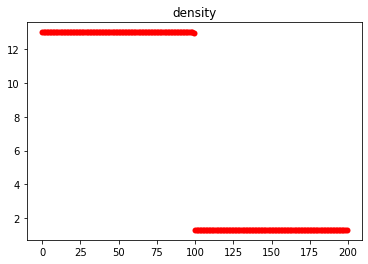

In [15]:
data = [rm.matrix[4000][i][0] for i in range(len(rm.matrix[3000]))]
x_data = [i for i in range(len(rm.matrix[3000]))]
fig1, ax1 = plt.subplots(1)
plt.title('density')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 

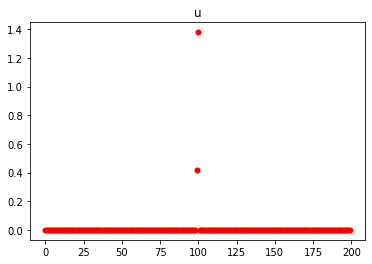

In [16]:
data = [rm.matrix[400][i][1]/rm.matrix[400][i][0] for i in range(len(rm.matrix[400]))]
x_data = [i for i in range(len(rm.matrix[400]))]
fig1, ax1 = plt.subplots(1)
plt.title('u')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 

In [ ]:
data = [rm.matrix[3000][i][2]/rm.matrix[3000][i][0] for i in range(len(rm.matrix[3000]))]
x_data = [i for i in range(len(rm.matrix[3000]))]
fig1, ax1 = plt.subplots(1)
plt.title('e')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 

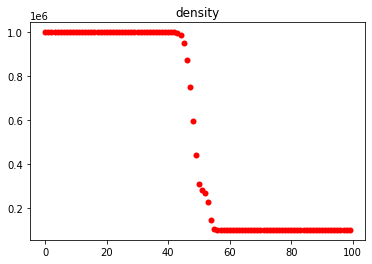

In [25]:
data = [rm.matrix[400][i][2]*(rm.gamma - 1) for i in range(len(rm.matrix[400]))]
x_data = [i for i in range(len(rm.matrix[400]))]
fig1, ax1 = plt.subplots(1)
plt.title('density')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 